# Problem

- An increase in the proportion for the renewable energy power plant in Japanese electricity industry.<p>
- Predicting the amount of electricity supply is becoming more difficult<p>
- The trading volume on the intraday market in Japan is also increasing. <p>
    --> The difference of the planned and the actual electricity supply is expanded. <p>
- The trading price of intraday market tends to be volatile.<p> 
- The electricity suppliers, including producers and retailers, suffered from an unevitable risk due to the uncertainty after submitting day-ahead plan.<p>

# Purpose of the analysis on this notebook

- Interpreting the dataset of electricity trading.<p>
- Seeking useful features for the prediction. <p>
- Seeking more efficient prediction model for intraday Half Hourly(HH) trading price.<p>
    Target: Close price on Intraday market<p>
    --> Comparision of the performance of some prediction models such as Linear, Non-linear and Statistic approach.<p>

# Read & interpret dataset

Loading some datasets <p>
Confirming and interpreting it <p>
Preprocessing missing values and outliers on the datasets

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt #描画ライブラリ
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pathlib
import glob
import math

# Show all the rows and columns up to 200
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

## JEPX_Intra_datasets (Target: "Close price")
http://www.jepx.org/market/index.html

In [2]:
# read the dataset (Here, these are re-organised after getting the latest dataset)

#Intra_dataset
df_intra_2016 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2016.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2017 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2017.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2018 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2018.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2019 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2019.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2020 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2020.csv', sep=',', header=0, encoding='shift_jis')

In [3]:
# marge all the intra datasets
df_intra = pd.concat([df_intra_2016, df_intra_2017])
df_intra = pd.concat([df_intra, df_intra_2018])
df_intra = pd.concat([df_intra, df_intra_2019])
df_intra = pd.concat([df_intra, df_intra_2020])

In [4]:
df_intra = df_intra.rename(columns={'年月日': 'Date', 
                                    '時刻コード': 'HH',
                                    '始値（円/kWh）': 'Open',
                                    '高値（円/kWh）': 'High',
                                    '安値（円/kWh）': 'Low',
                                    '終値（円/kWh）': 'Close',
                                    '平均（円/kWh）': 'Average',
                                    '約定量合計（MWh/h）': 'Volume(MWh/h)',
                                    '約定件数': 'Volume(Tick count)'})

In [5]:
# # Apply to_datetime
df_intra["Date"] = pd.to_datetime(df_intra["Date"])

### Basic characteristics

(Reference) Time series data analysis
https://github.com/mloning/intro-to-ml-with-time-series-DSSGx-2020/blob/master/notebooks/02_exploratory_data_analysis.ipynb

Try to look at the over all transition of close price from 2016 to 2020

In [201]:
# Select the data until 2020-12-31
close_price = df_intra[df_intra['Date'] <= '2020-12-31']
close_price = close_price[['Date', 'HH', 'Close']]

# Fill missing values with interpolate method
close_price.interpolate(method='linear', inplace=True)

In [202]:
close_price["Close"].describe()

count    83328.000000
mean         8.635154
std          4.666505
min          0.010000
25%          6.130000
50%          7.930000
75%         10.000000
max        150.000000
Name: Close, dtype: float64

Make Half Hourly time table which is useful for the following analysis

(Reference)時間の切上げ切り捨てについて
https://www.deep-rain.com/programming/python/1355#i-4

In [203]:
# Make a table for QH_number
# Pick up "HH" columns from df_intra
df_intra_HH = df_intra.reset_index().copy()
HH_table = pd.DataFrame(df_intra_HH["HH"])
HH_table = HH_table.drop_duplicates()

# Make "Time" column 
HH_table['Time'] = pd.date_range('2020/01/01', periods=48,  freq='30min').strftime('%H:%M:%S')
HH_table['Time'] = HH_table['Time'].str[-8:]
# HH_table['Hourly_Time'] = pd.date_range('2020/01/01', periods=48,  freq='30min').floor("H").strftime('%H:%M')
# HH_table['Hourly_Time'] = pd.to_datetime(HH_table['Hourly_Time']).dt.time

HH_table.head()

HH      Time
0   1  00:00:00
1   2  00:30:00
2   3  01:00:00
3   4  01:30:00
4   5  02:00:00

In [204]:
# Combine "Date" and  "Time" to make "DateTime" column
close_price_graph = close_price.copy()
close_price_graph = pd.merge(close_price_graph, HH_table, how="left", on=['HH'])
close_price_graph["Date"] = close_price_graph["Date"].astype(str)
close_price_graph["DateTime"] = pd.to_datetime(close_price_graph["Date"] + " " + close_price_graph["Time"], format='%Y-%m-%d %H:%M')
close_price_graph = close_price_graph.drop(["Date", "HH", "Time"], axis=1)

# Set it as index
close_price_graph.set_index("DateTime", inplace=True)

Try to plot and interpret for the following 2 type of timeframes of the data.
- 30min transition for all items 
- Daily transition for each items

[30min transition for all items]

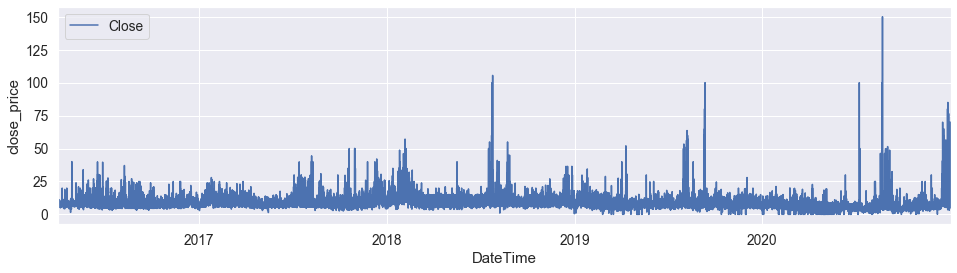

In [205]:
# Simple plot
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))

start = "2016-04-01"
end = "2020-12-31"

close_price_graph["Close"][start : end].plot(ax=ax)
ax.set(ylabel="close_price", xlabel="DateTime")
plt.legend(loc="upper left");

We can see;
- No trend 
- Some seasonal patterns
- Price spike

[Daily transition for each item]

In [206]:
# Pivot to make daily price for each item
close_HH_table = pd.DataFrame(close_price.pivot(index='Date', columns='HH', values='Close'))
col = close_HH_table.loc[: , 0:48]

# Add mean on the table
close_HH_table["mean"] = col.mean(axis=1)

In [207]:
close_HH_table.head()

HH                 1         2         3         4         5         6  \
Date                                                                     
2016-04-01  7.690000  7.450000  7.210000  7.060000  7.210000  7.210000   
2016-04-02  7.500000  6.780000  6.938571  7.097143  7.255714  7.414286   
2016-04-03  6.506667  6.613333  6.720000  6.826667  6.933333  7.040000   
2016-04-04  6.496250  6.487500  6.478750  6.470000  6.465000  6.460000   
2016-04-05  7.000000  7.000000  7.000000  7.000000  7.000000  6.430000   

HH                 7         8     9        10        11        12        13  \
Date                                                                           
2016-04-01  7.210000  7.210000  7.06  7.060000  7.210000  7.290000  7.670000   
2016-04-02  7.572857  7.731429  7.89  8.048571  8.207143  8.365714  8.524286   
2016-04-03  7.146667  7.253333  7.36  7.466667  7.573333  7.680000  7.786667   
2016-04-04  6.510000  6.520000  6.54  6.510000  6.600000  6.520000  6.560000   
2016-04-05  6.480000  6.520000  6.51  6.530000  6.460000  7.260000  7.506667   

HH                14        15    16    17         18        19         20  \
Date                                                                         
2016-04-01  7.670000  7.920000  7.92  5.00  15.000000  9.000000  11.000000   
2016-04-02  8.682857  8.841429  9.00  6.00   7.000000  7.720000   6.000000   
2016-04-03  7.893333  8.000000  8.00  8.00   7.000000  7.000000   7.000000   
2016-04-04  8.120000  8.120000  8.12  8.12   8.531429  8.942857   9.354286   
2016-04-05  7.753333  8.000000  8.00  6.49   6.230000  5.910000   6.080000   

HH                21         22         23     24    25    26     27     28  \
Date                                                                          
2016-04-01  5.000000   5.000000   8.000000   8.00  8.00  8.00   8.00   8.00   
2016-04-02  6.000000   6.000000   6.000000   6.00  6.00  6.00   6.00   6.00   
2016-04-03  7.000000   7.000000   7.000000   7.00  6.63  6.63   6.63   6.63   
2016-04-04  9.765714  10.177143  10.588571  11.00  8.50  8.50  10.00  10.00   
2016-04-05  7.000000   7.000000   7.000000   5.46  6.40  6.40   7.00   7.00   

HH             29     30     31     32     33     34     35     36      37  \
Date                                                                         
2016-04-01   8.18   8.01   8.00   8.00   8.00  11.04   8.00   8.00  12.000   
2016-04-02   6.00   9.00   6.00  11.00   7.72   7.72   8.00  11.00   8.000   
2016-04-03   7.00   7.00   6.84   6.84   6.84   6.84   6.84   6.84   8.290   
2016-04-04  10.00  10.00  10.00  10.00  10.00  10.00  10.00  10.00   9.625   
2016-04-05   7.00   7.00   7.00   7.00   7.00   7.00   7.00   8.63   9.000   

HH             38     39    40    41    42     43    44       45      46  \
Date                                                                       
2016-04-01  12.00  8.500  8.50  8.50  8.50  10.00  8.09  7.99000  8.1400   
2016-04-02   8.05  7.710  7.71  8.00  6.55   6.16  6.30  6.40000  6.4500   
2016-04-03   8.29  8.290  8.29  7.29  6.84   8.00  6.54  6.53125  6.5225   
2016-04-04   9.25  8.875  8.50  8.50  8.00   7.50  7.00  7.00000  7.0000   
2016-04-05   8.90  8.000  7.83  8.00  8.00   8.50  8.00  6.46000  6.4300   

HH               47     48      mean  
Date                                  
2016-04-01  8.14000  8.160  8.162500  
2016-04-02  6.44000  6.400  7.316250  
2016-04-03  6.51375  6.505  7.151302  
2016-04-04  7.00000  7.000  8.285573  
2016-04-05  7.00000  7.000  7.107708

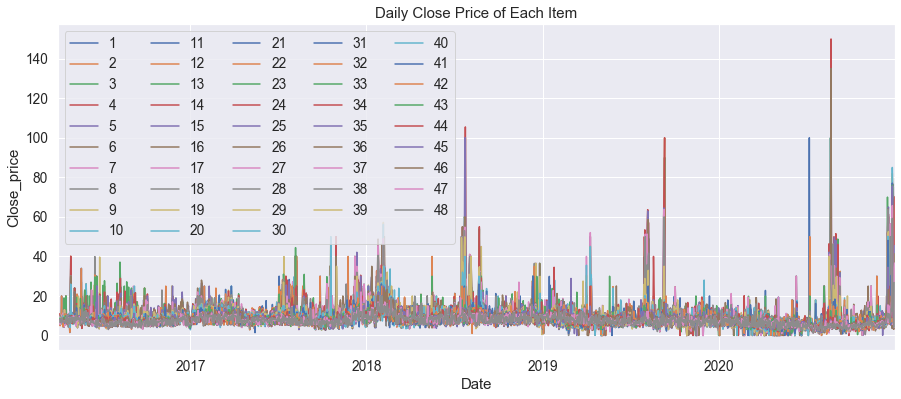

In [208]:
fig, ax = plt.subplots(1, figsize=(15, 6))
plt.title('Daily Close Price of Each Item')

start = "2016-04-01"
end = "2020-12-31"

# Pick up the indexes from 1 to 48
for i in list(range(1,49)):
    # plot all items for a specific periods
    close_HH_table[i][start : end].plot(ax=ax)

# # plot "mean" column
# close_HH_table["mean"][start:end].plot(ax=ax)

ax.set(ylabel="Close_price", xlabel="Date")
plt.legend(loc="upper left", ncol=5);

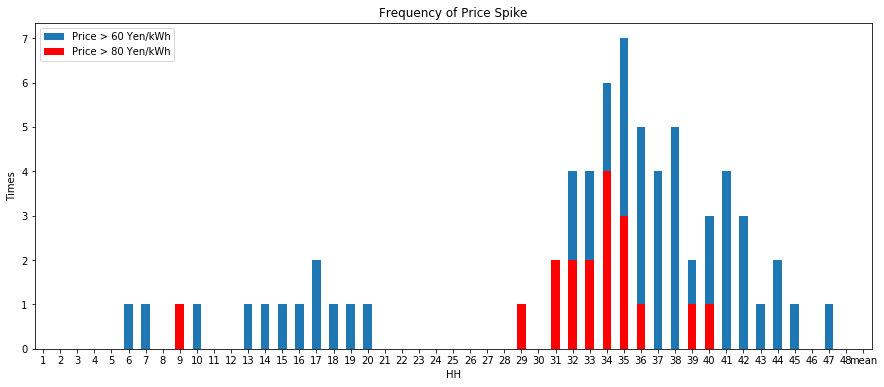

In [13]:
# Plot the number of price spice for each item
fig, ax = plt.subplots(1, figsize=(15, 6))
plt.title('Frequency of Price Spike')

# Count the price spike
PriceSpike_60 = (close_HH_table > 60).sum()
PriceSpike_80 = (close_HH_table > 80).sum()

# Plot
PriceSpike_60.plot.bar(label="Price > 60 Yen/kWh")
PriceSpike_80.plot.bar(label="Price > 80 Yen/kWh", color="r")

plt.xticks(rotation= 0)
plt.ylabel("Times", rotation=90)
ax.legend(loc="upper left");

In [14]:
print(HH_table[HH_table["HH"]==29])
print(HH_table[HH_table["HH"]==41])

    HH      Time
28  29  14:00:00
    HH      Time
40  41  20:00:00


Each item has different move. Contretely, The items for the period from 14:00 to 20:00 tend to easy to spike the price.

Basically, the 30min transition for all items is used for prediction as follows.

### Stationality

参照<p>
https://ailearn.biz/learn/20200830772

<p>
定常性が強すぎる　→　データ群は時間の影響を受けない<p>
定常性が弱すぎる　→　データ群は時間に強く依存する<p>
定常性が強すぎず、弱すぎない（弱定常性）　→　データ群は時間の影響を受ける<p>
""
-->機械学習は定常過程を前提としている
-->定常性がない、もしくは極端に弱いとそのデータはランダムウォークしており、仮にある時点で優位性のあるモデルを構築できたとしても他の期間で再現できないから<p>
-->つまり最低でも弱定常性の仮定がないと機械学習で時系列分析できない<p>
-->定常性の判定が必要！！<p>
-->もし、定常でなければ、階差をとるか対数変換するなどして定常なデータとしなければならない

以下を参照して定常性の検定をしてみる

https://deepblue-ts.co.jp/%E7%B5%B1%E8%A8%88%E5%AD%A6/introduction-to-time-series-analysis/

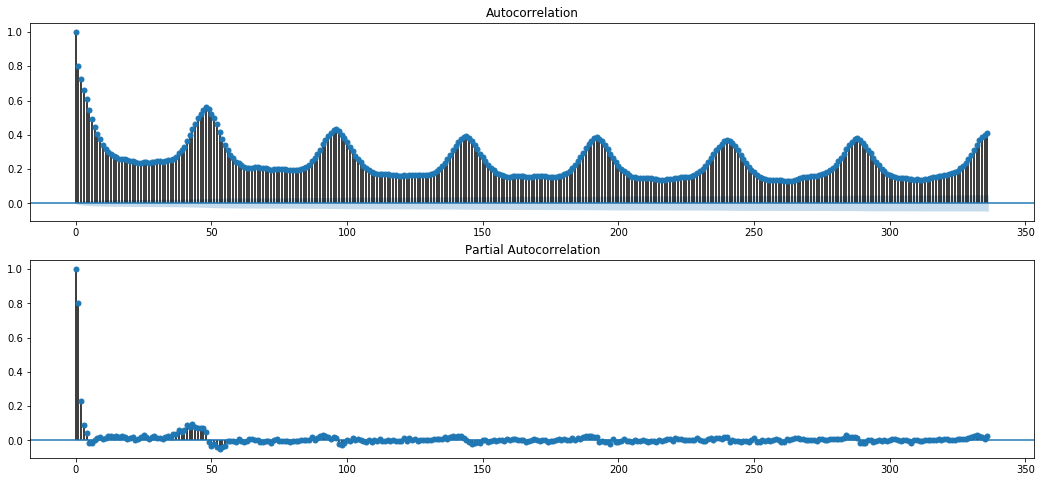

In [15]:
import statsmodels.api as sm

fig = plt.figure(figsize=(18,8))
# Autocorrelation (1lag=30min --> 336 lags=1week)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(close_price_graph, lags=336, ax=ax1)

# Partial Autocorrelation
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(close_price_graph, lags=336, ax=ax2)

- Trend: It looks no trend 
- Seasonality: 48 cycle, which mean strong correlation with 1day lag price 

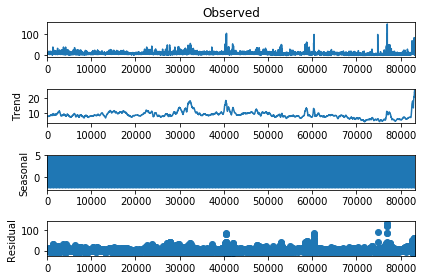

In [16]:
# See the detail the data dividing into trends and seasonalities
seasonal_decompose_res = sm.tsa.seasonal_decompose(close_price_graph.values, freq=336).plot()

※Trend and Seasonality can be seen only if the premeter of "freq" is sufficiently large. (1year?)

Test stationality to the close price data using ADF test (https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

Augmented Dickey-Fuller unit root test (ADF test)
The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

It sets the null hypothesis that there is a unit root, and provide the results of p-value.
--> If null hypothesis can be rejected (p-value > )棄却することができればデータが単位根過程でない、つまり定常であると判断できます。

In [17]:
# logarithmic transformation using Yeo-Johnson
from sklearn.preprocessing import PowerTransformer
import itertools

pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
pt.fit(close_price_graph)
logClose = close_price_graph.copy()
index = logClose.index
logClose = pt.transform(logClose)
# ndarray make flat as a list 
logClose = list(itertools.chain.from_iterable(logClose))
logClose = pd.DataFrame(logClose)
logClose.index = index
logClose.columns = ["Close_log"]
# logClose = diff_logClose.dropna()

In [18]:
logClose.head()

Close_log
DateTime                      
2016-04-01 00:00:00  -0.074394
2016-04-01 00:30:00  -0.147622
2016-04-01 01:00:00  -0.222905
2016-04-01 01:30:00  -0.271054
2016-04-01 02:00:00  -0.222905

In [19]:
# Apply ADF test for original close price and logarithmic price
pvalue_results_30min = pd.DataFrame()
data_list = [close_price_graph, logClose]
data_num = [1, 2]
for data, i in zip(data_list, data_num):
    results = []
    # “ctt” : constant, and linear and quadratic trend.
    ctt = sm.tsa.stattools.adfuller(data, regression="ctt")
    results.append(round(ctt[1], 4))
    # "ct” : constant and trend.
    ct = sm.tsa.stattools.adfuller(data, regression="ct")
    results.append(round(ct[1], 4))
    # “c” : constant only (default)
    c = sm.tsa.stattools.adfuller(data, regression="c")
    results.append(round(c[1], 4))
    # “nc” : no constant, no trend.
    nc = sm.tsa.stattools.adfuller(data, regression="nc")
    results.append(round(nc[1], 4))
    
    pvalue_results_30min[i] = pd.Series(results)

pvalue_results_30min.columns = ["Original", "logClose"]
pvalue_results_30min.index = ["ctt", "ct", "c", "nc"]
pvalue_results_30min

Original  logClose
ctt    0.0000       0.0
ct     0.0000       0.0
c      0.0000       0.0
nc     0.0003       0.0

In [20]:
# Just in case
ctt = sm.tsa.adfuller(logClose, regression="ctt") 
round(ctt[1], 4)

0.0

Surprisingly, the null hypothesis can be rejected both for Original/logClose.(Succeeded: p-value < significance level 5% or 0%)

Let's try to compare histgram of close price with that of logarithmic price

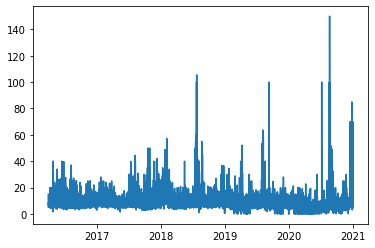

In [21]:
plt.plot(close_price_graph)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c6eae50>]],
      dtype=object)

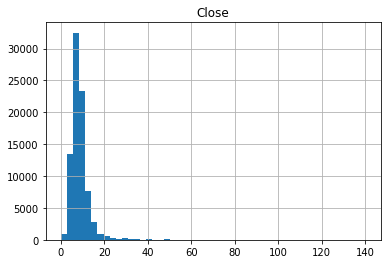

In [22]:
close_price_graph.hist(bins=50, range=(0, 140), rwidth=1.0)

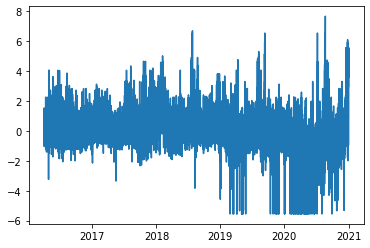

In [23]:
plt.plot(logClose)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c7296d0>]],
      dtype=object)

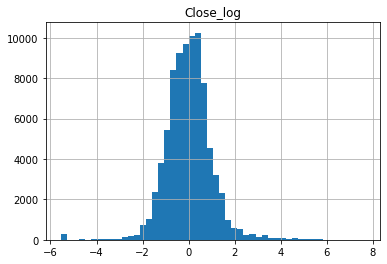

In [24]:
logClose.hist(bins=50, rwidth=1.0)

The distribusion of close price is positive skew while that of the logarithmic price is no skew.<p>
    -->Basically, log price shuold be used for prediction.

~~※　Daily transition for each item (Try to see just in case)~~

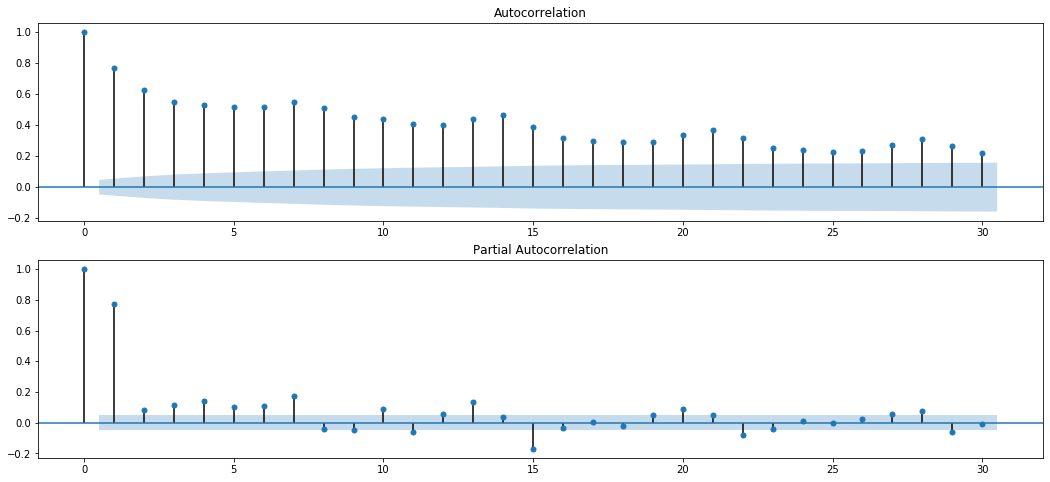

In [25]:
fig = plt.figure(figsize=(18,8))
# Autocorrelation (1lag=1day)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(close_HH_table["mean"], lags=30, ax=ax1)

# Partial Autocorrelation
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(close_HH_table["mean"], lags=30, ax=ax2)

~~Correlation can be seen every 7days~~

In [26]:
# # See the detail the data dividing into trends and seasonalities
# seasonal_decompose_res = sm.tsa.seasonal_decompose(close_HH_table["mean"].values, freq=365).plot()

In [27]:
# # Table for the ADF test of original price
# pvalue_results_daily = pd.DataFrame()
# # make columns for the DataFrame
# cols = list(range(1, 49))

# # ADF test for each item
# for i in list(range(1, 49)):
#     results = []
#     # “ctt” : constant, and linear and quadratic trend.
#     ctt = sm.tsa.stattools.adfuller(close_HH_table[i], regression="ctt")
#     results.append(round(ctt[1], 4))
#     # "ct” : constant and trend.
#     ct = sm.tsa.stattools.adfuller(close_HH_table[i], regression="ct")
#     results.append(round(ct[1], 4))
#     # “c” : constant only (default)
#     c = sm.tsa.stattools.adfuller(close_HH_table[i], regression="c")
#     results.append(round(c[1], 4))
#     # “nc” : no constant, no trend.
#     nc = sm.tsa.stattools.adfuller(close_HH_table[i], regression="nc")
#     results.append(round(nc[1], 4))
#     # Append the results as a columns on the table
#     pvalue_results_daily[i] = pd.Series(results)

# # Set columns/indexes for the DataFrame
# pvalue_results_daily.columns = cols
# pvalue_results_daily.index = ["ctt", "ct", "c", "nc"]


# # Table for the ADF test of logarithmic price
# pvalue_results_daily_log = pd.DataFrame()

# # Transform "close_HH_table" to logarithmic price
# pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
# pt.fit(close_HH_table)
# log_CloseTable = close_HH_table.copy()
# log_CloseTable = pt.transform(log_CloseTable)
# log_CloseTable = pd.DataFrame(log_CloseTable)

# # ADF test for each item
# for i in list(range(1, 49)):
#     results = []
#     # “ctt” : constant, and linear and quadratic trend.
#     ctt = sm.tsa.stattools.adfuller(log_CloseTable[i], regression="ctt")
#     results.append(round(ctt[1], 4))
#     # "ct” : constant and trend.
#     ct = sm.tsa.stattools.adfuller(log_CloseTable[i], regression="ct")
#     results.append(round(ct[1], 4))
#     # “c” : constant only (default)
#     c = sm.tsa.stattools.adfuller(log_CloseTable[i], regression="c")
#     results.append(round(c[1], 4))
#     # “nc” : no constant, no trend.
#     nc = sm.tsa.stattools.adfuller(log_CloseTable[i], regression="nc")
#     results.append(round(nc[1], 4))
#     # Append the results as a columns on the table
#     pvalue_results_daily_log[i] = pd.Series(results)

# # Set columns/indexes for the DataFrame
# pvalue_results_daily_log.columns = cols
# pvalue_results_daily_log.index = ["ctt_log", "ct_log", "c_log", "nc_log"]

In [28]:
# # Concat the two table
# pvalue_results_table = pd.concat([pvalue_results_daily, pvalue_results_daily_log])

# # Transpose the marged table
# pvalue_results_table = pvalue_results_table.T
# pvalue_results_table.head()

~~The null hypothesis cannot be rejected. Let's see the logarithmic price.~~

(メモ)<p>
※対数差分をとるにより定常性をもたせることができるので、価格予測は対数差分変換後に行う必要あり <p>
 -->厳密には差分系列で事足りるがその他の特徴量とスケールを合わせるために対数差分系列を取ることとする

対数差分変換の手順
- Closeの差分を取る
- 差分を対数変換する
-　対数差分変換後のCloseで予測をする

予測後の原系列に戻す手順
- 予測値を逆対数変換する
- 和分変換する

※対数差分変換後のデータは元に戻せることを確認した --> 予測値をもとに戻せるか以下予測後に試す

対数差分系列から原系列へ戻す方法について直感的な解説
https://logics-of-blue.com/time-series-forecast-by-machine-learning/

### Seasonality

ここからは全商品統合の30分足データで進めていく

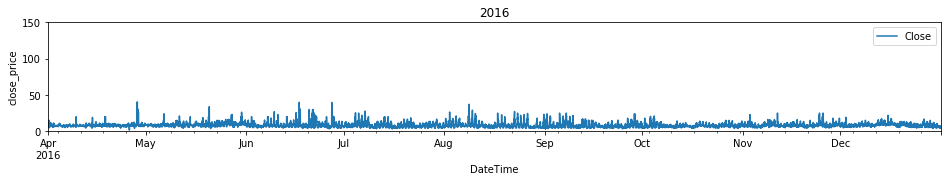

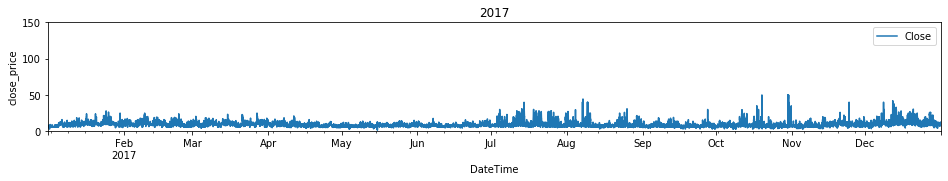

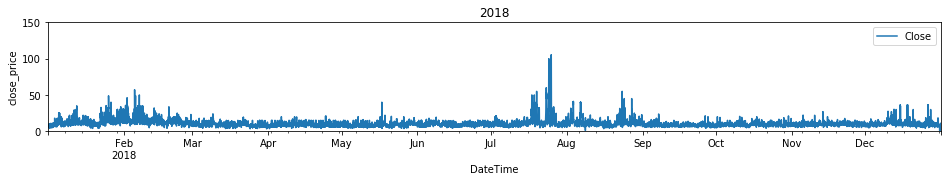

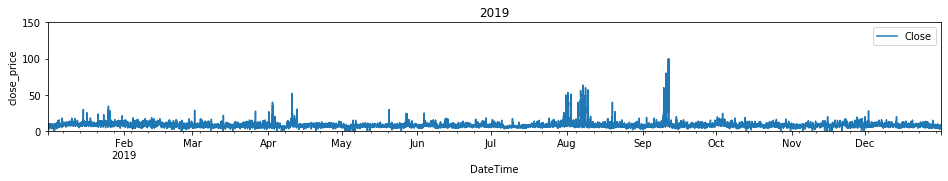

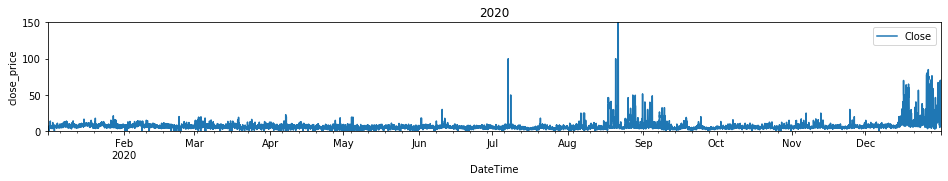

In [29]:
#  Plot close price for each year

years = [2016, 2017, 2018, 2019, 2020]

for year in years:
    start = str(year) + "-01-01 00:00:00"
    end = str(year) + "-12-31 23:30:00"
    close_price_graph_y = close_price_graph[np.logical_and(start < close_price_graph.index, close_price_graph.index <= end)]

    fig, ax = plt.subplots(1, figsize=plt.figaspect(.05))
    close_price_graph_y.plot(ax=ax)
    ax.set_ylim(0, 150)
    ax.set(title=year, ylabel="close_price", xlabel="DateTime");

Can obsearve price spices which tend to be happend from Augast to September, especially since 2018

Let's try to see one more detailed trends to see weekly seasonality.

In [282]:
# Make the table for pivot
close_price_graph_table = close_price_graph.copy()
close_price_graph_table["Year"] = close_price_graph_table.index.year
close_price_graph_table["Month"] = close_price_graph_table.index.month
close_price_graph_table["Week"] = close_price_graph_table.index.isocalendar().week
close_price_graph_table["DayofWeek"] = close_price_graph_table.index.dayofweek
close_price_graph_table["Day"] = close_price_graph_table.index.day
close_price_graph_table["Time"] = close_price_graph_table.index.time
close_price_graph_table = close_price_graph_table.reset_index()
close_price_graph_table = close_price_graph_table.drop("DateTime", axis=1)
close_price_graph_table.head()

Close  Year  Month  Week  DayofWeek  Day      Time
0   7.69  2016      4    13          4    1  00:00:00
1   7.45  2016      4    13          4    1  00:30:00
2   7.21  2016      4    13          4    1  01:00:00
3   7.06  2016      4    13          4    1  01:30:00
4   7.21  2016      4    13          4    1  02:00:00

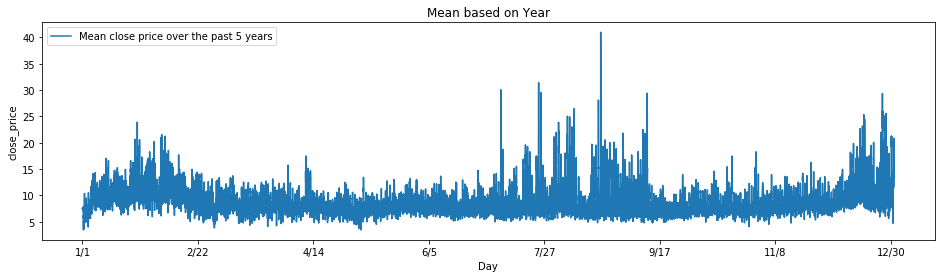

In [31]:
# Plot Average close price for each time slot based on Year
close_price_graph_table_yearly = pd.DataFrame(close_price_graph_table.pivot(index=['Month', 'Day', 'Time'], columns='Year', values='Close'))
year_col = close_price_graph_table_yearly.loc[: , "2016":"2020"]
close_price_graph_table_yearly["Mean"] = year_col.mean(axis=1)
close_price_graph_table_yearly["Date"] = close_price_graph_table_yearly.index.get_level_values('Month').astype(str) + "/" + close_price_graph_table_yearly.index.get_level_values('Day').astype(str) 
close_price_graph_table_yearly = close_price_graph_table_yearly.drop(years, axis=1)
close_price_graph_table_yearly = close_price_graph_table_yearly.reset_index()
close_price_graph_table_yearly = close_price_graph_table_yearly.drop(["Month", "Day", "Time"], axis=1)
close_price_graph_table_yearly = close_price_graph_table_yearly.set_index("Date")

                                                                      
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
close_price_graph_table_yearly.plot(ax=ax)
ax.legend(["Mean close price over the past 5 years"], loc="upper left")
ax.set(title="Mean based on Year", ylabel="close_price", xlabel="Day");

In [229]:
# Plot Average close price for each time slot based on Month
close_price_graph_table_monthly = pd.DataFrame(close_price_graph_table.pivot(index=['Day', 'Time'], columns=['Year', 'Month'], values='Close'))
# month_col = close_price_graph_table_monthly.loc[: , :]
# close_price_graph_table_monthly["Mean"] = month_col.mean(axis=1)
# month_col = month_col.drop("Mean", axis=1)
# close_price_graph_table_monthly = close_price_graph_table_monthly.drop(month_col, axis=1)
# close_price_graph_table_monthly["Date"] = close_price_graph_table_monthly.index.get_level_values('Day').astype(str)
# close_price_graph_table_monthly = close_price_graph_table_monthly.reset_index()
# close_price_graph_table_monthly = close_price_graph_table_monthly.drop(["Day", "Time"], axis=1)
# close_price_graph_table_monthly = close_price_graph_table_monthly.set_index("Date")
# # close_price_graph_table_monthly = close_price_graph_table_monthly.drop(["Month"], axis=1)


# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
# close_price_graph_table_monthly.plot(ax=ax)
# ax.legend(["Mean close price over the past 5 years"], loc="upper left")
# ax.set(title="Mean based on Month", ylabel="close_price", xlabel="Day");

In [230]:
close_price_graph_table_monthly.head()

Year          2016                                                 2017        \
Month           4    5     6     7     8     9     10    11    12    1     2    
Day Time                                                                        
1   00:00:00  7.69  9.0  8.00  5.50  5.99  5.97  6.00  7.27  5.66  8.36  9.49   
    00:30:00  7.45  9.0  7.00  5.50  5.99  5.97  8.39  7.27  7.95  8.08  9.49   
    01:00:00  7.21  9.0  8.00  5.50  4.67  4.60  5.14  6.06  7.74  6.71  9.49   
    01:30:00  7.06  9.0  6.82  5.84  4.67  4.60  5.14  6.06  7.80  7.22  9.49   
    02:00:00  7.21  9.0  7.00  5.84  4.67  5.97  5.29  7.27  7.74  6.70  9.49   

Year                                                                       \
Month           3      4     5     6     7     8     9     10    11    12   
Day Time                                                                    
1   00:00:00  9.00  11.79  6.13  8.00  7.40  5.81  6.50  6.69  7.51  6.71   
    00:30:00  9.00  10.67  6.07  8.00  6.21  7.15  5.98  6.69  6.95  6.79   
    01:00:00  9.00  10.67  6.07  7.30  6.40  7.13  5.66  5.70  6.76  6.29   
    01:30:00  9.06  10.71  8.12  6.56  7.38  7.13  6.61  5.70  6.94  6.29   
    02:00:00  9.00   9.93  6.53  7.64  7.15  7.12  6.70  5.87  7.13  6.71   

Year           2018                                                            \
Month            1      2      3     4     5      6     7      8     9     10   
Day Time                                                                        
1   00:00:00   9.86  14.01   9.05  6.28  8.51   5.85  8.85  11.51  7.72  9.00   
    00:30:00   9.96  11.74   9.00  8.63  8.00   5.86  6.39   6.34  6.66  5.90   
    01:00:00  10.08  14.73   9.69  8.63  7.47  12.60  5.94   6.33  9.30  5.90   
    01:30:00   9.78  12.66   9.78  8.63  8.02   7.82  5.95   5.40  9.00  7.23   
    02:00:00   9.47  12.66  10.00  7.08  8.32   8.75  5.95   7.49  8.53  7.37   

Year                       2019                                              \
Month            11    12    1      2     3     4     5     6     7      8    
Day Time                                                                      
1   00:00:00  10.09  6.00  7.21  10.80  8.93  6.56  6.06  5.33  5.90  10.34   
    00:30:00   6.98  6.00  7.56  10.33  4.00  5.73  5.97  6.08  5.40  10.27   
    01:00:00   8.84  6.00  7.06  10.42  4.00  5.60  4.90  5.99  5.40   7.53   
    01:30:00   6.98  6.00  7.05   9.01  4.00  5.65  4.90  5.99  5.35   7.00   
    02:00:00   7.23  9.22  8.90  10.31  4.00  5.95  4.92  5.96  7.17   7.54   

Year                                   2020                               \
Month           9     10    11     12    1     2     3     4     5    6    
Day Time                                                                   
1   00:00:00  6.53  9.24  4.60  20.00  4.71  6.56  5.40  9.19  3.00  3.0   
    00:30:00  6.47  8.37  6.84  20.00  4.82  6.74  5.00  7.51  9.42  3.0   
    01:00:00  6.08  9.24  6.95  10.83  5.81  6.60  4.96  8.00  3.00  3.0   
    01:30:00  7.79  8.91  7.04  10.72  5.81  6.65  9.46  8.46  8.38  3.0   
    02:00:00  7.79  9.24  7.10   7.00  4.86  6.56  9.65  7.95  3.00  3.0   

Year                                              
Month           7     8     9     10    11    12  
Day Time                                          
1   00:00:00  5.07  3.00  3.50  4.12  4.41  6.14  
    00:30:00  5.02  3.10  4.20  3.75  4.52  4.86  
    01:00:00  4.40  4.64  3.12  3.63  4.50  4.83  
    01:30:00  4.59  4.16  3.12  3.51  4.50  4.86  
    02:00:00  5.15  3.00  3.12  5.03  4.65  4.36

In [256]:
close_price_graph_table["Week"].describe()

count    83328.000000
mean        27.559908
std         14.706974
min          1.000000
25%         15.000000
50%         28.000000
75%         40.000000
max         53.000000
Name: Week, dtype: float64

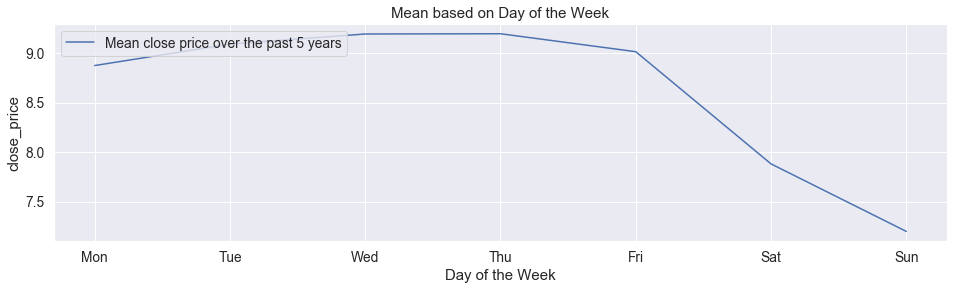

In [284]:
# Plot Average close price for each time slot based on Weekday
close_price_graph_table_Weekly = pd.DataFrame(close_price_graph_table.pivot(index=['DayofWeek', 'Time'], columns=['Year','Month','Week'], values='Close'))
close_price_graph_table_Weekly = close_price_graph_table_Weekly.groupby("DayofWeek").mean()

weekday_col = close_price_graph_table_Weekly.loc[: , :]
close_price_graph_table_Weekly["Mean"] = weekday_col.mean(axis=1)
weekday_col = weekday_col.drop("Mean", axis=1)
close_price_graph_table_Weekly = close_price_graph_table_Weekly.drop(weekday_col, axis=1)
close_price_graph_table_Weekly["index"] = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
close_price_graph_table_Weekly = close_price_graph_table_Weekly.set_index("index")

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
close_price_graph_table_Weekly.plot(ax=ax)
ax.legend(["Mean close price over the past 5 years"], loc="upper left")
ax.set(title="Mean based on Day of the Week", ylabel="close_price", xlabel="Day of the Week");

Daily seasonality can be seen here (There are 31 waves once a month)

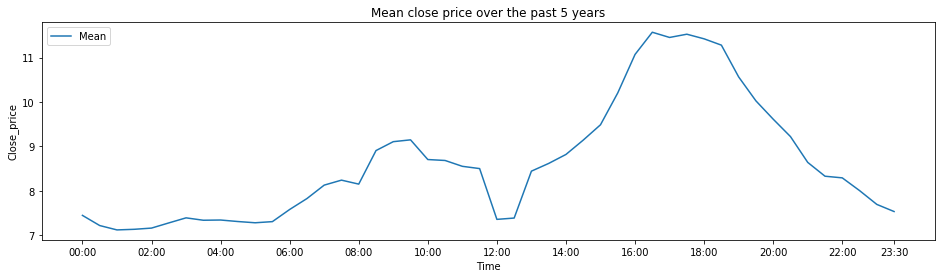

In [33]:
# Plot Average close price for each time slot based on Days(Looking at Daily seasonality)
import matplotlib.ticker as plticker
import matplotlib as mpl
import matplotlib.dates as mdates

close_price_graph_table_daily = pd.DataFrame(close_price_graph_table.pivot(index=['Time'], columns=['Year', 'Month', 'Day'], values='Close'))
day_col = close_price_graph_table_daily.loc[: , :]
close_price_graph_table_daily["Mean"] = day_col.mean(axis=1)
day_col = day_col.drop("Mean", axis=1)
close_price_graph_table_daily = close_price_graph_table_daily.drop(month_col, axis=1)
close_price_graph_table_daily = close_price_graph_table_daily.reset_index()
close_price_graph_table_daily = close_price_graph_table_daily.set_index("Time")


fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
close_price_graph_table_daily.plot(ax=ax)
ax.legend(["Mean"], loc="upper left")
plt.xticks(["00:00:00", "02:00:00", "04:00:00", "06:00:00", "08:00:00", "10:00:00", "12:00:00",
            "14:00:00", "16:00:00", "18:00:00", "20:00:00", "22:00:00", "23:30:00"])

ax.set(title="Mean close price over the past 5 years", ylabel="Close_price", xlabel="Time");

In [227]:
close_price_graph_table_daily.head()

Year          Mean
Month             
Day               
Time              
00:00:00  7.444437
00:30:00  7.215479
01:00:00  7.116997
01:30:00  7.130832
02:00:00  7.158119

Regarding daily seasonality, the close price from 14:00 to 20:00 tend to be high.

(Daily transition for each item)　※Just in case

In [34]:
# # Plot the daily mean of 48 close prices with smoothing.
# rolling_times = 10
# fig = plt.figure(figsize=(20,5),dpi=100)
# color = plt.rcParams['axes.prop_cycle'].by_key()['color']

# #cols = re_close_HH_table.columns[0:48:4] #[Start: End: interval]

# #for col in cols:
# plt.plot(close_HH_table["mean"].rolling(rolling_times).mean(), label=col)

# plt.title('Close_price')
# plt.xlabel('Date')
# plt.ylabel('Close')
# #plt.legend(loc='upper right', fontsize='xx-small')

Here, some price spices can be observed. (2018, 2019, 2021)

See line chart with rollling mean and standard error for some time slots

In [35]:
# time_slot = 'mean' # 1-48 or 'mean'
# window_length = 10 

# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
# close_HH_table[time_slot].plot(ax=ax, label="raw data")
# yt = close_HH_table[time_slot].rolling(window_length).mean()
# yt.plot(ax=ax, label="rolling mean");
# rolling_std = close_HH_table[time_slot].rolling(window_length).std()
# ax.fill_between(close_HH_table[time_slot].index, yt + (2 * rolling_std), yt - (2 * rolling_std), alpha=0.2, color=u'#ff7f0e', label="standard error")
# ax.set(ylabel="Price", xlabel="Time")
# plt.legend();

### Autocorrelation ※ここはEMHを棄却する時に使うことになる
See correlatioin between original price and lagged price

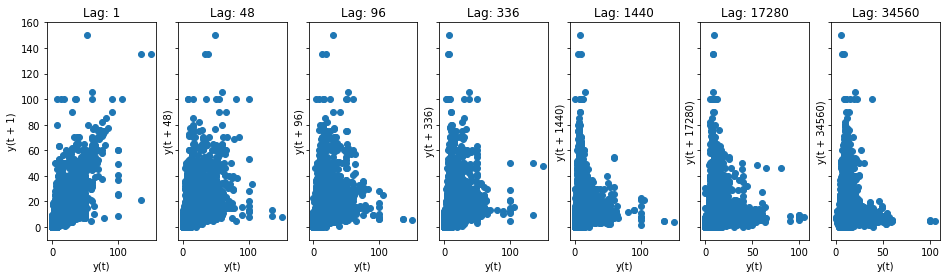

In [36]:
# plot the relation betweeen original/lagged price
from pandas.plotting import lag_plot
lags = [1, 48, 96, 336, 1440, 17280, 34560]
fig, axs = plt.subplots(ncols=7, figsize=plt.figaspect(.25), sharey=True)
for k, lag in enumerate(lags):
    ax = axs[k]
    lag_plot(close_price_graph.Close, lag=lag, ax=ax)
    ax.set_title(f"Lag: {lag}")

1HH --> 30min<p>
48HH --> 1day<p>
96HH --> 2day<p>
336HH --> 1week<p>
1440HH --> 1month<p>
17520HH --> 1year<p>
25040HH --> 2years<p>

Corelation desappear as distance between original price and lagged price get farther.

Let's see which point is the point where the correlation decrease.

In [37]:
# Function for computing autocorrelation between original value and lagged value
def compute_autocorr(x, lags=None):
    """
    Estimate autocorrelation for time series x and given lags
    
    References
    ----------
    ..[1] Time-Series Analysis: Forecasting and Control, 4th ed. (Box, Jenkins, Reinsel), p. 31
    """
    
    x = np.asarray(x) 
    n_timepoints = x.shape[0]
    
    mu = x.mean()
    c_0 = np.var(x)  # np.std(x) * np.std(x)
    
    def corrcoef(k):
        """
        Estimate autocorrelation at lag k (sample autocorrelation function).
        """
        return np.sum((x[:-k] - mu) * (x[k:] - mu)) / n_timepoints / c_0
    
    lags = np.arange(1, n_timepoints)
    
    return np.array([1] + [corrcoef(lag) for lag in lags])

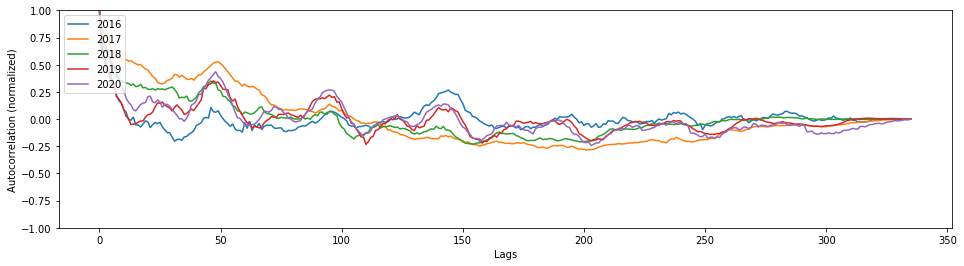

In [38]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))

labels = ["2016", "2017", "2018", "2019", "2020"]
starts = [0, 13201, 30721, 48241, 65761] # index for each year
ends = [13200, 30720, 48240, 65760, 83328] # index for each year
for start, end, label in zip(starts, ends, labels):
    start =start
    end = end
    selected_period = close_price_graph.Close[start:end]
    rho = pd.Series(compute_autocorr(selected_period[0:336]))
    rho.plot(label=label)
    
ax.set(ylim=(-1, 1), xlabel="Lags", ylabel="Autocorrelation (normalized)")
plt.legend(loc="upper left")

Basically, corelation tend to be disappeared with few lagged value, but the speed depends on the year.

This point is very important for rejecting EMH. It will be tested more in detail afterwards.

### Trading vollume from 2014 to 2019

In [39]:
intra_volume = df_intra[df_intra['Date'] <= '2020-12-31']
intra_volume = intra_volume[['Date', 'HH', 'Volume(MWh/h)', 'Volume(Tick count)']]
intra_volume.fillna(0, inplace=True)
intra_volume.head()

Date  HH  Volume(MWh/h)  Volume(Tick count)
0 2016-04-01   1            0.7                   1
1 2016-04-01   2            0.0                   0
2 2016-04-01   3            0.8                   1
3 2016-04-01   4            0.8                   1
4 2016-04-01   5            0.8                   1

Mean of the volume on each item

In [40]:
IntraVolume_HH_mean =  intra_volume.groupby("HH").agg({"Volume(MWh/h)": 'mean', "Volume(Tick count)": 'mean'}).reset_index()
IntraVolume_HH_mean = IntraVolume_HH_mean.set_index("HH")
IntraVolume_HH_mean.head()

Volume(MWh/h)  Volume(Tick count)
HH                                   
1      154.036751           46.823733
2      156.087961           46.158410
3      153.053859           45.424539
4      156.314516           45.206797
5      164.523272           46.363479

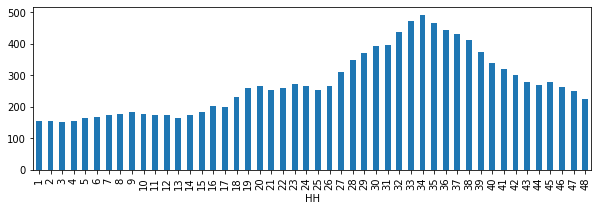

In [41]:
IntraVolume_HH_mean["Volume(MWh/h)"].plot.bar(figsize=(10, 3));

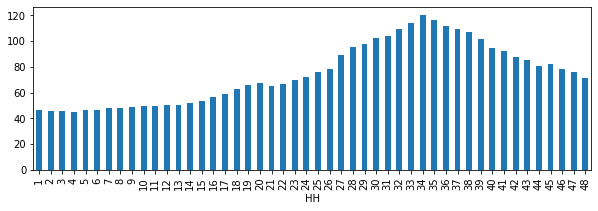

In [42]:
IntraVolume_HH_mean["Volume(Tick count)"].plot.bar(figsize=(10, 3));

The items of 34,35,36 is the peak.

Median of the volume on each item

This shape is similar to daily basis avarage close price

In [43]:
IntraVolume_daily = intra_volume.groupby("Date").agg({"Volume(MWh/h)": 'sum', "Volume(Tick count)": 'sum'}).reset_index()
IntraVolume_daily = IntraVolume_daily.iloc[-200:]
IntraVolume_daily = IntraVolume_daily.set_index("Date")
IntraVolume_daily.tail()

Volume(MWh/h)  Volume(Tick count)
Date                                         
2020-12-27        46104.1                8003
2020-12-28        33976.3                7331
2020-12-29        43122.8                8299
2020-12-30        35332.4                6394
2020-12-31        15349.8                4018

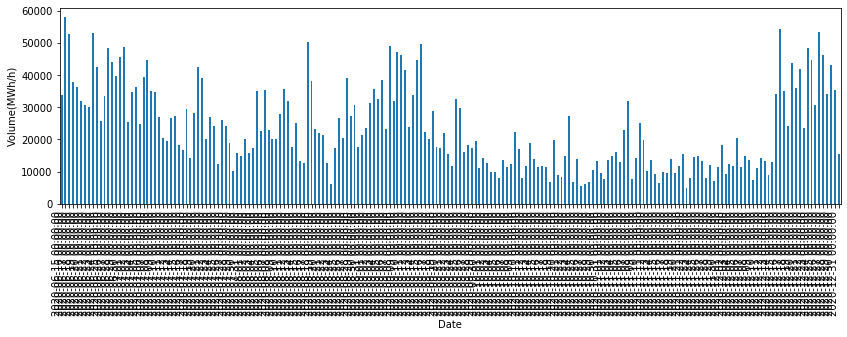

In [44]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime

# 描画
fig, ax = plt.subplots(1, figsize=(14, 4))

# # x axis
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# # plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

# y axis
plt.ylabel("Volume(MWh/h)", rotation=90)

# plot
IntraVolume_daily['Volume(MWh/h)'].plot.bar()
plt.show()

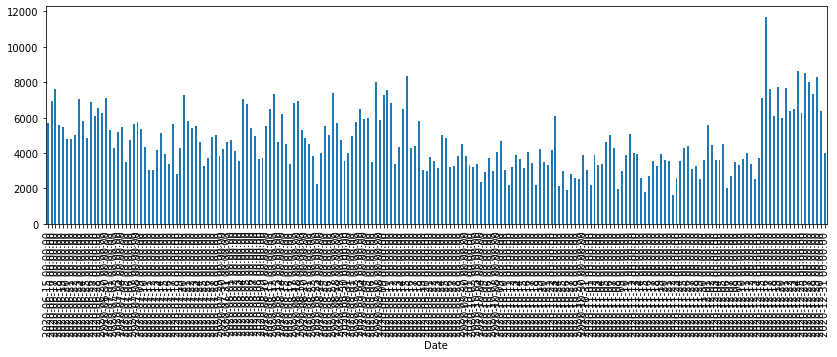

In [45]:
IntraVolume_daily["Volume(Tick count)"].plot.bar(figsize=(14, 4));

The volume have not been increasing so far.

※X軸を修正する

### Other EDA

## JEPX_Spot_datasets
http://www.jepx.org/market/index.html

To do<P>
    seasonality, stationality(以下git-hub講義資料参照) <p>
    https://github.com/mloning/intro-to-ml-with-time-series-DSSGx-2020/blob/master/notebooks/02_exploratory_data_analysis.ipynb <p>
    https://github.com/juanitorduz/btsa/blob/master/python/fundamentals/notebooks/eda_part_2_correlations.ipynb

In [46]:
# read the dataset (Here, these are re-organised after getting the latest dataset)

#Spot_dataset
df_spot_2016 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/spot_2016.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2017 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/spot_2017.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2018 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/spot_2018.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2019 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/spot_2019.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2020 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/spot_2020.csv', sep=',', header=0, encoding='shift_jis')

In [47]:
# marge all the spot datasets
df_spot = pd.concat([df_spot_2016, df_spot_2017])
df_spot = pd.concat([df_spot, df_spot_2018])
df_spot = pd.concat([df_spot, df_spot_2019])
df_spot = pd.concat([df_spot, df_spot_2020])

At first pick up only spot price. BUT need to analyse also others

In [48]:
# Pick up some columns
df_spot = df_spot.drop(['Unnamed: 15', 'スポット・時間前平均価格(円/kWh)', 'Unnamed: 21',
       'α上限値×スポット・時間前平均価格(円/kWh)', 'α下限値×スポット・時間前平均価格(円/kWh)',
       'α速報値×スポット・時間前平均価格(円/kWh)', 'α確報値×スポット・時間前平均価格(円/kWh)', 
       '回避可能原価全国値(円/kWh)',
       '回避可能原価北海道(円/kWh)', '回避可能原価東北(円/kWh)',
       '回避可能原価東京(円/kWh)', '回避可能原価中部(円/kWh)', '回避可能原価北陸(円/kWh)',
       '回避可能原価関西(円/kWh)', '回避可能原価中国(円/kWh)', '回避可能原価四国(円/kWh)',
       '回避可能原価九州(円/kWh)'], axis=1)

In [49]:
# Rename them
df_spot = df_spot.rename(columns={'年月日': 'Date', '時刻コード': 'HH', '売り入札量(kWh)': 'Sell_volume(kWh)',
                                  '買い入札量(kWh)': 'Buy_volume(kWh)', '約定総量(kWh)': 'Total_volume(kWh)', 'システムプライス(円/kWh)': 'System_price(Yen/kWh)', 
                                  'エリアプライス北海道(円/kWh)': 'Price_Hokkaido(Yen/kWh)', 'エリアプライス東北(円/kWh)': 'Price_Tohoku(Yen/kWh)', 
                                  'エリアプライス東京(円/kWh)': 'Price_Tokyo(Yen/kWh)', 'エリアプライス中部(円/kWh)': 'Price_Chubu(Yen/kWh)', 
                                  'エリアプライス北陸(円/kWh)': 'Price_Hokuriku(Yen/kWh)','エリアプライス関西(円/kWh)': 'Price_Kansai(Yen/kWh)', 
                                  'エリアプライス中国(円/kWh)': 'Price_Chugoku(Yen/kWh)', 'エリアプライス四国(円/kWh)': 'Price_Shikoku(Yen/kWh)',
                                  'エリアプライス九州(円/kWh)': 'Price_Kyushu(Yen/kWh)', 
#                                   'α上限値×スポット・時間前平均価格(円/kWh)': 'αUpper_SpotIntraMean', 'α下限値×スポット・時間前平均価格(円/kWh)': 'αLower_SpotIntraMean',
#                                   'α速報値×スポット・時間前平均価格(円/kWh)': 'αPrompt_SpotIntraMean', 'α確報値×スポット・時間前平均価格(円/kWh)': 'αComfirmed_SpotIntraMean', 
#                                   '回避可能原価全国値(円/kWh)': 'Avoidable_price(Yen/kWh)'
                                 })

In [50]:
# # Apply to_datetime
df_spot["Date"] = pd.to_datetime(df_spot["Date"])

In [51]:
df_spot.head()

Date  HH  Sell_volume(kWh)  Buy_volume(kWh)  Total_volume(kWh)  \
0 2016-04-01   1           5077000          2120500             675500   
1 2016-04-01   2           5621500          2239000             755500   
2 2016-04-01   3           5710500          2219000             713500   
3 2016-04-01   4           5536000          2202500             717500   
4 2016-04-01   5           5461000          2192000             870500   

   System_price(Yen/kWh)  Price_Hokkaido(Yen/kWh)  Price_Tohoku(Yen/kWh)  \
0                   6.61                     8.66                   6.69   
1                   6.34                     8.66                   6.34   
2                   6.34                     7.20                   6.34   
3                   6.25                     7.10                   6.03   
4                   6.57                     7.10                   6.57   

   Price_Tokyo(Yen/kWh)  Price_Chubu(Yen/kWh)  Price_Hokuriku(Yen/kWh)  \
0                  6.69                  6.69                     6.69   
1                  6.34                  6.34                     6.34   
2                  6.34                  6.34                     6.34   
3                  6.03                  6.03                     6.03   
4                  6.57                  6.57                     6.57   

   Price_Kansai(Yen/kWh)  Price_Chugoku(Yen/kWh)  Price_Shikoku(Yen/kWh)  \
0                   6.69                    6.69                    6.69   
1                   6.34                    6.34                    6.34   
2                   6.34                    6.34                    6.34   
3                   6.03                    6.03                    6.03   
4                   6.57                    6.57                    6.57   

   Price_Kyushu(Yen/kWh)  
0                   4.00  
1                   4.00  
2                   4.00  
3                   4.00  
4                   5.28

### The relation between System_price and Avoidable_price

In [52]:
# Combine "Date" and  "Time" to make "DateTime" column
spot_price_graph = df_spot.copy()
spot_price_graph = pd.merge(spot_price_graph, HH_table, how="left", on=['HH'])
spot_price_graph["Date"] = spot_price_graph["Date"].astype(str)
spot_price_graph["DateTime"] = pd.to_datetime(spot_price_graph["Date"] + " " + spot_price_graph["Time"], format='%Y-%m-%d %H:%M')

# Set it as index
spot_price_graph.set_index("DateTime", inplace=True)

In [53]:
# # Simple plot of system price and avoidable price
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))

# start = "2019-04-01"
# end = "2019-05-31"

# spot_price_graph["System_price(Yen/kWh)"][start : end].plot(ax=ax)
# spot_price_graph["Avoidable_price(Yen/kWh)"][start : end].plot(ax=ax)

# ax.set(ylabel="Price", xlabel="DateTime")
# plt.legend(loc="upper left");

Avoidable price is almost the same as System price --> Drop

### Data related to α

In [54]:
# # Back calculation of alpha
# w = spot_price_graph["System_price(Yen/kWh)"] / (spot_price_graph["System_price(Yen/kWh)"] +close_price_graph["Close"]) 
# alpha = spot_price_graph["αComfirmed_SpotIntraMean"] / (w * spot_price_graph["System_price(Yen/kWh)"] + (1-w)*close_price_graph["Close"])
# alpha.describe()

In [55]:
# # Simple plot of 　the data related to α
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))

# start = "2016-04-01"
# end = "2020-12-31"

# alpha[start : end].plot(ax=ax)

# ax.set(ylabel="alpha", xlabel="DateTime")
# plt.legend(loc="upper left");

"alpha"
- It seems extreme
- It is calculated with "Close price"
- The method to calculate is contavertial and have been discussing now

--> Drop

(Reference)
- Multiindexを用いた行列調整　https://note.nkmk.me/python-pandas-multiindex-set-reset-sort-swap/

- (参考)　- stack()を用いた列→行への変換方法
https://deepage.net/features/pandas-stack-unstack.html

- pivot_tableの使い方 (stack, unstackも含む)
https://note.nkmk.me/python-pandas-stack-unstack-pivot/

### The relation between spot and close price

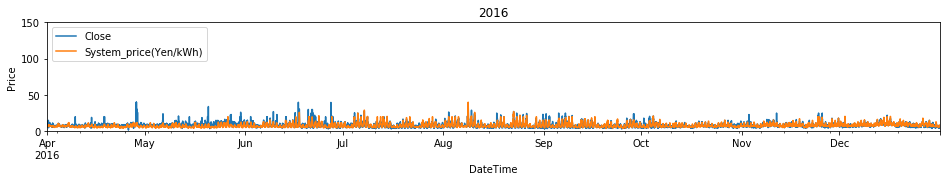

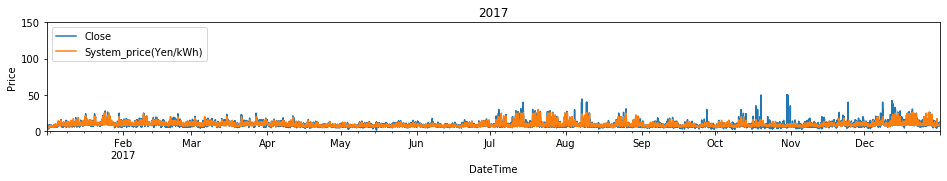

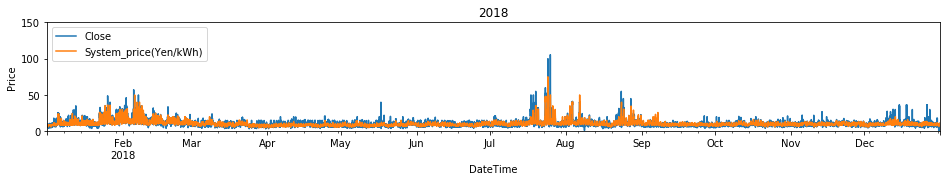

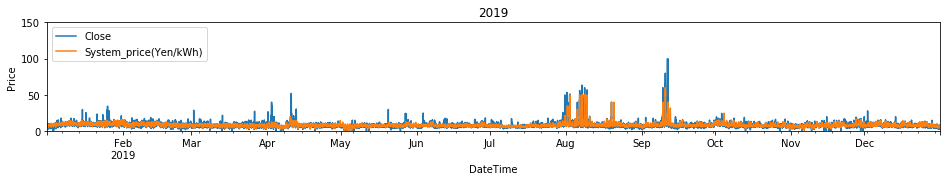

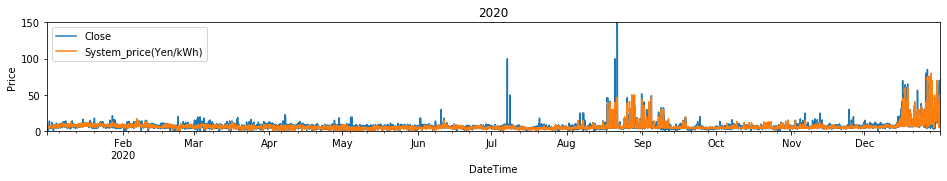

In [56]:
#  Plot close price for a year

years = [2016, 2017, 2018, 2019, 2020]

for year in years:
    start = str(year) + "-01-01 00:00:00"
    end = str(year) + "-12-31 23:30:00"
    #Pick up the periods for Close price
    close_price_graph_y = close_price_graph["Close"][np.logical_and(start < close_price_graph.index, close_price_graph.index <= end)]
    #Pick up the periods for Spot price
    spot_price_graph_y = spot_price_graph["System_price(Yen/kWh)"][np.logical_and(start < spot_price_graph.index, spot_price_graph.index <= end)]

    fig, ax = plt.subplots(1, figsize=plt.figaspect(.05))
    
    #Plot Close price
    close_price_graph_y.plot(ax=ax)
    #Plot Spot price
    spot_price_graph_y.plot(ax=ax)
    
    ax.set_ylim(0, 150)
    ax.set(title=year, ylabel="Price", xlabel="DateTime")
    plt.legend(loc="upper left");

Price spike seems to be affected by seasonal factors...?
[Spot]
- 2018-02(50円)
- 2018-07 (70円) -->不合理な買い入札, 23日の最高気温39度(東京)
- 2018-09 (40円) -->Hokkaido blackout due to earthquake
- 2019-07 (50円)
- 2019-09 (60円) -->9/9：36度(東京)、9/10:35度(東京)
- 2020-08 (50円)
- 2020-09 (50円)
- 2020-12 (80円) -->LNG shock

[Close (Only or much more than Spot price)]
- 2018-07 (100円) -->不合理な買い入札
- 2019-09 (100円) -->9/9：36度(東京)、9/10:35度(東京)
- 2020-07 (100円)
- 2020-08 (150円)

(Reference)
日経クロステック(2018年)「市場からの調達を確実なものにするため、相場感を無視した高値の買い入札が見られた」
https://xtech.nikkei.com/dm/atcl/feature/15/031400070/073100071/?P=2

経産省 (3P.) 「2019年の100円スパイクはリテラシーの低い参加者によるインバランス回避のための不合理な入札」
https://www.emsc.meti.go.jp/activity/emsc_system/pdf/036_04_00.pdf

現時点で考えられるのは
- 不合理な入札行動 (Spotの入札差分)
- 異常気象 (特に猛暑) -->気象予測データが必要
- LNG不足 (2020年末から)

追加できる特徴量は
- 入札差不足量
- 気象予報データ (せめて翌日分のみでも)
- 需要ピーク予測(グラフ参照: https://project.nikkeibp.co.jp/energy/atcl/feature/15/031400073/082100024/?P=3)

### Bidding balance (Add in df_spot as a feature)

In [57]:
# Make a columns for Bid balance
BidExceed_diff = []
Buy_volume_list = list(spot_price_graph["Buy_volume(kWh)"])
Sell_volume_list = list(spot_price_graph["Sell_volume(kWh)"])

for Buy_volume, Sell_volume in zip(Buy_volume_list, Sell_volume_list):
    if  Buy_volume > Sell_volume:
        BidExceed_diff.append(int(Buy_volume - Sell_volume))
    else:
        # Only exceeding volume is added
        BidExceed_diff.append(0) 
        
index = spot_price_graph.index 
spot_price_graph['BidExceed_diff'] = pd.Series(BidExceed_diff, index=index)

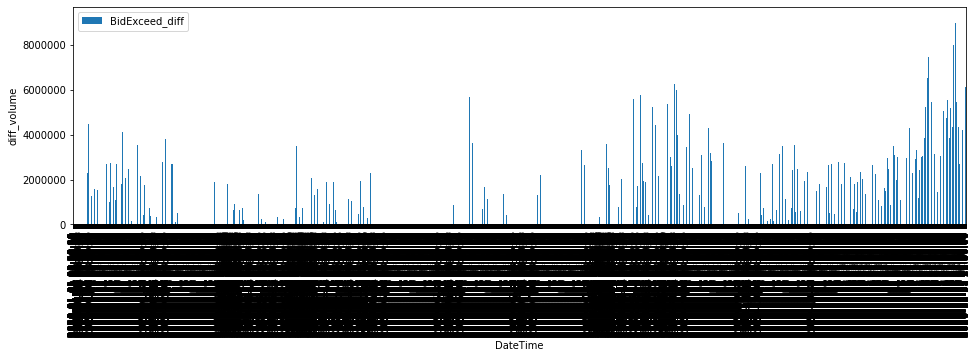

In [58]:
# Simple plot of Sell/buy volume
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))

start = "2020-01-01"
end = "2020-12-31"

spot_price_graph['BidExceed_diff'][start : end].plot.bar()

ax.set(ylabel="diff_volume", xlabel="DateTime")
plt.legend(loc="upper left");

In [59]:
# # 描画 (参照：https://bunsekikobako.com/setting_ticks_by_matplotlib_dates/)
# fig, ax = plt.subplots(figsize=(8, 4))

# #plot
# ax.bar(spot_price_graph['BidExceed_diff'][start : end], 100000)

# # 軸目盛の設定
# ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=100, tz=None))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# ## 補助目盛りを使いたい場合や時刻まで表示したい場合は以下を調整して使用
# # ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1), tz=None))
# # ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))

# # 軸目盛ラベルの回転
# labels = ax.get_xticklabels()
# plt.setp(labels, rotation=45, fontsize=10);

- グラフはいずれ修正
- 一旦特徴量に組み込んでみる

In [60]:
# Add the columns on df_spot
df_spot['BidExceed_diff'] = pd.Series(BidExceed_diff)

### The correlation between Area price in different area and "Close" price.

In [61]:
# marge all the spot datasets
spot_area = pd.concat([df_spot_2016, df_spot_2017])
spot_area = pd.concat([spot_area, df_spot_2018])
spot_area = pd.concat([spot_area, df_spot_2019])
spot_area = pd.concat([spot_area, df_spot_2020])

spot_area = spot_area.drop(['売り入札量(kWh)', '買い入札量(kWh)', '約定総量(kWh)', 'Unnamed: 15', 'スポット・時間前平均価格(円/kWh)',
       'α上限値×スポット・時間前平均価格(円/kWh)', 'α下限値×スポット・時間前平均価格(円/kWh)',
       'α速報値×スポット・時間前平均価格(円/kWh)', 'α確報値×スポット・時間前平均価格(円/kWh)', 'Unnamed: 21',
       '回避可能原価全国値(円/kWh)', '回避可能原価北海道(円/kWh)', '回避可能原価東北(円/kWh)',
       '回避可能原価東京(円/kWh)', '回避可能原価中部(円/kWh)', '回避可能原価北陸(円/kWh)',
       '回避可能原価関西(円/kWh)', '回避可能原価中国(円/kWh)', '回避可能原価四国(円/kWh)',
       '回避可能原価九州(円/kWh)'], axis=1)

spot_area = spot_area.rename(columns={'年月日': 'Date', '時刻コード': 'HH', 
                                  'システムプライス(円/kWh)': 'System_price(Yen/kWh)', 
                                  'エリアプライス北海道(円/kWh)': 'Price_Hokkaido(Yen/kWh)',
                                  'エリアプライス東北(円/kWh)': 'Price_Tohoku(Yen/kWh)',
                                  'エリアプライス東京(円/kWh)': 'Price_Tokyo(Yen/kWh)',
                                  'エリアプライス中部(円/kWh)': 'Price_Chubu(Yen/kWh)',
                                  'エリアプライス北陸(円/kWh)': 'Price_Hokuriku(Yen/kWh)',
                                  'エリアプライス関西(円/kWh)': 'Price_Kansai(Yen/kWh)',
                                  'エリアプライス中国(円/kWh)': 'Price_Chugoku(Yen/kWh)',
                                  'エリアプライス四国(円/kWh)': 'Price_Shikoku(Yen/kWh)',
                                  'エリアプライス九州(円/kWh)': 'Price_Kyushu(Yen/kWh)'})

spot_area["Date"] = pd.to_datetime(spot_area["Date"])

In [62]:
# Pickup close price
intra_close = df_intra[['Date', 'HH', 'Close']]
intra_close["Date"] = pd.to_datetime(intra_close["Date"])

#Marge the tables
spot_intra = pd.merge(spot_area, intra_close,  how='left', on=['Date', 'HH'])

#Adjust the marged table
spot_intra = spot_intra.drop("HH", axis=1)
spot_intra = spot_intra[spot_intra["Date"] <= "2020/12/31"]
spot_intra.fillna(0, inplace=True)

 以下、相関は通年と直近１年で数字が変わるか確認する

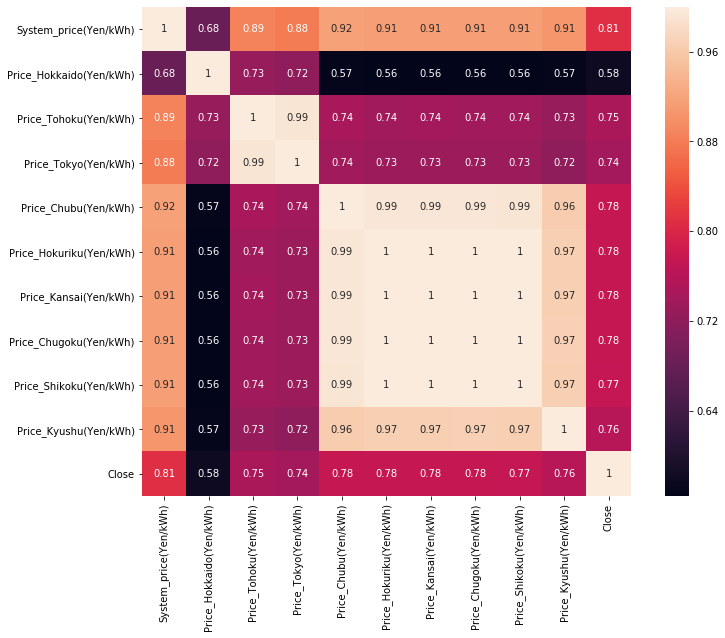

In [63]:
# correlation matrix
corrmat = spot_intra.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True, annot=True, annot_kws={'size': 10});

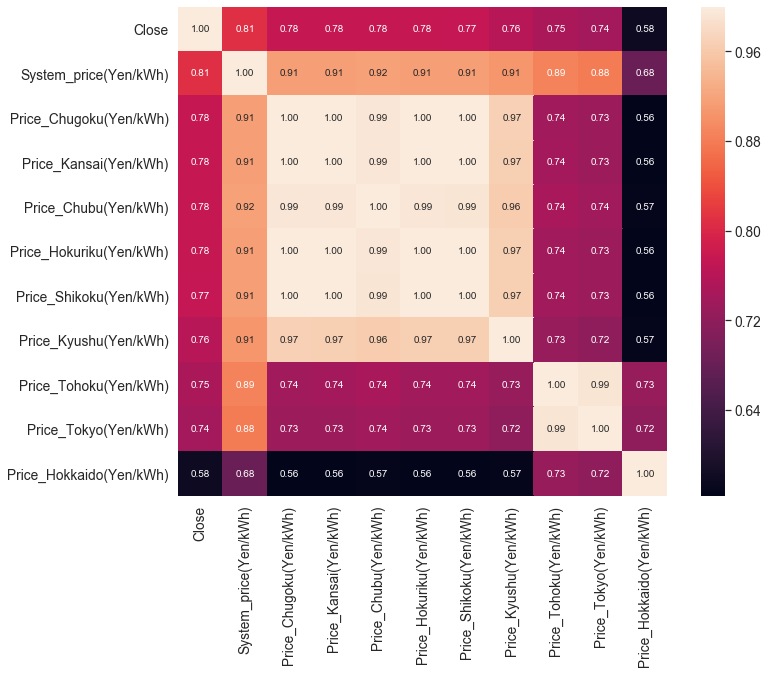

In [64]:
# Close price correlation matrix
k = 11 # The number of variables on the heatmap
cols = corrmat.nlargest(k, 'Close')['Close'].index
cm = np.corrcoef(spot_intra[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12,9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [460]:
df_spot.columns

Index(['Date', 'HH', 'Sell_volume(kWh)', 'Buy_volume(kWh)',
       'Total_volume(kWh)', 'System_price(Yen/kWh)', 'Price_Hokkaido(Yen/kWh)',
       'Price_Tohoku(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 'Price_Chubu(Yen/kWh)',
       'Price_Hokuriku(Yen/kWh)', 'Price_Kansai(Yen/kWh)',
       'Price_Chugoku(Yen/kWh)', 'Price_Shikoku(Yen/kWh)',
       'Price_Kyushu(Yen/kWh)', 'BidExceed_diff'],
      dtype='object')

After confirming the hourly demand, drop features that have high correlation with each other, based on the demand volume. (Refer 3.3 Hourly_Total_Demand)

- System price
- Tokyo
- Kansai
- Hokkaido

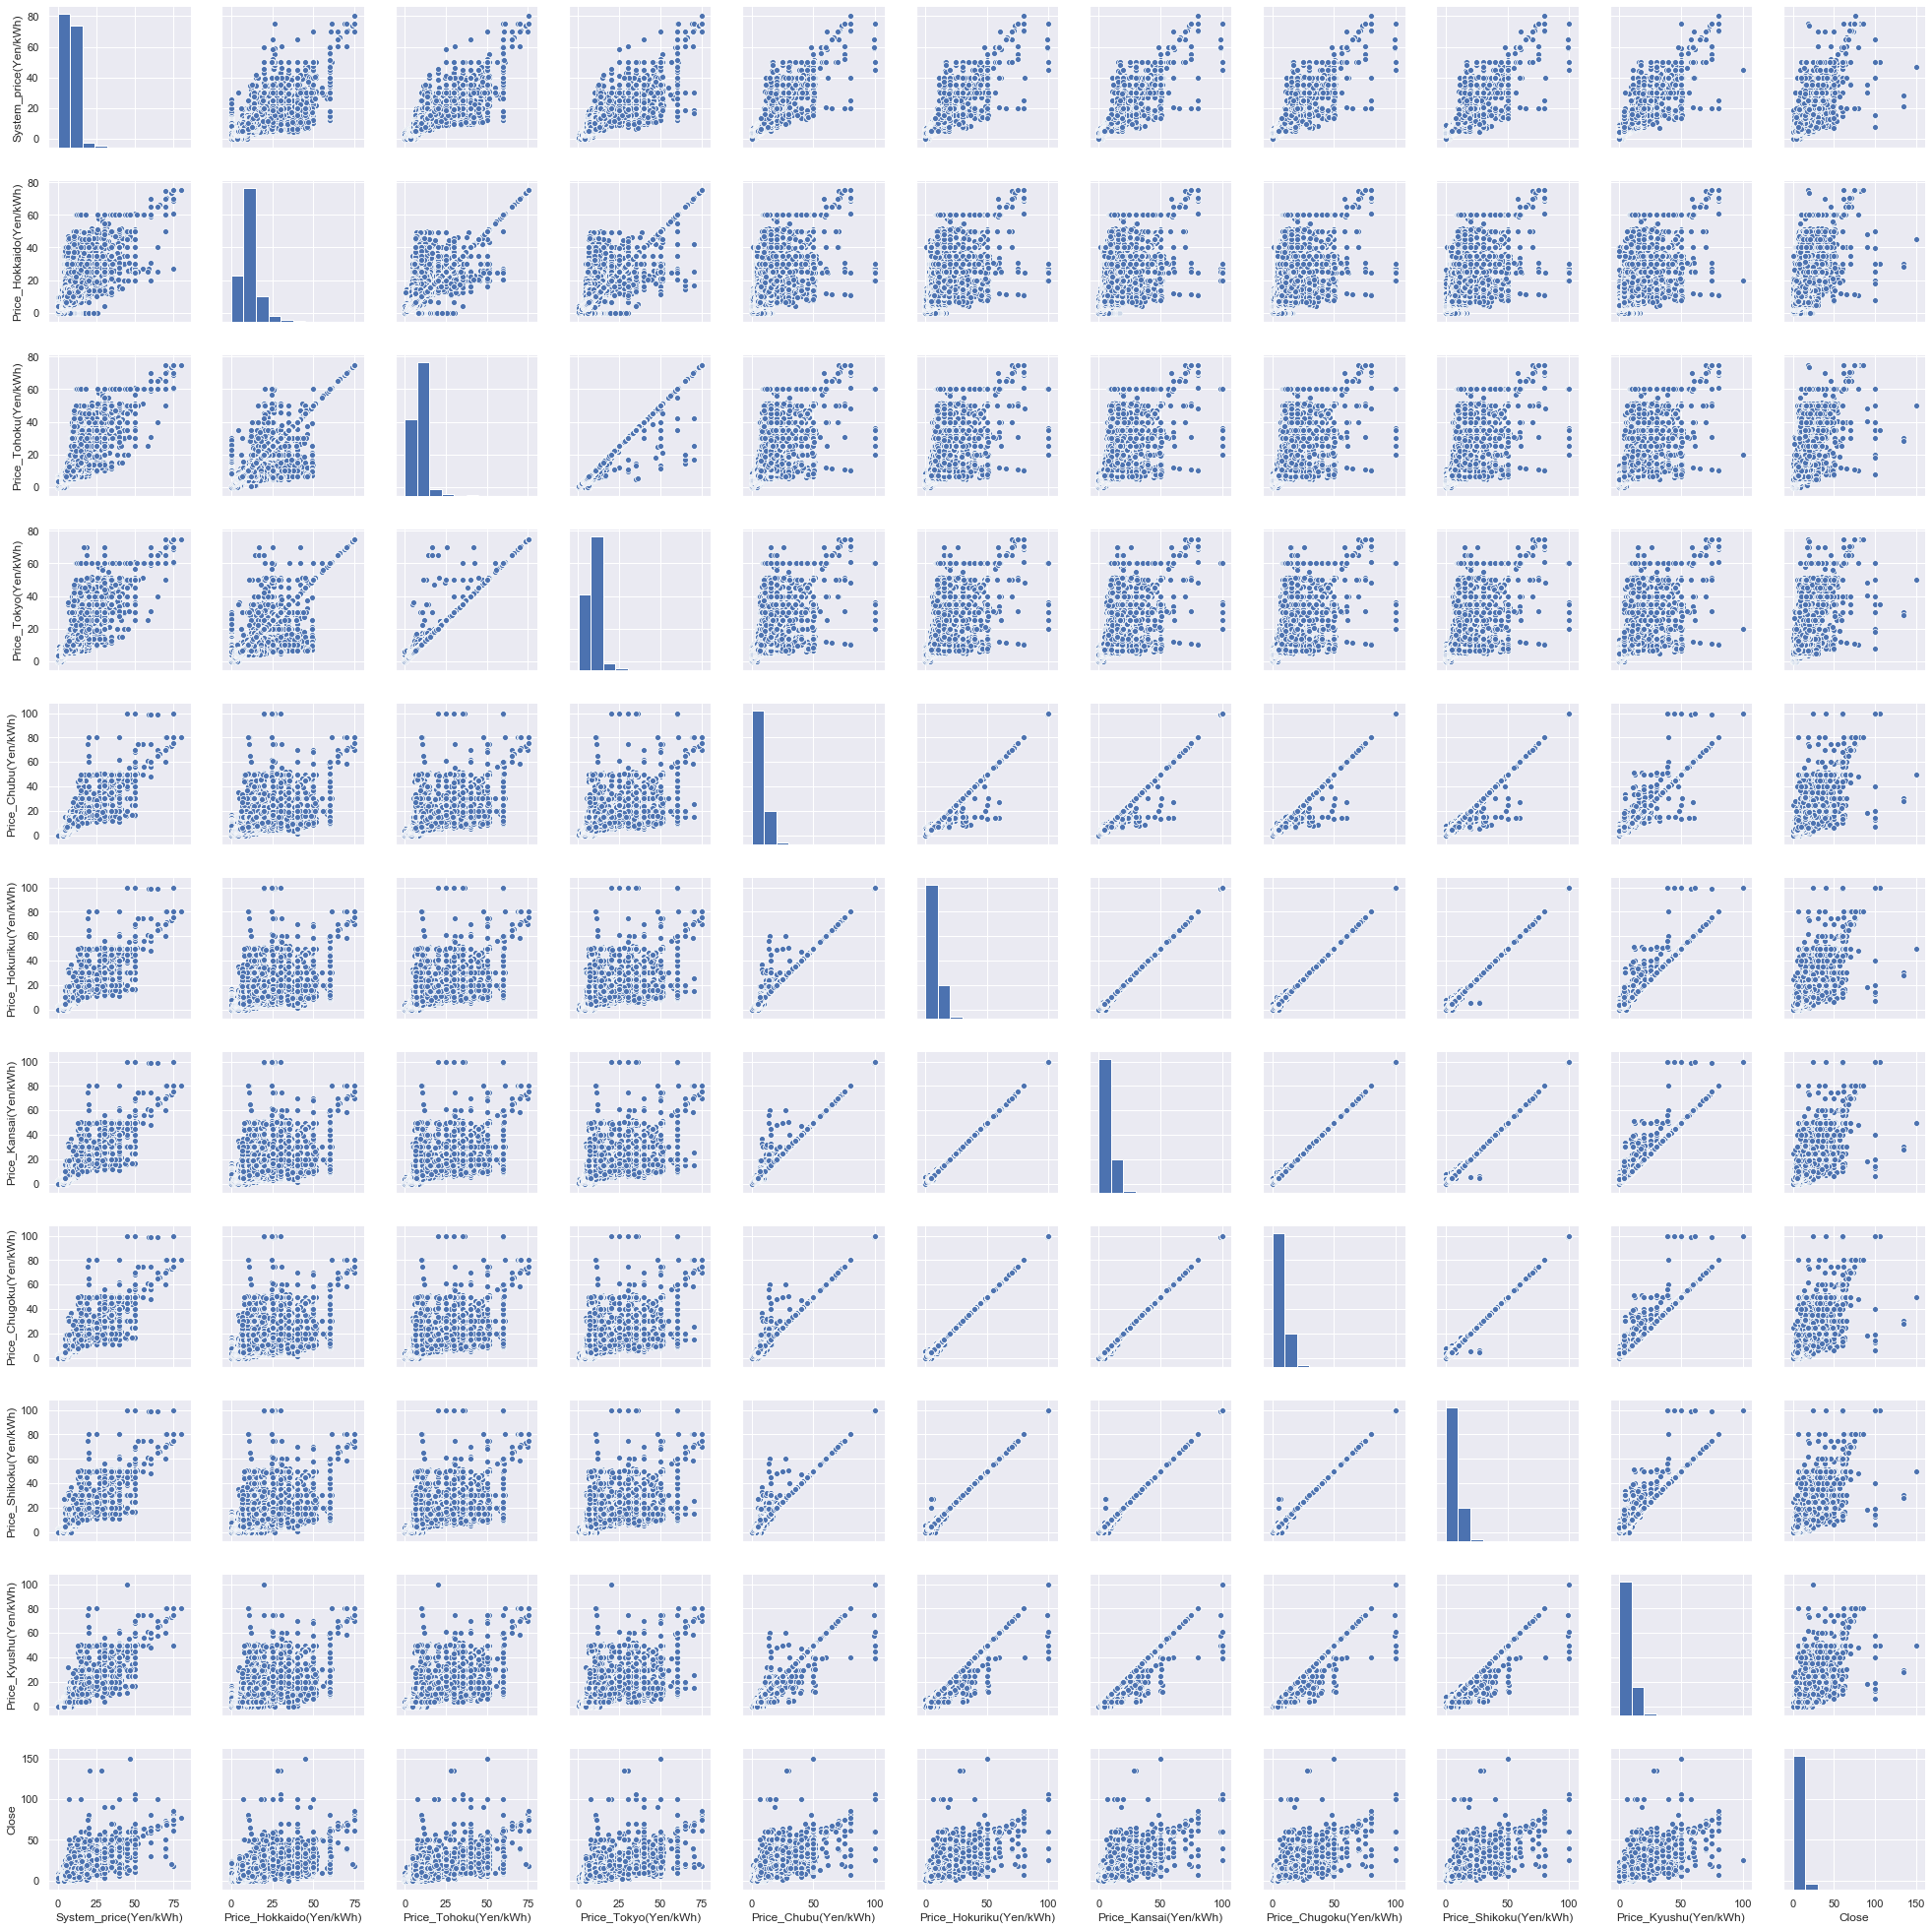

In [66]:
# # scatterplot
# sns.set()
# cols = spot_intra.columns
# sns.pairplot(spot_intra[cols], size=2.5)
# plt.show()

Price: Positive skew <p>
Other: It seems linear relation each other, especially Tohoku and Tokyo
    -->Features which has high correlation with each other could be removed in order to save the calculation cost.

## Hourly_TotalDemand_with_Subtotal_of_EachArea
http://occtonet.occto.or.jp/public/dfw/RP11/OCCTO/SD/LOGIN_login#

時間帯の表記をHH_tableにあわせる

In [67]:
# Hourly demand All_広域
df_HourlyDemand_All = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/需要実績(日別)_ALL.csv', sep=',', header=0, encoding='shift_jis')

In [68]:
# Rename the columns
df_HourlyDemand_All = df_HourlyDemand_All.rename(columns={'年月日': 'Date', '時間帯': 'Period', 
                                                                  '北海道': 'HourlyDemand_Hokkaido', '東北': 'HourlyDemand_Tohoku', '東京': 'HourlyDemand_Tokyo', 
                                                                  '中部': 'HourlyDemand_Chubu', '北陸': 'HourlyDemand_Hokuriku', '関西': 'HourlyDemand_Kansai', 
                                                                  '中国': 'HourlyDemand_Chugoku', '四国': 'HourlyDemand_Shikoku', '九州': 'HourlyDemand_Kyushu', 
                                                                  '沖縄': 'HourlyDemand_Okinawa', '１０エリア計': 'HourlyDemand_Total'
})

In [69]:
# Convert text on the Period column to NaN
df_HourlyDemand_All['Period'] = df_HourlyDemand_All['Period'].replace({'日電力量(MWh)': np.nan, '日最大電力(MW)': np.nan})

# Remove the rows that include NaN
df_HourlyDemand_All = df_HourlyDemand_All[~df_HourlyDemand_All.Period.str.contains("NaN", na=True)]

# Adjust for making "Date" and "Time" columns
df_HourlyDemand_All["DateTime"] = pd.to_datetime(df_HourlyDemand_All["Date"] + " " + df_HourlyDemand_All["Period"].str[:5])
df_HourlyDemand_All["Time"] = pd.to_datetime(df_HourlyDemand_All["DateTime"]).dt.time
df_HourlyDemand_All["Date"] = pd.to_datetime(df_HourlyDemand_All["DateTime"]).dt.date
df_HourlyDemand_All["Date"] = pd.to_datetime(df_HourlyDemand_All["Date"])

# Total_Demand should be dropped because it is also included in another dataset
df_HourlyDemand_All = df_HourlyDemand_All.drop(["Period", "DateTime", "HourlyDemand_Total"], axis=1)

print(df_HourlyDemand_All["Time"].value_counts())


20:00:00    1755
21:00:00    1755
02:00:00    1755
12:00:00    1755
11:00:00    1755
00:00:00    1755
05:00:00    1755
10:00:00    1755
04:00:00    1755
16:00:00    1755
13:00:00    1755
06:00:00    1755
01:00:00    1755
14:00:00    1755
15:00:00    1755
23:00:00    1755
17:00:00    1755
19:00:00    1755
22:00:00    1755
08:00:00    1755
07:00:00    1755
03:00:00    1755
18:00:00    1755
09:00:00    1755
Name: Time, dtype: int64


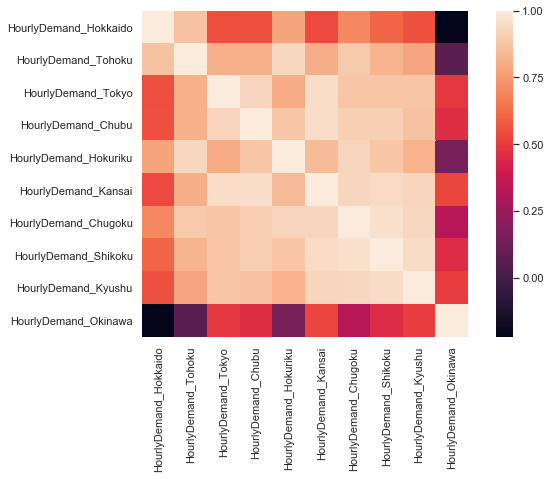

In [70]:
# correlation matrix
corrmat = df_HourlyDemand_All.corr()
f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corrmat, square=True);

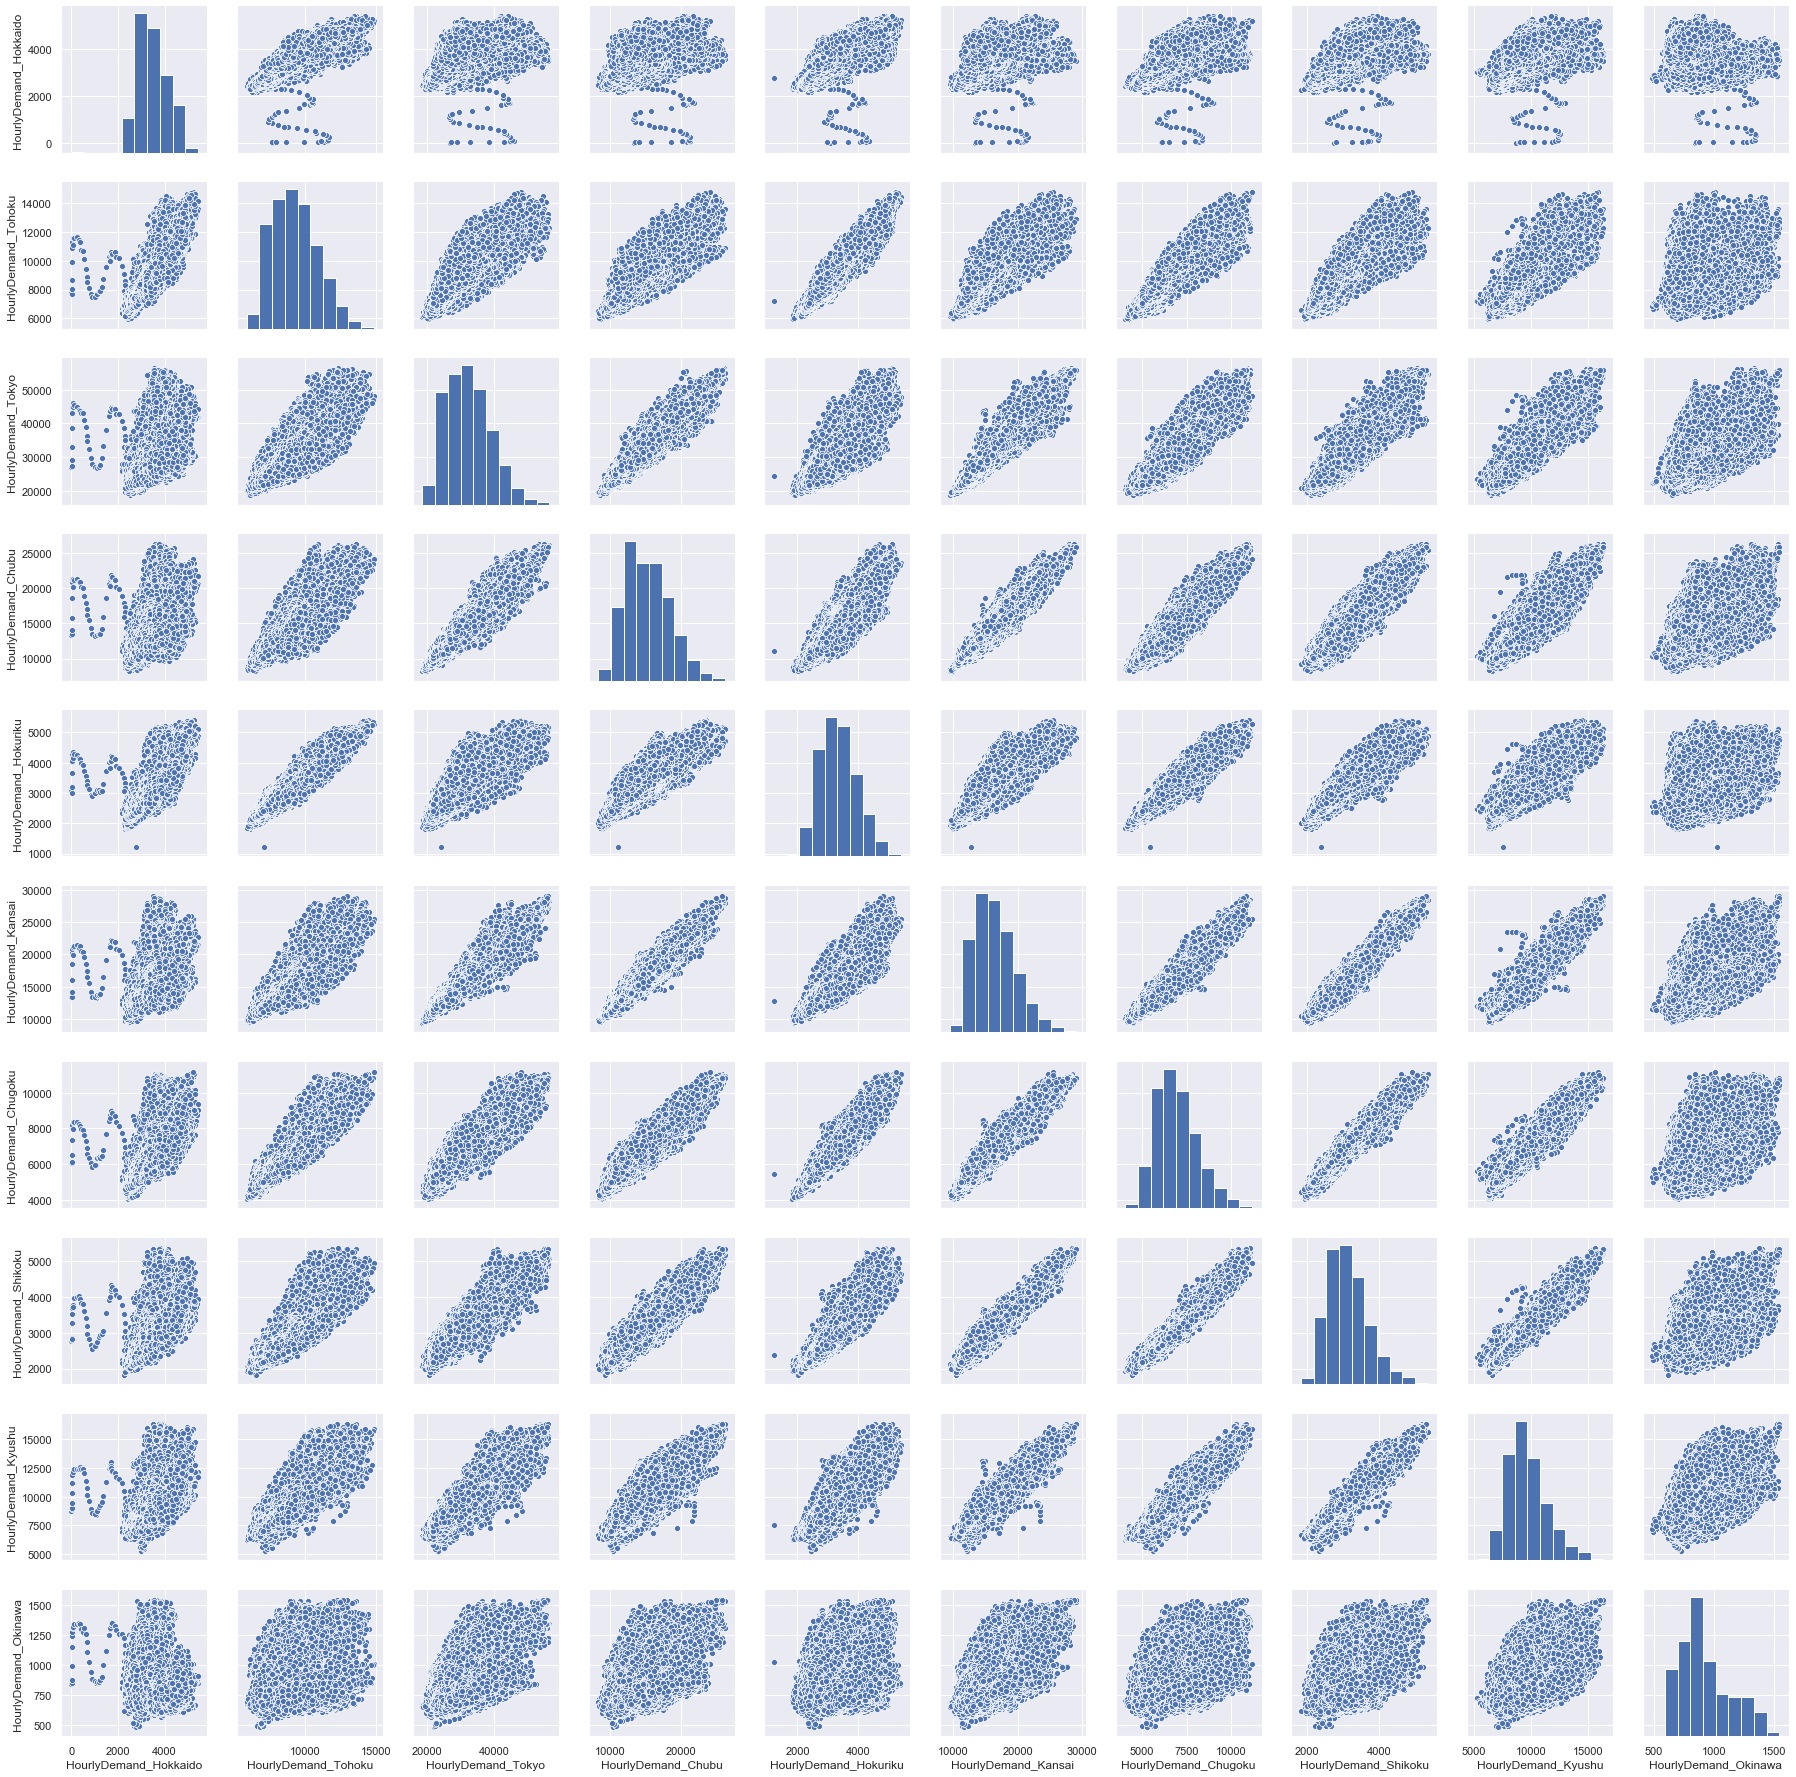

In [71]:
# # scatterplot
# sns.set()
# cols = df_HourlyDemand_All.columns
# sns.pairplot(df_HourlyDemand_All[cols], size=2.5)
# plt.show()

Try to see the irregular patten of the demand on Hokkaido area.

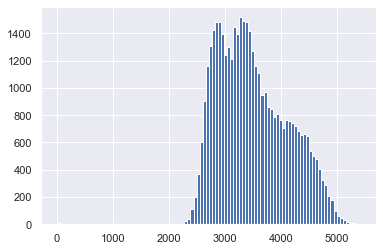

In [72]:
df_HourlyDemand_All["HourlyDemand_Hokkaido"].hist(bins=100, rwidth=1.0);

In [73]:
df_HourlyDemand_All[df_HourlyDemand_All["HourlyDemand_Hokkaido"] < 2300].sort_values('HourlyDemand_Hokkaido', ascending=False).head()

Date  HourlyDemand_Hokkaido  HourlyDemand_Tohoku  \
29362 2019-05-05                   2299                 6853   
23194 2018-09-10                   2298                 6560   
23136 2018-09-07                   2295                 8311   
23135 2018-09-07                   2291                 8560   
38468 2020-04-19                   2288                 7416   

       HourlyDemand_Tokyo  HourlyDemand_Chubu  HourlyDemand_Hokuriku  \
29362               22408               10033                 2039.6   
23194               25218               11094                 2494.3   
23136               34998               16614                 3175.8   
23135               36381               17248                 3335.9   
38468               23157                9932                 2342.8   

       HourlyDemand_Kansai  HourlyDemand_Chugoku  HourlyDemand_Shikoku  \
29362            11168.986              4463.449                  1931   
23194            12418.597              5268.109                  2266   
23136            16836.740              6644.900                  3048   
23135            17671.522              6972.323                  3268   
38468            12133.174              4997.314                  2242   

       HourlyDemand_Kyushu  HourlyDemand_Okinawa      Time  
29362               6560.0                 689.4  08:00:00  
23194               7098.0                 802.4  02:00:00  
23136               9343.0                1102.5  22:00:00  
23135               9868.0                1169.0  21:00:00  
38468               7479.0                 794.8  14:00:00

The cause of the outlier of "HourlyDemand_Hokkaido" was the blackout due to the earthquake. -->Remove after all_data is made

In [461]:
df_HourlyDemand_All.describe()

HourlyDemand_Hokkaido  HourlyDemand_Tohoku  HourlyDemand_Tokyo  \
count           42120.000000         42120.000000        42120.000000   
mean             3489.348884          9304.052042        32430.130722   
std               622.181993          1544.686428         6535.346217   
min                 0.000000          5955.000000        18769.000000   
25%              2982.000000          8031.000000        27259.000000   
50%              3394.000000          9204.000000        31962.000000   
75%              3942.000000         10340.000000        36611.250000   
max              5422.000000         14796.000000        56532.000000   

       HourlyDemand_Chubu  HourlyDemand_Hokuriku  HourlyDemand_Kansai  \
count        42120.000000           42120.000000         42120.000000   
mean         15233.754487            3355.545670         16488.693380   
std           3139.964034             603.717923          3183.177316   
min           8258.000000            1221.300000          9407.306000   
25%          12762.000000            2896.875000         13975.209500   
50%          14909.000000            3310.750000         16128.331000   
75%          17333.000000            3757.300000         18448.195750   
max          26243.000000            5414.000000         29103.350000   

       HourlyDemand_Chugoku  HourlyDemand_Shikoku  HourlyDemand_Kyushu  \
count          42120.000000          42120.000000         42120.000000   
mean            6937.247443           3141.618091          9728.118872   
std             1162.905860            565.316150          1712.449576   
min             4054.423000           1828.000000          5280.043000   
25%             6074.358500           2726.000000          8492.598250   
50%             6793.840500           3075.000000          9460.000000   
75%             7652.116500           3468.000000         10683.000000   
max            11181.227000           5362.000000         16374.000000   

       HourlyDemand_Okinawa  
count          42120.000000  
mean             929.340838  
std              208.596365  
min              489.400000  
25%              775.800000  
50%              878.100000  
75%             1060.200000  
max             1544.500000

Regarding spot price, keep the following information (Refer 3.2.5 The correlation between area price and close price)
- System price
- Tokyo
- Kansai
- HokkaidoHokkaido, 
- Tokyo

In [463]:
df_spot.columns

Index(['Date', 'HH', 'Sell_volume(kWh)', 'Buy_volume(kWh)',
       'Total_volume(kWh)', 'System_price(Yen/kWh)', 'Price_Hokkaido(Yen/kWh)',
       'Price_Tohoku(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 'Price_Chubu(Yen/kWh)',
       'Price_Hokuriku(Yen/kWh)', 'Price_Kansai(Yen/kWh)',
       'Price_Chugoku(Yen/kWh)', 'Price_Shikoku(Yen/kWh)',
       'Price_Kyushu(Yen/kWh)', 'BidExceed_diff'],
      dtype='object')

In [464]:
# Based on the demand level, drop some features that have high correlation fron df_spot
df_spot = df_spot.drop(['Price_Tohoku(Yen/kWh)',  'Price_Chubu(Yen/kWh)', 'Price_Chugoku(Yen/kWh)',
                        'Price_Shikoku(Yen/kWh)', 'Price_Kyushu(Yen/kWh)', 'Price_Hokuriku(Yen/kWh)'], axis=1)

It is ready.

## Hourly_TodalDemand_with_Generation_from_DifferentPower ※頑張って全電力会社分集めてみる

北海道：https://www.hepco.co.jp/network/renewable_energy/fixedprice_purchase/supply_demand_results.html <p>
東北: https://setsuden.nw.tohoku-epco.co.jp/download.html <p>
東京: https://www.tepco.co.jp/forecast/html/area_data-j.html <p>
中部: https://powergrid.chuden.co.jp/denkiyoho/ <p>
北陸: http://www.rikuden.co.jp/nw_jyukyudata/area_jisseki.html <p>
関西: https://www.kansai-td.co.jp/denkiyoho/area-performance.html <p>
中国:　https://www.energia.co.jp/nw/service/retailer/data/area/ <p>
四国:　https://www.yonden.co.jp/nw/renewable_energy/data/supply_demand.html <p>
九州:　https://www.kyuden.co.jp/td_service_wheeling_rule-document_disclosure <p>
沖縄:　https://www.okiden.co.jp/business-support/service/supply-and-demand/

In [649]:
# File path
path = '/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/actual_generation_demand/'

In [650]:
# Tohoku as a base
df_Demand_AreaPlant = pd.read_csv(path + "/Demand_plant_Tohoku.csv", sep=',', header=0, encoding='shift_jis')
df_Demand_AreaPlant["DateTime"] =  pd.to_datetime(df_Demand_AreaPlant["DateTime"])
 
Areas = ["Hokkaido", "Tokyo", "Chubu", "Hokuriku", "Kansai", "Chugoku", "Shikoku", "Kyushu", "Okinawa"]

# Add other areas
for area in Areas:
    df = pd.read_csv(path + "/Demand_plant_" + area + ".csv", sep=',', header=0, encoding='shift_jis')
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df_Demand_AreaPlant = pd.merge(df_Demand_AreaPlant, df, how="left", on="DateTime")

df_Demand_AreaPlant.fillna(0, inplace=True)

In [651]:
# Drop columns that contain only 0
tmp=df_Demand_AreaPlant==0
col=df_Demand_AreaPlant.columns.values[tmp.sum(axis=0)==len(df_Demand_AreaPlant)]
df_Demand_AreaPlant = df_Demand_AreaPlant.drop(col, axis=1)

In [652]:
# Adjust Datatype from object to float for Tokyo and Kyushu area (Had to preprocess separately)
object_cols = ["TotalDemand_TKO", "Thermal_TKO", "TotalSupply_TKO", "TotalDemand_KYU", 
               "Nuclear_KYU", "Thermal_KYU", "PVCurtailment_KYU", "PumpedStorage_KYU", "Interconnection_KYU"]

for col in object_cols:
    df_Demand_AreaPlant[col] = df_Demand_AreaPlant[col].apply(lambda x: float(x.replace(",", "")))
    df_Demand_AreaPlant[col] = pd.to_numeric(df_Demand_AreaPlant[col].replace({',':'', '−':0}), downcast='integer')
    
# Adjust Datatype from object to float for Chugoku area (Had to preprocess separately)
object_cols = ["PVCurtailment_CHG", "WindCurtailment_CHG"]

for col in object_cols:
    df_Demand_AreaPlant[col] = pd.to_numeric(df_Demand_AreaPlant[col].replace({',':'', '−':0}), downcast='integer')

In [653]:
# Calculate statistical results for each area
def get_group_stats(df):
        col_names = ["TotalDemand", "Water", "Thermal", "Nuclear", "PV", "PVCurtailment", "Wind", 
                       "WindCurtailment", "Geothermal", "Biomass", "PumpedStorage", "Interconnection"]
        for group in col_names:
            cols = [col for col in df.columns if group in col]
            df[f"Allarea_{group}"] = df[cols].sum(axis=1)

        return df

In [654]:
df_Demand_AreaPlant = get_group_stats(df_Demand_AreaPlant)

In [655]:
df_Demand_AreaPlant["Water_Ratio"] = round(df_Demand_AreaPlant["Allarea_Water"] / df_Demand_AreaPlant["Allarea_TotalDemand"], 2)
df_Demand_AreaPlant["Thermal_Ratio"] = round(df_Demand_AreaPlant["Allarea_Thermal"] / df_Demand_AreaPlant["Allarea_TotalDemand"], 2)
df_Demand_AreaPlant["Geothermal_Ratio"] = round(df_Demand_AreaPlant["Allarea_Geothermal"] / df_Demand_AreaPlant["Allarea_TotalDemand"], 2)

# df_Demand_AreaPlant = df_Demand_AreaPlant.replace([np.inf, -np.inf], np.nan)
# df_Demand_AreaPlant.fillna(0, inplace=True)

In [656]:
# Make the columns for "Time" and "Date"
df_Demand_AreaPlant["Time"] = pd.to_datetime(df_Demand_AreaPlant["DateTime"]).dt.time
df_Demand_AreaPlant["Date"] = pd.to_datetime(df_Demand_AreaPlant["DateTime"]).dt.date
df_Demand_AreaPlant["Date"] = pd.to_datetime(df_Demand_AreaPlant["Date"])

# Drop the columns that have no value and Total_supply that is the same as Total_demand
df_Demand_AreaPlant = df_Demand_AreaPlant.drop(["DateTime", "PVCurtailment_CHG", "WindCurtailment_CHG", 
                                                "TotalSupply_HOK", "TotalSupply_TKO", "TotalSupply_SHI", "TotalSupply_OKI"],  axis=1)

In [657]:
# data table for heatmap
intra_close = df_intra[["Date", "HH", "Close"]]
Demand_AreaPlant_withClose = pd.merge(df_Demand_AreaPlant, HH_table, how='left', on=["Time"])
Demand_AreaPlant_withClose = pd.merge(Demand_AreaPlant_withClose, intra_close, how='left', on=['Date', 'HH'])
Demand_AreaPlant_withClose["Close"] = Demand_AreaPlant_withClose["Close"].fillna(0)

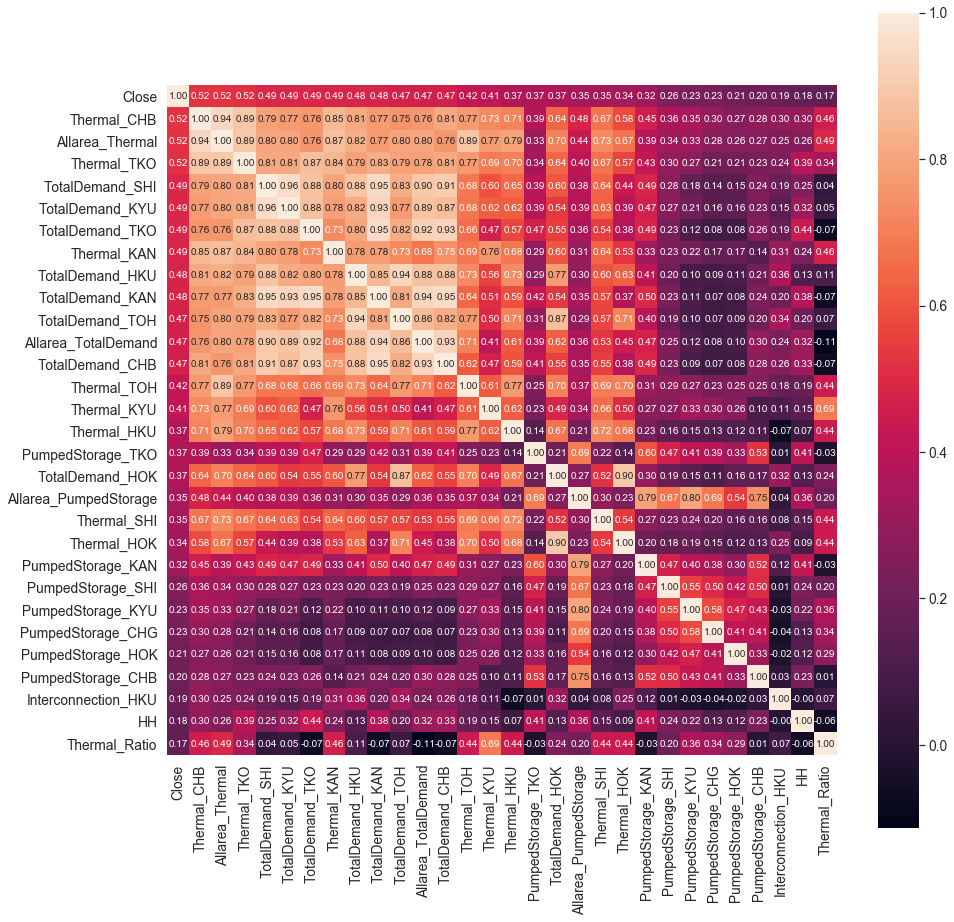

In [658]:
# correlation matrix
corrmat = Demand_AreaPlant_withClose.corr()

# revenue correlation matrix
k = 30 # The number of variables on the heatmap
cols = corrmat.nlargest(k, 'Close')['Close'].index
cm = np.corrcoef(Demand_AreaPlant_withClose[cols].values.T)
f, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Keep the features of thermal plant in all the area, and total information

In [610]:
# # Drop features that have high correlation with each other as much as possible
# df_Demand_AreaPlant = df_Demand_AreaPlant.drop([
#                                                 "TotalDemand_TOH", "TotalDemand_CHB", "TotalDemand_CHG", "TotalDemand_SHI", 
#                                                 "TotalDemand_KYU", "TotalDemand_HKU", "TotalDemand_TKO","TotalDemand_KAN","TotalDemand_OKI", "TotalDemand_HOK",
#                                                 "Thermal_CHB", "Thermal_TKO", "Thermal_KAN", "Thermal_TOH", "Thermal_KYU", "Thermal_HKU", "Thermal_SHI", "Thermal_HOK",
#                                                 "PumpedStorage_TKO", "PumpedStorage_KAN", "PumpedStorage_SHI", "PumpedStorage_KYU", "PumpedStorage_CHG", 
#                                                 "PumpedStorage_HOK", "PumpedStorage_CHB", "Water_KAN", "Water_CHB", "Water_HOK", "Water_OKI", "Water_TKO",
#                                                 "Water_HOK", "Water_KYU", "Water_TOH", "Water_SHI", "Water_HKU", "PV_TKO", "PV_SHI", "PV_KAN", "PV_CHB", 
#                                                 "PV_TKO", "PV_HKU", "PV_HOK", "PV_TOH", "PV_CHG", "Allarea_WindCurtailment", "Allarea_PV", "Allarea_PVCurtailment", "Biomass_CHG",
#                                                 "Biomass_HKU", "Biomass_SHI", "Biomass_HOK", "Biomass_TKO", "Biomass_KYU", "Biomass_HKU", "Biomass_TOH", "PV_OKI", 
#                                                 "Allarea_Nuclear", "Allarea_Wind"
#                                                ], axis=1)

In [611]:
# # data table for heatmap
# intra_close = df_intra[["Date", "HH", "Close"]]
# Demand_AreaPlant_withClose = pd.merge(df_Demand_AreaPlant, HH_table, how='left', on=["Time"])
# Demand_AreaPlant_withClose = pd.merge(Demand_AreaPlant_withClose, intra_close, how='left', on=['Date', 'HH'])
# Demand_AreaPlant_withClose["Close"] = Demand_AreaPlant_withClose["Close"].fillna(0)

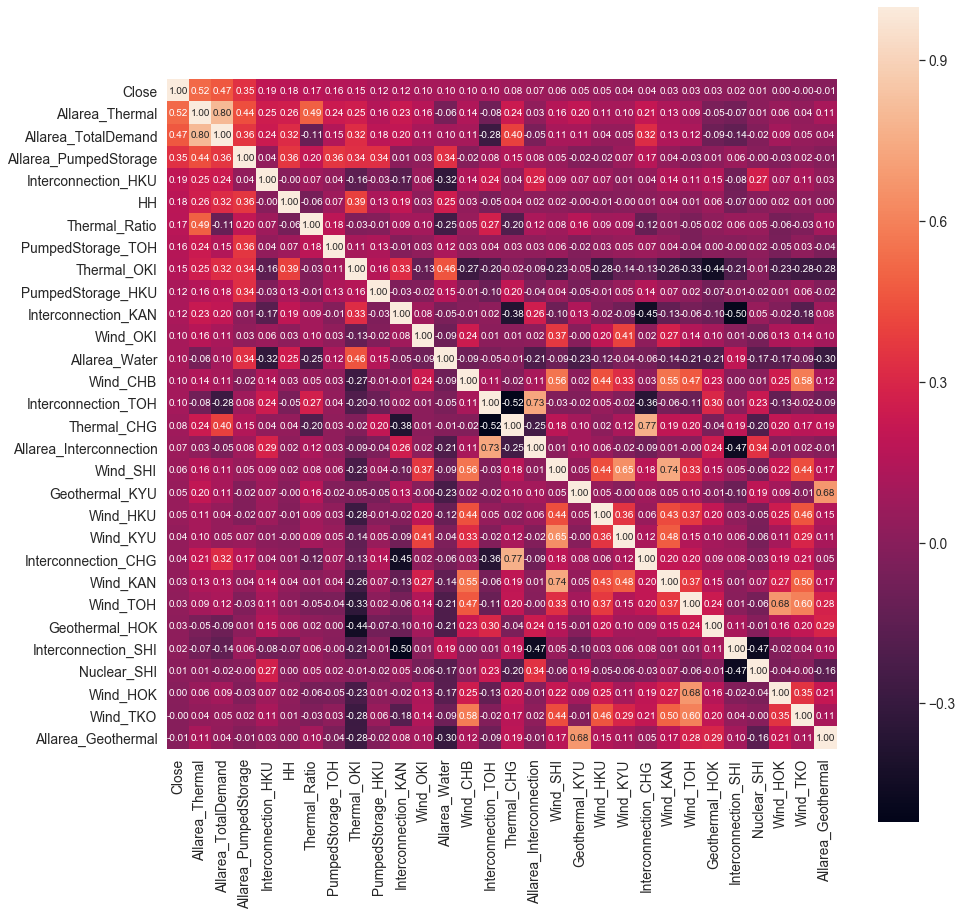

In [612]:
# # correlation matrix
# corrmat = Demand_AreaPlant_withClose.corr()

# # revenue correlation matrix
# k = 30 # The number of variables on the heatmap
# cols = corrmat.nlargest(k, 'Close')['Close'].index
# cm = np.corrcoef(Demand_AreaPlant_withClose[cols].values.T)
# f, ax = plt.subplots(figsize=(15, 15))
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

Drop the above data at the end of  "4 Make all_data" (外れ値除去で使うため)

## Depand peak for the next day (Only Tohoku) ※10エリア計のピークを拾えそう
http://occtonet.occto.or.jp/public/dfw/RP11/OCCTO/SD/LOGIN_login#

In [659]:
# Daily demand peak
df_DemandPeak = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/DemandPeak_forecast.csv', sep=',', header=0, encoding='shift_jis')

In [660]:
df_DemandPeak.head()

策定日        対象日付 対象エリア 最小総需要予想時刻  最小総需要予想（MW） 最大総需要予想時刻  最大総需要予想（MW）  \
0  2021/03/14  2021/03/15   北海道     01:00         3357     19:00         3999   
1  2021/03/14  2021/03/15    東北     01:00         8605     10:00        10501   
2  2021/03/14  2021/03/15    東京     02:00        24108     11:00        35494   
3  2021/03/14  2021/03/15    中部     02:00        11940     10:00        18566   
4  2021/03/14  2021/03/15    北陸     01:00         2871     10:00         3970   

   最大供給力予想（MW）  予想使用率  予想予備率  
0         4776   83.7   19.4  
1        12245   85.8   16.6  
2        49344   71.9   39.0  
3        21352   87.0   15.0  
4         4362   91.0    9.9

In [661]:
df_DemandPeak = df_DemandPeak.rename(columns={'策定日': 'PlanDate', '対象日付': 'Date', '対象エリア': 'Area',
                                  '最小総需要予想時刻': 'Time_Min', '最小総需要予想（MW）': 'Planned_Min(MW)', 
                                  '最大総需要予想時刻': 'Time_Max', '最大総需要予想（MW）': 'Planned_Max(MW)', 
                                  '最大供給力予想（MW）': 'Planned_Max_Capa(MW)', '予想使用率': 'Planned_usege(%)', '予想予備率': 'Planned_margin(%)'})

df_DemandPeak["Date"] = pd.to_datetime(df_DemandPeak["Date"])

df_DemandPeak = df_DemandPeak.set_index("Date")
df_DemandPeak = df_DemandPeak.sort_index(ascending=True)
df_DemandPeak = df_DemandPeak.reset_index()

10エリア計でのピークを拾う

In [662]:
df_DemandPeak_All = df_DemandPeak[df_DemandPeak["Area"] == "10エリア計"]

In [663]:
df_DemandPeak_All.head()

Date    PlanDate    Area Time_Min  Planned_Min(MW) Time_Max  \
0  2016-04-01  2016/03/31  10エリア計    02:00            81777    19:00   
23 2016-04-02  2016/04/01  10エリア計    24:00            82868    19:00   
35 2016-04-03  2016/04/02  10エリア計    07:00            74764    20:00   
47 2016-04-04  2016/04/03  10エリア計    02:00            74641    19:00   
59 2016-04-05  2016/04/04  10エリア計    02:00            75602    19:00   

    Planned_Max(MW)  Planned_Max_Capa(MW)  Planned_usege(%)  Planned_margin(%)  
0            109605                130861              83.8               19.4  
23            99047                117939              84.0               19.1  
35            94163                116575              80.8               23.8  
47           107828                129501              83.3               20.1  
59           107112                127231              84.2               18.8

Make max/min flag

In [664]:
df_DemandPeak_All["Planned_Min_flag"] = 1
df_DemandPeak_All["Planned_Max_flag"] = 9

In [665]:
# Make the min flag
df_DemandPeakMin_All = df_DemandPeak_All[["Date", "Time_Min", "Planned_Min_flag"]]
df_DemandPeakMin_All = df_DemandPeakMin_All.rename(columns={"Time_Min": "Time"})

df_DemandPeakMin_All["Time"] = df_DemandPeakMin_All["Time"].str.replace('24:00', '23:00')
df_DemandPeakMin_All["Date"] = pd.to_datetime(df_DemandPeakMin_All["Date"])
df_DemandPeakMin_All["Time"] = pd.to_datetime(df_DemandPeakMin_All["Time"]).dt.time

df_DemandPeakMin_All.head()

Date      Time  Planned_Min_flag
0  2016-04-01  02:00:00                 1
23 2016-04-02  23:00:00                 1
35 2016-04-03  07:00:00                 1
47 2016-04-04  02:00:00                 1
59 2016-04-05  02:00:00                 1

In [666]:
# Make the max flag
df_DemandPeakMax_All = df_DemandPeak_All[["Date", "Time_Max", "Planned_Max_flag"]]
df_DemandPeakMax_All = df_DemandPeakMax_All.rename(columns={"Time_Max": "Time"})

df_DemandPeakMax_All["Date"] = pd.to_datetime(df_DemandPeakMax_All["Date"])
df_DemandPeakMax_All["Time"] = pd.to_datetime(df_DemandPeakMax_All["Time"]).dt.time

df_DemandPeakMax_All.head()

Date      Time  Planned_Max_flag
0  2016-04-01  19:00:00                 9
23 2016-04-02  19:00:00                 9
35 2016-04-03  20:00:00                 9
47 2016-04-04  19:00:00                 9
59 2016-04-05  19:00:00                 9

Done

## Fit_actual_predicted ※頑張って全電力会社分集めてみる
北海道:https://www.hepco.co.jp/network/con_service/supply_overview/genecapacity/ <p>
    -->2020以降のみ
東北: https://nw.tohoku-epco.co.jp/consignment/fit/ <p>
    -->2020年10月以降ブランク<p>
東京: https://www.tepco.co.jp/forecast/html/fit_data-j.html <p>
中部: https://powergrid.chuden.co.jp/takuso_service/hatsuden_kouri/takuso_kyokyu/rule/tokureihatsuden/ <p>
北陸: http://www.rikuden.co.jp/nw_jyukyudata/tokurei1_jisseki.html <p>
関西(検索から):　https://search.kansai-td.co.jp/? ie=u&page=1&kw=FIT+%E5%AE%9F%E7%B8%BE&ref=https%3A%2F%2Fsearch.kansai-td.co.jp%2F%3Fkw%3DFIT%25E7%2589%25B9%25E4%25BE%258B%25E2%2591%25A0%26ie%3Du&temp=&rid=1372083532164688&cate[]=all&pdf=on&s_type=and&cpn=10&ord=p&tss=120x90 <p>
中国: https://www.energia.co.jp/nw/service/retailer/data/fit/ <p>
四国:　https://www.yonden.co.jp/nw/renewable_energy/data/value.html  <p>
九州:　https://www.kyuden.co.jp/td_service_wheeling_outline_index.html <p>
沖縄:　https://www.okiden.co.jp/business-support/service/consignment/imbalance-achievement/index.html

予測値は前日の6時に公表 (ラグなしで特徴量に組み込む)
https://www.occto.or.jp/oshirase/sonotaoshirase/2019/files/191220_FIT1unyohenko.pdf.pdf

従来予測値は前々日の公表だったが、2020年４月より前日公表に運用変更
https://www.occto.or.jp/oshirase/sonotaoshirase/2019/files/191220_FIT1unyohenko.pdf.pdf

## Other data

- The following data are avoided as features since they seems very low correlation based on "8. EDA(for all_data)"
- If I have more time and the performance of the model should be improved more, they are considered.

### Actual_generation(Tohoku_area)  ※Skip
https://setsuden.nw.tohoku-epco.co.jp/download.html

各電力会社の「でんき予報」から５分足データを集めて、30分足として使う
※再エネ情報があれば一旦含めておく

Timegrouperで5分値を３０分値へ
https://qiita.com/takechanman1228/items/00daec6a62f831f24e6d

In [667]:
#Actual generation_dataset from 2016-08-01
df_actual_generation_1 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/使うかわからない軍/Actual_generation_5min/Actual_generation1.csv', sep=',', header=0, encoding='shift_jis')

#Actual generation_dataset from 2020-04-14
df_actual_generation_2 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/使うかわからない軍/Actual_generation_5min/Actual_generation2.csv', sep=',', header=0, encoding='shift_jis')

In [668]:
df_actual_generation_Tohoku = pd.concat([df_actual_generation_1, df_actual_generation_2])
df_actual_generation_Tohoku = df_actual_generation_Tohoku.rename(columns={'DATE': 'Date', 'TIME': 'Time',
    '太陽光発電実績(5分間隔値)(万kW)': 'gen_Solar(mkW)', '当日実績(5分間隔値)(万kW)': 'gen_all(mkW)', '風力発電実績(5分間隔値)(万kW)': 'gen_Wind(mkW)'
})

df_actual_generation_Tohoku["gen_Solar(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["gen_all(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["gen_Wind(mkW)"].fillna(0, inplace=True)

df_actual_generation_Tohoku["DateTime"] = pd.to_datetime(df_actual_generation_Tohoku["Date"] + " " + df_actual_generation_Tohoku["Time"])
df_actual_generation_Tohoku = df_actual_generation_Tohoku.groupby(pd.Grouper(key="DateTime", freq='30min')).sum()

df_actual_generation_Tohoku.reset_index(inplace = True)

df_actual_generation_Tohoku["Time"] = pd.to_datetime(df_actual_generation_Tohoku["DateTime"]).dt.time
df_actual_generation_Tohoku["Date"] = pd.to_datetime(df_actual_generation_Tohoku["DateTime"]).dt.date
df_actual_generation_Tohoku["Date"] = pd.to_datetime(df_actual_generation_Tohoku["Date"])

df_actual_generation_Tohoku = df_actual_generation_Tohoku.drop("DateTime", axis=1)

In [669]:
print(df_actual_generation_Tohoku.isnull().sum())

gen_all(mkW)      0
gen_Solar(mkW)    0
gen_Wind(mkW)     0
Time              0
Date              0
dtype: int64


### Weather data (Tohoku area) ※Skip
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php


各電力会社所在地の天候データを集める(たしか７エリア
)

In [670]:
# #Read all the weather data in Tohoku area

# df_weather_Aomori = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Aomori.csv', sep=',', header=0, encoding='cp932')
# df_weather_Akita = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Akita.csv', sep=',', header=0, encoding='cp932')
# df_weather_Morioka = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Morioka.csv', sep=',', header=0, encoding='cp932')
# df_weather_Yamagata = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Yamagata.csv', sep=',', header=0, encoding='cp932')
# df_weather_Sendai = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Sendai.csv', sep=',', header=0, encoding='cp932')
# df_weather_Fukushima = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Fukushima.csv', sep=',', header=0, encoding='cp932')
# df_weather_Niigata = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/Weather/Weather_Niigata.csv', sep=',', header=0, encoding='cp932')

In [671]:
# # marge all the spot datasets
# df_weather_all = pd.merge(df_weather_Aomori, df_weather_Akita, how='left', on=['Date'])
# df_weather_all = pd.merge(df_weather_all, df_weather_Morioka, how='left', on=['Date'])
# df_weather_all = pd.merge(df_weather_all, df_weather_Yamagata, how='left', on=['Date'])
# df_weather_all = pd.merge(df_weather_all, df_weather_Sendai, how='left', on=['Date'])
# df_weather_all = pd.merge(df_weather_all, df_weather_Fukushima, how='left', on=['Date'])
# df_weather_all = pd.merge(df_weather_all, df_weather_Niigata, how='left', on=['Date'])
# print(df_weather_all.shape)

In [672]:
# #Drop the columns that are not necessary
# a = [item for item in df_weather_all.columns if item.find('Qual') != -1 or item.find('Num') != -1or item.find('None') != -1]
# df_weather_all = df_weather_all.drop(columns=a)

# # Replace/adjust the name of direction
# df_weather_all = df_weather_all.replace({'北西)': '北西', '南東)': '南東', '東南東)': '東南東', '南)': '南'})

# # Categolize direction
# df_weather_all = df_weather_all.replace({'静穏': '0', '北': '1', '北北東': '2', '北東': '3', 
#                                         '東北東': '4', '東': '5', '東南東': '6', '南東': '7', '南南東': '8', 
#                                         '南': '9', '南南西': '10', '南西': '11', '西南西': '12', 
#                                         '西': '13', '西北西': '14', '北西': '15', '北北西': '16'})

# df_weather_all["Time"] = pd.to_datetime(df_weather_all["Date"]).dt.time
# df_weather_all["Date"] = pd.to_datetime(df_weather_all["Date"]).dt.date
# df_weather_all["Date"] = pd.to_datetime(df_weather_all["Date"])

# cols = [item for item in df_weather_all.columns if item.find('WindDirection') != -1]
# df_weather_all[cols] = df_weather_all[cols].apply(pd.to_numeric)

準備OK　--> Mergeしてから30分時点の欠損値は直前の時間の情報を参照させる (もしくは直前の時間を参照してすべて２で割る)

In [673]:
# df_Temp = df_weather_all.iloc[:, df_weather_all.columns.str.contains("Temp")]
# df_SunLight_Time = df_weather_all.iloc[:, df_weather_all.columns.str.contains("SunLight" and "Time")].drop("Time", axis=1)
# df_SunLight_Volume = df_weather_all.iloc[:, df_weather_all.columns.str.contains("SunLight" and "MJ/㎡")]
# df_WindSpeed = df_weather_all.iloc[:, df_weather_all.columns.str.contains("WindSpeed")]
# df_WindDirection = df_weather_all.iloc[:, df_weather_all.columns.str.contains("WindDirection")]

In [674]:
# # correlation matrix
# corrmat = df_SunLight_Time.corr()
# f, ax = plt.subplots(figsize=(12,9))
# sns.heatmap(corrmat, square=True);

df_Temp: 相関高い -->　平均
df_SunLight_Time: 相関はバラけている
df_SunLight_Volume: 青森 と 仙台/福島が相関0.5程度と低め
df_WindSpeed: 相関低め
df_WindDirection 相関低め

### LNG price

日時データしかないため一旦保留

In [675]:
# LNGPrice = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/LNG_historical-data.csv', sep=',', header=0)
# LNGPrice.columns = ["Year", "Month", "Status", "ContractPrice(USD/MMBtu)", "Arrival Price(USD/MMBtu)", "Unnamed: 5"]
# LNGPrice["Date"] = pd.to_datetime(LNGPrice["Year"].astype(str) + "-" + LNGPrice["Month"].astype(str), format='%Y-%m')
# LNGPrice = LNGPrice.drop(["Year", "Month", "Unnamed: 5"], axis=1)
# LNGPrice = LNGPrice.replace({'確報': 'Confirmed', '速報': 'Quick', '×': '0'})
# LNGPrice["ContractPrice(USD/MMBtu)"] = LNGPrice["ContractPrice(USD/MMBtu)"].astype(float)
# LNGPrice["Arrival Price(USD/MMBtu)"] = LNGPrice["Arrival Price(USD/MMBtu)"].astype(float)
LNGPrice.tail()

Status  ContractPrice(USD/MMBtu)  Arrival Price(USD/MMBtu)       Date
79  Confirmed                       6.0                       4.9 2020-10-01
80  Confirmed                       6.8                       6.5 2020-11-01
81  Confirmed                       7.4                       6.8 2020-12-01
82  Confirmed                      18.5                      15.5 2021-01-01
83      Quick                      12.7                      16.3 2021-02-01

In [676]:
# #LNGPrice = LNGPrice.set_index("Date")
# LNGPrice["ContractPrice(USD/MMBtu)"].plot()
# LNGPrice["Arrival Price(USD/MMBtu)"].plot()
# plt.legend();

# Make all_data

## Merge all input data

In [677]:
# Adjust HH table ※原因はわからないが1から作るとワークしないので df_actual_generation_Tohokuから作成
HH_table = pd.DataFrame(df_intra_HH["HH"])
HH_table = HH_table.drop_duplicates()
time = df_actual_generation_Tohoku["Time"]
time = pd.DataFrame(time)
time = time.drop_duplicates()
HH_table["Time"] = time

In [678]:
all_data = df_intra

# HH_table
all_data = pd.merge(all_data, HH_table, how="left", on=['HH'])

# df_spot
all_data = pd.merge(all_data, df_spot, how="left", on=['Date', 'HH'])

#df_HourlyDemand_All
all_data = pd.merge(all_data, df_HourlyDemand_All, how="left", on=['Date', 'Time'])

# df_Demand_AreaPlant
all_data = pd.merge(all_data, df_Demand_AreaPlant, how="left", on=['Date', 'Time'])

#df_DemandPeakMin_All
all_data = pd.merge(all_data, df_DemandPeakMin_All, how="left", on=['Date', 'Time'])

#df_DemandPeakMax_All
all_data = pd.merge(all_data, df_DemandPeakMax_All, how="left", on=['Date', 'Time'])

# #df_weather_all
# all_data = pd.merge(all_data, df_weather_all, how="left", on=['Date','Time'])

# #df_actual_generation_Tohoku
# all_data = pd.merge(all_data, df_actual_generation_Tohoku, how="left", on=['Date', 'Time'])

all_data.head()

Date  HH  Open  High   Low  Close  Average  Volume(MWh/h)  \
0 2016-04-01   1  7.69  7.69  7.69   7.69     7.69            0.7   
1 2016-04-01   2   NaN   NaN   NaN    NaN      NaN            NaN   
2 2016-04-01   3  7.21  7.21  7.21   7.21     7.21            0.8   
3 2016-04-01   4  7.06  7.06  7.06   7.06     7.06            0.8   
4 2016-04-01   5  7.21  7.21  7.21   7.21     7.21            0.8   

   Volume(Tick count)      Time  Sell_volume(kWh)  Buy_volume(kWh)  \
0                   1  00:00:00           5077000          2120500   
1                   0  00:30:00           5621500          2239000   
2                   1  01:00:00           5710500          2219000   
3                   1  01:30:00           5536000          2202500   
4                   1  02:00:00           5461000          2192000   

   Total_volume(kWh)  System_price(Yen/kWh)  Price_Hokkaido(Yen/kWh)  \
0             675500                   6.61                     8.66   
1             755500                   6.34                     8.66   
2             713500                   6.34                     7.20   
3             717500                   6.25                     7.10   
4             870500                   6.57                     7.10   

   Price_Tokyo(Yen/kWh)  Price_Kansai(Yen/kWh)  BidExceed_diff  \
0                  6.69                   6.69               0   
1                  6.34                   6.34               0   
2                  6.34                   6.34               0   
3                  6.03                   6.03               0   
4                  6.57                   6.57               0   

   HourlyDemand_Hokkaido  HourlyDemand_Tohoku  HourlyDemand_Tokyo  \
0                 3166.0               7887.0             25547.0   
1                    NaN                  NaN                 NaN   
2                 3282.0               8158.0             24334.0   
3                    NaN                  NaN                 NaN   
4                 3387.0               8420.0             23934.0   

   HourlyDemand_Chubu  HourlyDemand_Hokuriku  HourlyDemand_Kansai  \
0             12372.0                 2935.0            12917.964   
1                 NaN                    NaN                  NaN   
2             12129.0                 3076.0            12835.368   
3                 NaN                    NaN                  NaN   
4             12273.0                 3270.0            13351.128   

   HourlyDemand_Chugoku  HourlyDemand_Shikoku  HourlyDemand_Kyushu  \
0              5813.828                2552.0             8017.462   
1                   NaN                   NaN                  NaN   
2              5995.674                2724.0             8177.531   
3                   NaN                   NaN                  NaN   
4              6402.637                2982.0             8709.662   

   HourlyDemand_Okinawa  TotalDemand_TOH  Water_TOH  Thermal_TOH  PV_TOH  \
0                 644.7           7887.0     1812.0       8072.0     0.0   
1                   NaN              NaN        NaN          NaN     NaN   
2                 625.9           8158.0     1831.0       8299.0     0.0   
3                   NaN              NaN        NaN          NaN     NaN   
4                 639.6           8420.0     1876.0       8514.0     0.0   

   Wind_TOH  Geothermal_TOH  Biomass_TOH  PumpedStorage_TOH  \
0      46.0           116.0         41.0                0.0   
1       NaN             NaN          NaN                NaN   
2      50.0           116.0         40.0                0.0   
3       NaN             NaN          NaN                NaN   
4      48.0           115.0         38.0                0.0   

   Interconnection_TOH  TotalDemand_HOK  Thermal_HOK  Water_HOK  \
0              -2200.0           3166.0       2573.0      474.0   
1                  NaN              NaN          NaN        NaN   
2              -2178.0           3282.0       2640.0  

In [1086]:
all_data.shape

(83237, 82)

In [1085]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Data columns (total 82 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     83237 non-null  datetime64[ns]
 1   HH                       83237 non-null  int64         
 2   Open                     83237 non-null  float64       
 3   High                     83237 non-null  float64       
 4   Low                      83237 non-null  float64       
 5   Close                    83237 non-null  float64       
 6   Average                  83237 non-null  float64       
 7   Volume(MWh/h)            83237 non-null  float64       
 8   Volume(Tick count)       83237 non-null  int64         
 9   Time                     83237 non-null  object        
 10  Sell_volume(kWh)         83237 non-null  int64         
 11  Buy_volume(kWh)          83237 non-null  int64         
 12  Total_volume(kWh)        83237 n

In [679]:
print(all_data.isnull().sum())

Date                           0
HH                             0
Open                          72
High                          72
Low                           72
Close                         72
Average                       72
Volume(MWh/h)                 72
Volume(Tick count)             0
Time                           0
Sell_volume(kWh)               0
Buy_volume(kWh)                0
Total_volume(kWh)              0
System_price(Yen/kWh)          0
Price_Hokkaido(Yen/kWh)      960
Price_Tokyo(Yen/kWh)           0
Price_Kansai(Yen/kWh)          0
BidExceed_diff                 0
HourlyDemand_Hokkaido      42161
HourlyDemand_Tohoku        42161
HourlyDemand_Tokyo         42161
HourlyDemand_Chubu         42161
HourlyDemand_Hokuriku      42161
HourlyDemand_Kansai        42161
HourlyDemand_Chugoku       42161
HourlyDemand_Shikoku       42161
HourlyDemand_Kyushu        42161
HourlyDemand_Okinawa       42161
TotalDemand_TOH            42617
Water_TOH                  42617
Thermal_TO

- 基本全部見直し！！

①先にこちらを処理
Generation --> 2016年4月〜2016年7月が欠損。0にて補完 <p>
フラグ --> フラグ以外は欠損のため0で埋める <p>
    
②残りはまとめて処理 <p>
Price data --> データ欠損であるが連続性を保持するため直前参照 <p>
Weather --> 30分値欠損のため直前参照 <p>
需要電力量 --> 30分値欠損のため直前参照　+ 20204Qデータ未入手<p>

In [680]:
# Fillna with 0 and flag
all_data["Planned_Min_flag"].fillna(0, inplace=True)
all_data["Planned_Max_flag"].fillna(0, inplace=True)

In [681]:
# Fillna with the average between the previous and later slots for Price, Demand
all_data.interpolate(method='linear', inplace=True)

In [682]:
print(all_data.isnull().sum())

Date                       0
HH                         0
Open                       0
High                       0
Low                        0
Close                      0
Average                    0
Volume(MWh/h)              0
Volume(Tick count)         0
Time                       0
Sell_volume(kWh)           0
Buy_volume(kWh)            0
Total_volume(kWh)          0
System_price(Yen/kWh)      0
Price_Hokkaido(Yen/kWh)    0
Price_Tokyo(Yen/kWh)       0
Price_Kansai(Yen/kWh)      0
BidExceed_diff             0
HourlyDemand_Hokkaido      0
HourlyDemand_Tohoku        0
HourlyDemand_Tokyo         0
HourlyDemand_Chubu         0
HourlyDemand_Hokuriku      0
HourlyDemand_Kansai        0
HourlyDemand_Chugoku       0
HourlyDemand_Shikoku       0
HourlyDemand_Kyushu        0
HourlyDemand_Okinawa       0
TotalDemand_TOH            0
Water_TOH                  0
Thermal_TOH                0
PV_TOH                     0
Wind_TOH                   0
Geothermal_TOH             0
Biomass_TOH   

In [683]:
# Create a column for "date block num"
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data["date_block_num"] = np.trunc(all_data['Date'].map(pd.Timestamp.timestamp).astype(int) / 86400 - 16891)

※ Filter all_data from 2016-04-01 to 2020-12-31

In [684]:
all_data = all_data[all_data["Date"] <= "2020-12-31"]

In [685]:
all_data['month'] = pd.to_datetime(all_data["Date"]).dt.month

In [686]:
# From Monday:0 to Sunday:6
all_data['dayofweek'] = pd.to_datetime(all_data["Date"]).dt.dayofweek

In [687]:
# Check the national holiday in Japan
len(jpholiday.between(datetime.date(2016, 4, 1), datetime.date(2020, 12, 31)))

89

In [688]:
# Add the national holidays in all_data
import jpholiday

Date_list = list(all_data["Date"])
DayofWeek_list = list(all_data["dayofweek"])
holiday_judge = []

for d, dw in zip(Date_list, DayofWeek_list):
    # For holiday
    if jpholiday.is_holiday(datetime.date(d.year, d.month, d.day)) == "True":
        holiday_judge.append(1)
   # For Sunday and Satarday
    elif dw >= 5:
        holiday_judge.append(1)
    else:
        holiday_judge.append(0)

all_data["holiday"] = pd.Series(holiday_judge)            

Look at the outlier

In [689]:
# # scatterplot
# sns.set()
# cols = ['Close', 'System_price(Yen/kWh)', 'Allarea_TotalDemand', 'TotalDemand_HOK','Interconnection_HOK']
# sns.pairplot(all_data[cols], size=2.5)
# plt.show()

In [690]:
all_data.shape

(83328, 133)

In [691]:
all_data[all_data["Close"] > 120]

Date  HH   Open   High    Low  Close  Average  Volume(MWh/h)  \
76977 2020-08-21  34  53.96  160.0  45.01  150.0    93.48          561.4   
76978 2020-08-21  35  32.07  135.0  27.89  135.0    74.70          449.2   
76979 2020-08-21  36  31.97  135.0  27.00  135.0    64.57          480.0   

       Volume(Tick count)      Time  Sell_volume(kWh)  Buy_volume(kWh)  \
76977                 106  16:30:00          23670500         30567500   
76978                  92  17:00:00          23851050         29489350   
76979                  86  17:30:00          23676300         28749900   

       Total_volume(kWh)  System_price(Yen/kWh)  Price_Hokkaido(Yen/kWh)  \
76977           23421800                  47.04                    45.01   
76978           23602350                  28.07                    30.00   
76979           23417650                  20.78                    28.07   

       Price_Tokyo(Yen/kWh)  Price_Kansai(Yen/kWh)  BidExceed_diff  \
76977                 49.99                  49.99               0   
76978                 30.00                  30.00               0   
76979                 28.07                  28.07               0   

       HourlyDemand_Hokkaido  HourlyDemand_Tohoku  HourlyDemand_Tokyo  \
76977                 3520.5              12012.5             53497.0   
76978                 3477.0              11554.0             51919.0   
76979                 3492.0              11384.5             50738.0   

       HourlyDemand_Chubu  HourlyDemand_Hokuriku  HourlyDemand_Kansai  \
76977             23245.5                4493.30            27069.606   
76978             22214.0                4333.50            25995.296   
76979             21676.0                4225.85            25327.925   

       HourlyDemand_Chugoku  HourlyDemand_Shikoku  HourlyDemand_Kyushu  \
76977            10200.9625                5003.0              15241.5   
76978             9855.5680                4853.0              14857.0   
76979             9577.9690                4754.0              14520.5   

       HourlyDemand_Okinawa  TotalDemand_TOH  Water_TOH  Thermal_TOH  PV_TOH  \
76977               1493.35          12012.5     1821.5      14341.0   561.5   
76978               1458.20          11554.0     1842.0      14134.0   227.0   
76979               1426.15          11384.5     1851.0      13848.5   114.5   

       Wind_TOH  Geothermal_TOH  Biomass_TOH  PumpedStorage_TOH  \
76977      25.0           131.0        391.0                0.0   
76978      24.0           132.0        394.0                0.0   
76979      21.0           132.0        397.5                0.0   

       Interconnection_TOH  TotalDemand_HOK  Thermal_HOK  Water_HOK  \
76977              -5258.5           3520.5       3030.0      560.0   
76978              -5199.0           3477.0       3012.0      585.0   
76979              -4980.0           3492.0       3017.0      590.0   

       Geothermal_HOK  Biomass_HOK  PV_HOK  Wind_HOK  PumpedStorage_HOK  \
76977            14.5         23.0   126.5      25.5              283.5   
76978            14.0         23.0    49.0      25.0              296.0   
76979            14.0         23.0    24.5      25.5              324.5   

       Interconnection_HOK  TotalDemand_TKO  Thermal_TKO  Water_TKO  \
76977               -543.0           5350.0       3609.0      282.5   
76978               -528.0           5192.0       3615.0      284.0   
76979               -527.5           5074.0       3620.5      284.0   

       Biomass_TKO  PV_TKO  Wind_TKO  PumpedStorage_TKO  Interconnection_TKO  \
76977         33.0   166.0       3.5              685.0                571.0   
76978         33.0    74.0       4.0              665.0                517.0   
76979         33.0    37.5       4.0              581.5                513.5   

       TotalDemand_CHB  Thermal_CHB  Water_CHB  PV_CHB  Wind_CHB  \
76977          23245.5      19185.5     1611.5   973.0       4.5   
76978          22214.0 

In [692]:
all_data[all_data["TotalDemand_HOK"] < 2200]

Date  HH   Open   High    Low  Close  Average  Volume(MWh/h)  \
42629 2018-09-06   6  10.37  16.10   2.80   6.16    10.71          147.4   
42630 2018-09-06   7   7.20  16.30   2.90   9.68    10.88          144.4   
42631 2018-09-06   8  10.35  16.30   2.90   7.08    10.67          151.1   
42632 2018-09-06   9  10.30  12.65   3.10   6.52     8.80          257.2   
42633 2018-09-06  10  10.33  12.73   3.10  11.22     8.09          335.3   
42634 2018-09-06  11  10.83  13.16   3.20   8.68     8.08          334.0   
42635 2018-09-06  12  10.35  13.16   3.40   8.80    10.91          142.8   
42636 2018-09-06  13  10.95  13.20   3.40   8.75    10.50          160.2   
42637 2018-09-06  14  10.30  13.16   4.50   9.83    10.88          136.9   
42638 2018-09-06  15  10.09  12.59   4.50   8.30    10.53          132.9   
42639 2018-09-06  16  10.39  11.78   4.50   8.65     8.20           36.8   
42640 2018-09-06  17   7.12  20.01   5.32   7.32     7.77           41.4   
42641 2018-09-06  18  11.97  15.50   6.43   6.51     7.89          220.7   
42642 2018-09-06  19  10.49  20.00   6.51  10.55     8.67          189.5   
42643 2018-09-06  20  10.84  15.50   6.18  10.94     9.86          286.4   
42644 2018-09-06  21  10.80  13.58   6.51   8.90     8.11          286.2   
42645 2018-09-06  22  11.00  13.46   6.22  12.50     7.99          357.3   
42646 2018-09-06  23  11.59  13.46   6.22  13.23     8.68          518.0   
42647 2018-09-06  24  11.30  14.28   6.24  14.28     8.88          422.6   
42648 2018-09-06  25  10.90  13.68   3.50  13.68     8.65          263.6   
42649 2018-09-06  26  10.88  13.79   6.25   7.75     8.66          197.0   
42650 2018-09-06  27  12.67  17.13   6.80  11.40     9.36          504.5   
42651 2018-09-06  28  13.66  17.93   6.51  12.51    10.11          441.7   
42652 2018-09-06  29  12.62  19.70   7.62  12.62    12.79          634.1   
42653 2018-09-06  30  18.00  25.10   8.15  15.38    14.39          694.8   
42654 2018-09-06  31  19.07  20.00   8.15  12.37    13.40          294.7   
42655 2018-09-06  32  15.00  23.04  10.10  13.00    17.71          484.7   
42656 2018-09-06  33  20.00  32.88   8.69  18.00    19.80         1301.9   
42657 2018-09-06  34  30.00  32.88  11.72  11.72    21.34         1132.0   
42658 2018-09-06  35  24.00  24.24   9.77  16.56    17.12          626.4   
42659 2018-09-06  36  20.00  23.04   8.17  15.00    14.96          498.9   
42660 2018-09-06  37  22.00  23.04  10.10  16.56    15.74          540.8   
42661 2018-09-06  38  21.02  21.02   9.16  13.82    14.43          303.4   
42662 2018-09-06  39  15.21  20.01   8.97  13.21    13.74          155.8   
42663 2018-09-06  40  14.90  20.01  10.63  11.07    12.70          117.0   
42664 2018-09-06  41  14.50  20.01   9.41  10.91    10.73          360.9   
42665 2018-09-06  42  15.87  20.00   8.47  12.75    10.27          337.7   
42666 2018-09-06  43  11.55  20.01   6.52   8.16     9.34          603.1   
42667 2018-09-06  44  11.23  20.00   6.52   6.74     8.28          514.3   
42668 2018-09-06  45  13.47  20.00   6.27   6.95     8.85          375.8   
42669 2018-09-06  46  12.67  20.00   6.52   6.88     8.88          332.8   
42670 2018-09-06  47  11.23  20.00   6.36   6.80     8.52          423.9   
42671 2018-09-06  48  10.82  17.00   4.40   7.02     7.03          427.7   
42672 2018-09-07   1  10.73  10.73   3.50   9.21     6.47          334.7   
42673 2018-09-07   2   7.11  10.45   3.10   6.15     6.70          282.4   
42674 2018-09-07   3  10.39  10.39   3.10   8.05     6.38          310.8   
42675 2018-09-07   4  10.29  10.29   3.00   8.03     6.39          321.3   
42676 2018-09-07   5  10.26  10.26   3.00   8.03     6.37          269.0   
42677 2018-09-07   6   6.94  10.17   3.00   6.18     6.35          301.5   
42678 2018-09-07   7   7.11   9.74   3.10   8.44     7.02          412.8   
42679 2018-09-07   8   7.13   9.60   3.20   8.12     6.95          413.0   
42680 2018-09-07   9   7.11   9.63   3.10   8.34     7.02   

- These price spikes cannot be reasonable based on the features prepared. -->Remove the rows
- The black out in Hokkaido area on Sep 2018 -->Remove the rows <p>
    -->(Reference) https://www.denkishimbun.com/sp/33180

In [693]:
# Remove the price spikes 
all_data = all_data[all_data["Close"] < 120]
# Remove the black out in Hokkaido area 
all_data = all_data[all_data["TotalDemand_HOK"] > 2200]
all_data = all_data.reset_index(drop=True)

In [694]:
# Drop features that have high correlation with each other as much as possible
all_data = all_data.drop([
                                            "TotalDemand_TOH", "TotalDemand_CHB", "TotalDemand_CHG", "TotalDemand_SHI", 
                                            "TotalDemand_KYU", "TotalDemand_HKU", "TotalDemand_TKO","TotalDemand_KAN","TotalDemand_OKI", "TotalDemand_HOK",
                                            "Thermal_CHB", "Thermal_TKO", "Thermal_KAN", "Thermal_TOH", "Thermal_KYU", "Thermal_HKU", "Thermal_SHI", "Thermal_HOK",
                                            "PumpedStorage_TKO", "PumpedStorage_KAN", "PumpedStorage_SHI", "PumpedStorage_KYU", "PumpedStorage_CHG", 
                                            "PumpedStorage_HOK", "PumpedStorage_CHB", "Water_KAN", "Water_CHB", "Water_HOK", "Water_OKI", "Water_TKO",
                                            "Water_HOK", "Water_KYU", "Water_TOH", "Water_SHI", "Water_HKU", "PV_TKO", "PV_SHI", "PV_KAN", "PV_CHB", 
                                            "PV_TKO", "PV_HKU", "PV_HOK", "PV_TOH", "PV_CHG", "Allarea_WindCurtailment", "Allarea_PV", "Allarea_PVCurtailment", "Biomass_CHG",
                                            "Biomass_HKU", "Biomass_SHI", "Biomass_HOK", "Biomass_TKO", "Biomass_KYU", "Biomass_HKU", "Biomass_TOH", "PV_OKI", 
                                            "Allarea_Nuclear", "Allarea_Wind"
                                            ], axis=1)

In [695]:
all_data.shape

(83237, 78)

In [696]:
all_data.to_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/all_data.csv', index=False)

# Data leakage(Predictionポイントは前日の24:00とする)

ただし、daylag1の場合とdaylag2の場合で予測精度を比較しておく

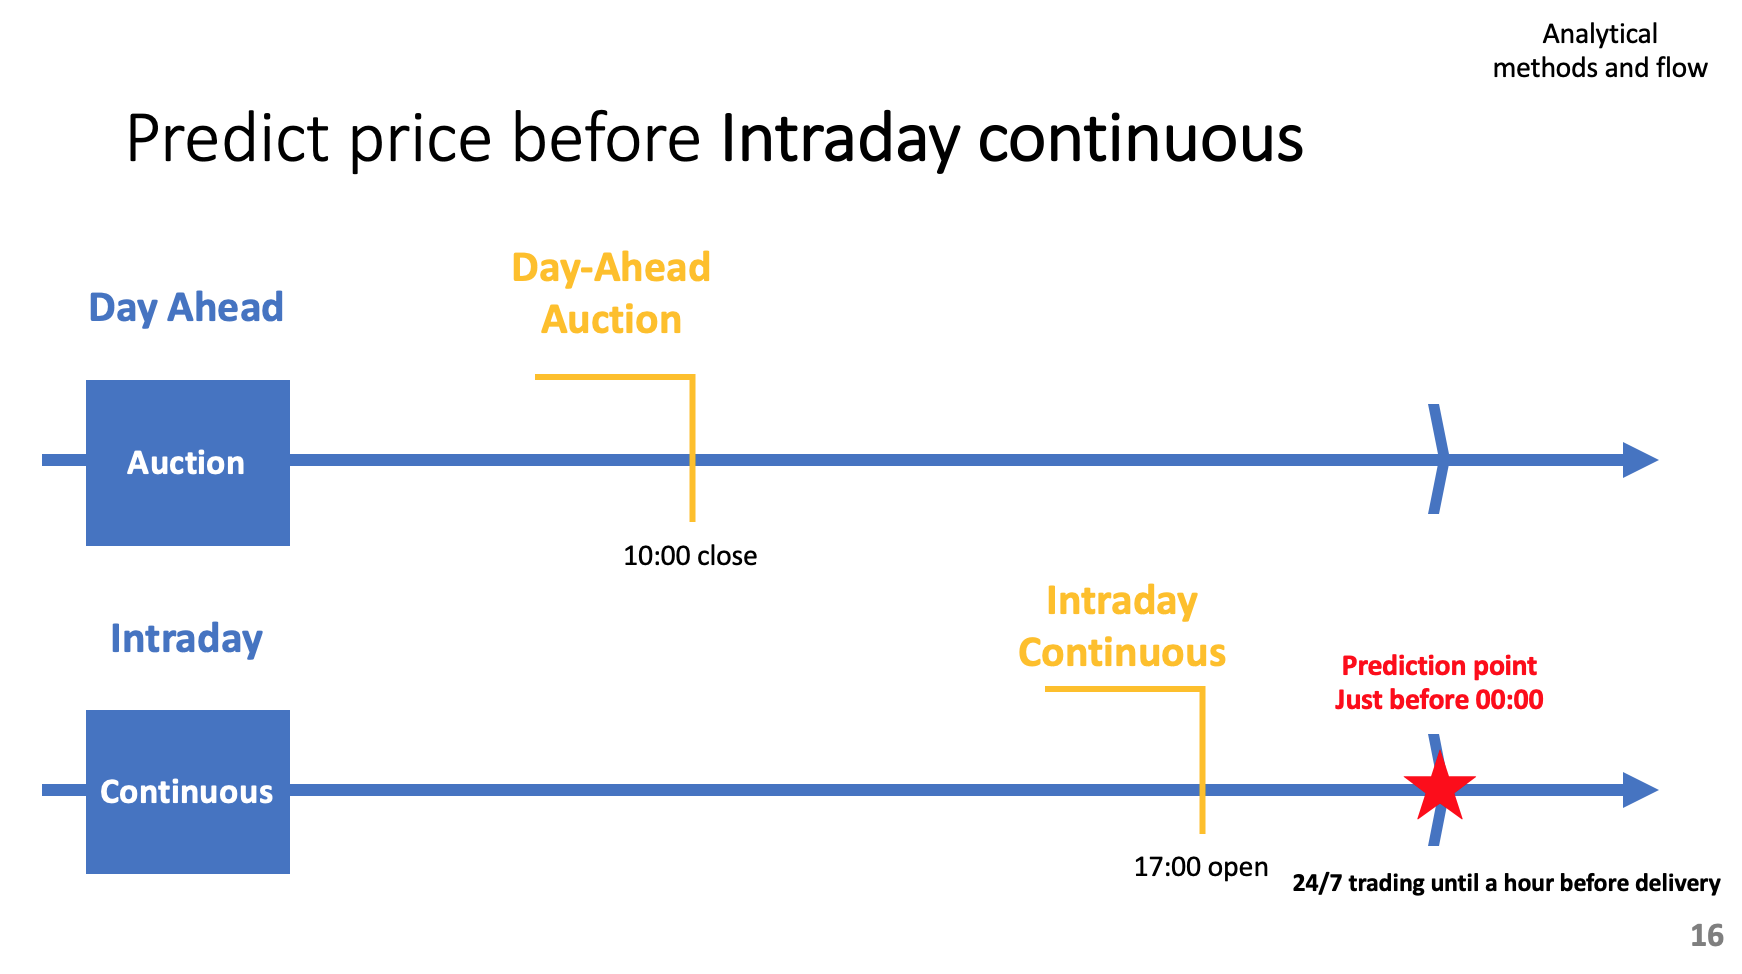

予測時点でどの特徴量が存在しうるか整理する

- Close priceは外す (Target) 
- Spot_price & volume: そのまま(Spot価格確定後の予測)
- 電力需要ピーク情報: そのまま（翌日予測）
- その他: <p>
    ※本来は block_date_numを2日分ずらす必要がある<p>
        ※ここでの論点はIntraday開始直後に取引される17:00から24:00までのアイテムが１日ずらしではつかえないということ。つまり、17:00-24:00を勘案すると2日ずらす必要がある。(今後調整するかも) <p>
    --> もし１日ずらしであれば0:00〜1:00あたりの取引が不利になる可能性有り　--> 1daylagと2daylagの予測精度を見てみて、改善が見られれば予測精度を取るべき(17:00~24:00のアイテムの深夜取引は限定的と仮定する)
    ①block_date_numを１日もしくは２日ずらす
    その上で更に、直前のスロットの情報は相関が高いので<p>
    ② HHを1スロット分ずらす <p>
    ③ その他はseasonality検証後に必要に応じて追加 <p>
    ④ lag_feature生成後元の特徴量は全て削除 <p>

# Feature Engineering

## Moving average/VWAP

[Moving average only for System price]

In [697]:
# Moving average for System price (Do not need lag) 1month, 3month, 1year
all_data["Spot_MA25d"] = all_data["System_price(Yen/kWh)"].rolling(1200).mean().round(2)
all_data["Spot_MA75d"] = all_data["System_price(Yen/kWh)"].rolling(3600).mean().round(2)
all_data["Spot_MA200d"] = all_data["System_price(Yen/kWh)"].rolling(9600).mean().round(2)

[VWAP]

(Reference)
MWh/hについて：https://www.jstage.jst.go.jp/article/ieejpes/127/4/127_4_573/_pdf/-char/ja

In [698]:
# Adjust unit from MWh to kWh
all_data['Volume_kWh'] = (all_data['Volume(MWh/h)']/2)*1000
all_data['Cum_Vol'] = all_data['Volume_kWh'].cumsum()
all_data['Cum_Vol_Price'] = (all_data['Volume_kWh'] * all_data['Average'] ).cumsum()
all_data['VWAP'] = all_data['Cum_Vol_Price'] / all_data['Cum_Vol']
all_data = all_data.drop(["Volume_kWh", "Cum_Vol", "Cum_Vol_Price"], axis=1)

In [699]:
all_data = all_data.fillna(0)
all_data.isnull().sum()

Date                       0
HH                         0
Open                       0
High                       0
Low                        0
Close                      0
Average                    0
Volume(MWh/h)              0
Volume(Tick count)         0
Time                       0
Sell_volume(kWh)           0
Buy_volume(kWh)            0
Total_volume(kWh)          0
System_price(Yen/kWh)      0
Price_Hokkaido(Yen/kWh)    0
Price_Tokyo(Yen/kWh)       0
Price_Kansai(Yen/kWh)      0
BidExceed_diff             0
HourlyDemand_Hokkaido      0
HourlyDemand_Tohoku        0
HourlyDemand_Tokyo         0
HourlyDemand_Chubu         0
HourlyDemand_Hokuriku      0
HourlyDemand_Kansai        0
HourlyDemand_Chugoku       0
HourlyDemand_Shikoku       0
HourlyDemand_Kyushu        0
HourlyDemand_Okinawa       0
Wind_TOH                   0
Geothermal_TOH             0
PumpedStorage_TOH          0
Interconnection_TOH        0
Geothermal_HOK             0
Wind_HOK                   0
Interconnectio

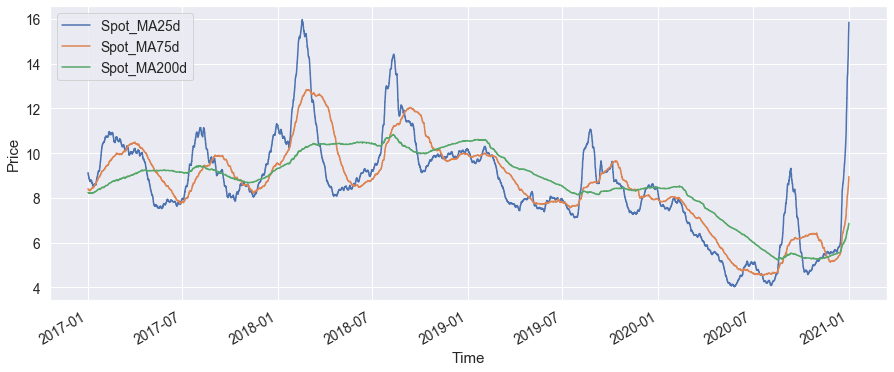

In [700]:
# plot the moving average
fig, ax = plt.subplots(1, figsize=(15, 6))

graph = all_data.copy()
graph["DateTime"] = pd.to_datetime(graph["Date"].astype(str) + " " + graph["Time"].astype(str))

# Set index
graph = graph.set_index("DateTime")
start = "2017-01-01 00:00:00"
end = "2020-12-31 23:30:00"

# Plot Close 
graph.Spot_MA25d [graph.index > start].plot(ax=ax, label="Spot_MA25d ")
graph.Spot_MA75d[graph.index > start].plot(ax=ax, label="Spot_MA75d")
graph.Spot_MA200d[graph.index > start].plot(ax=ax, label="Spot_MA200d")

# x-axis
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Price")
plt.legend(loc="upper left");

## Lag-features (Avoiding data leakage)

※Infinity value will be happen with Downcast preprocessing. ("Total" column)

In [702]:
# Check the remaining memory on PC
import gc
gc.collect()

3666

※ ラグ特徴量が必要ないものは外す
-->Closeラグ特徴量を生成し、元データとラグ特徴量の両方を残す

In [703]:
# This is for generating lag
def generate_lag(train, lag_sizes, cols, lag_sizes_type):

    lag_sizes = np.array(lag_sizes)
    if lag_sizes_type == "HH":
        lag_sizes_adj = lag_sizes * 1 # nothing changes
    elif lag_sizes_type == "Hours":
        lag_sizes_adj = lag_sizes * 2
    elif lag_sizes_type == "Day":
        lag_sizes_adj = lag_sizes * 48

    for ix, lag_sizes_adj_ in enumerate(lag_sizes_adj):
        shifted_df = all_data[cols].shift(lag_sizes_adj_)
        shifted_df.columns = [f"{col_name}_lag_{lag_sizes[ix]}_{lag_sizes_type}" for col_name in shifted_df.columns]
        if ix == 0:
            shifted_df_return = shifted_df
        else:
            shifted_df_return = shifted_df_return.merge(shifted_df, how="left", left_index=True, right_index=True)
    return shifted_df_return

In [704]:
all_data.columns

Index(['Date', 'HH', 'Open', 'High', 'Low', 'Close', 'Average',
       'Volume(MWh/h)', 'Volume(Tick count)', 'Time', 'Sell_volume(kWh)',
       'Buy_volume(kWh)', 'Total_volume(kWh)', 'System_price(Yen/kWh)',
       'Price_Hokkaido(Yen/kWh)', 'Price_Tokyo(Yen/kWh)',
       'Price_Kansai(Yen/kWh)', 'BidExceed_diff', 'HourlyDemand_Hokkaido',
       'HourlyDemand_Tohoku', 'HourlyDemand_Tokyo', 'HourlyDemand_Chubu',
       'HourlyDemand_Hokuriku', 'HourlyDemand_Kansai', 'HourlyDemand_Chugoku',
       'HourlyDemand_Shikoku', 'HourlyDemand_Kyushu', 'HourlyDemand_Okinawa',
       'Wind_TOH', 'Geothermal_TOH', 'PumpedStorage_TOH',
       'Interconnection_TOH', 'Geothermal_HOK', 'Wind_HOK',
       'Interconnection_HOK', 'Wind_TKO', 'Interconnection_TKO', 'Wind_CHB',
       'Interconnection_CHB', 'Wind_HKU', 'PumpedStorage_HKU',
       'Interconnection_HKU', 'Nuclear_KAN', 'Wind_KAN', 'Interconnection_KAN',
       'Thermal_CHG', 'Water_CHG', 'Wind_CHG', 'Interconnection_CHG',
       'Nuclear_SH

In [709]:
# Drop columns that are not necessary to generate lag features
lag_columns = all_data.columns.drop(['Date', 'Time', 'HH', 'Close', 'Sell_volume(kWh)', 'Buy_volume(kWh)',
       'Total_volume(kWh)', 'System_price(Yen/kWh)', 'Price_Hokkaido(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 
       'Price_Kansai(Yen/kWh)', 'BidExceed_diff', 'Planned_Min_flag', 'Planned_Max_flag', 'date_block_num', 'month', 
       'dayofweek', 'holiday', 'Spot_MA25d', 'Spot_MA75d', 'Spot_MA200d'])

# Generate lag features and drop original columns
# all_data_lagged_HH = generate_lag(all_data, [49, 97], lag_columns, "HH")
# all_data_lagged_Hour = generate_lag(all_data, [2], lag_columns, "Hours")
all_data_lagged_Day = generate_lag(all_data, [1, 2], lag_columns, "Day")

# join everything
# all_data_lagged = pd.merge(all_data, all_data_lagged_HH, how="left", left_index=True, right_index=True)
# all_data = pd.merge(all_data, all_data_lagged_Hour, how="left", left_index=True, right_index=True)
all_data_lagged = pd.merge(all_data, all_data_lagged_Day, how="left", left_index=True, right_index=True)

# Drop lag_columns which can be data leakage
all_data_lagged = all_data_lagged.drop(lag_columns, axis=1)

In [710]:
# Check the lag columns
# temp_col = [item for item in all_data.columns if item.find('Day') != -1]

# print(temp_col)

NaN was generated only on 96 (48 * 2) timeslots on the firstday 2016/04/01　and 2016/04/02 --> OK 

In [711]:
all_data_lagged.shape

(83237, 143)

In [712]:
all_data_lagged.fillna(0, inplace=True)
print(all_data_lagged.isnull().sum())

Date                                 0
HH                                   0
Close                                0
Time                                 0
Sell_volume(kWh)                     0
Buy_volume(kWh)                      0
Total_volume(kWh)                    0
System_price(Yen/kWh)                0
Price_Hokkaido(Yen/kWh)              0
Price_Tokyo(Yen/kWh)                 0
Price_Kansai(Yen/kWh)                0
BidExceed_diff                       0
Planned_Min_flag                     0
Planned_Max_flag                     0
date_block_num                       0
month                                0
dayofweek                            0
holiday                              0
Spot_MA25d                           0
Spot_MA75d                           0
Spot_MA200d                          0
Open_lag_1_Day                       0
High_lag_1_Day                       0
Low_lag_1_Day                        0
Average_lag_1_Day                    0
Volume(MWh/h)_lag_1_Day  

In [713]:
all_data_lagged.tail()

Date  HH  Close      Time  Sell_volume(kWh)  Buy_volume(kWh)  \
83232 2020-12-31  44  70.00  21:30:00          16913450         22563500   
83233 2020-12-31  45  45.48  22:00:00          16406450         22394500   
83234 2020-12-31  46  41.33  22:30:00          16501300         21888250   
83235 2020-12-31  47  36.66  23:00:00          16224050         21729250   
83236 2020-12-31  48  26.46  23:30:00          16207050         21202500   

       Total_volume(kWh)  System_price(Yen/kWh)  Price_Hokkaido(Yen/kWh)  \
83232           16910000                   35.0                     35.0   
83233           16403600                   45.0                     40.0   
83234           16497800                   40.0                     40.0   
83235           16219200                   35.0                     35.0   
83236           16200350                   25.0                     25.0   

       Price_Tokyo(Yen/kWh)  Price_Kansai(Yen/kWh)  BidExceed_diff  \
83232                  35.0                   50.0               0   
83233                  40.0                   50.0               0   
83234                  40.0                   40.0               0   
83235                  35.0                   35.0               0   
83236                  25.0                   25.0               0   

       Planned_Min_flag  Planned_Max_flag  date_block_num  month  dayofweek  \
83232               0.0               0.0          1736.0     12          3   
83233               0.0               0.0          1736.0     12          3   
83234               0.0               0.0          1736.0     12          3   
83235               0.0               0.0          1736.0     12          3   
83236               0.0               0.0          1736.0     12          3   

       holiday  Spot_MA25d  Spot_MA75d  Spot_MA200d  Open_lag_1_Day  \
83232        0       15.75        8.91         6.85           50.00   
83233        0       15.78        8.92         6.85           50.00   
83234        0       15.81        8.93         6.86           50.00   
83235        0       15.83        8.94         6.86           33.21   
83236        0       15.85        8.95         6.86           25.00   

       High_lag_1_Day  Low_lag_1_Day  Average_lag_1_Day  \
83232           55.00          30.00              43.81   
83233           55.00          30.00              44.40   
83234           55.00          29.00              38.29   
83235           36.11          28.92              32.62   
83236           34.16          17.76              24.13   

       Volume(MWh/h)_lag_1_Day  Volume(Tick count)_lag_1_Day  \
83232                    475.7                         190.0   
83233                    777.0                         206.0   
83234                    640.4                         188.0   
83235                    740.2                         178.0   
83236                    787.1                         199.0   

       HourlyDemand_Hokkaido_lag_1_Day  HourlyDemand_Tohoku_lag_1_Day  \
83232                           4243.0                        10368.0   
83233                           4166.0                        10159.0   
83234                           4249.0                        10127.0   
83235                           4332.0                        10095.0   
83236                           4322.0                         9963.0   

       HourlyDemand_Tokyo_lag_1_Day  HourlyDemand_Chubu_lag_1_Day  \
83232                       33324.0                       13367.5   
83233                       32448.0                       12991.0   
83234                       31691.0                       12870.5   
83235                       30934.0                       12750.0   
83236                       29799.5                       12445.5   

       HourlyDemand_Hokuriku_lag_1_Day  HourlyDemand_Kansai_lag_1_Day  \
83232                           3448.9                      16495.816   
83233                           341

## Standardise with Log-features (対数化)

[Mission]
対数の逆対数変換をして元の数値を得ること
-->グラフで可視化してみる (Closeと対数化Close)線グラフ
-->逆対数の数式を手動で適用してみる
-->

In [714]:
all_data_lagged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Columns: 143 entries, Date to VWAP_lag_2_Day
dtypes: datetime64[ns](1), float64(133), int64(8), object(1)
memory usage: 90.8+ MB


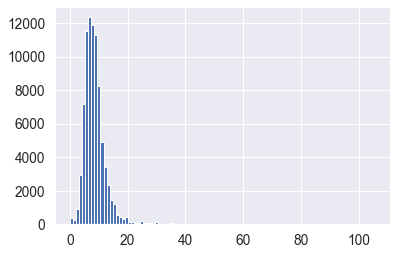

In [715]:
all_data_lagged["Close"].hist(bins=100);

Features seem to be positive skew, and have different scale. --> Need to standardise

In [720]:
all_data_lagged.columns

Index(['Date', 'HH', 'Close', 'Time', 'Sell_volume(kWh)', 'Buy_volume(kWh)',
       'Total_volume(kWh)', 'System_price(Yen/kWh)', 'Price_Hokkaido(Yen/kWh)',
       'Price_Tokyo(Yen/kWh)',
       ...
       'Allarea_Water_lag_2_Day', 'Allarea_Thermal_lag_2_Day',
       'Allarea_Geothermal_lag_2_Day', 'Allarea_Biomass_lag_2_Day',
       'Allarea_PumpedStorage_lag_2_Day', 'Allarea_Interconnection_lag_2_Day',
       'Water_Ratio_lag_2_Day', 'Thermal_Ratio_lag_2_Day',
       'Geothermal_Ratio_lag_2_Day', 'VWAP_lag_2_Day'],
      dtype='object', length=143)

In [721]:
all_data_lagged1 = all_data_lagged[['Date', 'Time', 'HH', 'date_block_num', 'month', 'dayofweek', 'holiday', 'Planned_Min_flag', 'Planned_Max_flag']]
all_data_lagged2 = all_data_lagged.drop(['Date', 'Time', 'HH', 'date_block_num', 'month', 'dayofweek', 'holiday', 'Planned_Min_flag', 'Planned_Max_flag'], axis=1)

In [722]:
# # logarithmic transformation for standardised
# # 0と負の値を含む列があるので、PowerTransformer()のYeo-Johnson変換を適用する (対数変換の一種)
from sklearn.preprocessing import PowerTransformer
def trans_yeo_johnson(df, df2):
    pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
    pt.fit_transform(df)
    return pt.transform(df2)

def inverse_trans_yeo_johnson(df, df2):
    pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
    pt.fit_transform(df)
    return pt.inverse_transform(df2)

In [723]:
#　対数変換
all_data_log2_transformed = all_data_lagged2.copy()
cols = all_data_log2_transformed.columns

all_data_log2_transformed = trans_yeo_johnson(all_data_lagged2, all_data_log2_transformed)
all_data_log2_transformed = pd.DataFrame(all_data_log2_transformed)
all_data_log2_transformed.columns = cols

In [724]:
all_data_log = pd.concat([all_data_lagged1, all_data_log2_transformed], axis=1)

In [725]:
all_data_log.tail()

Date      Time  HH  date_block_num  month  dayofweek  holiday  \
83232 2020-12-31  21:30:00  44          1736.0     12          3        0   
83233 2020-12-31  22:00:00  45          1736.0     12          3        0   
83234 2020-12-31  22:30:00  46          1736.0     12          3        0   
83235 2020-12-31  23:00:00  47          1736.0     12          3        0   
83236 2020-12-31  23:30:00  48          1736.0     12          3        0   

       Planned_Min_flag  Planned_Max_flag     Close  Sell_volume(kWh)  \
83232               0.0               0.0  5.598840          0.516449   
83233               0.0               0.0  4.426138          0.453161   
83234               0.0               0.0  4.169223          0.465061   
83235               0.0               0.0  3.849102          0.430196   
83236               0.0               0.0  2.989604          0.428051   

       Buy_volume(kWh)  Total_volume(kWh)  System_price(Yen/kWh)  \
83232         1.185599           0.974135               4.063279   
83233         1.169556           0.929094               4.822947   
83234         1.121159           0.937532               4.464653   
83235         1.105853           0.912496               4.063279   
83236         1.054772           0.910793               3.075339   

       Price_Hokkaido(Yen/kWh)  Price_Tokyo(Yen/kWh)  Price_Kansai(Yen/kWh)  \
83232                 2.662748              3.253262               4.812611   
83233                 2.963647              3.504632               4.812611   
83234                 2.963647              3.504632               4.175984   
83235                 2.662748              3.253262               3.803454   
83236                 1.905177              2.578209               2.893114   

       BidExceed_diff  Spot_MA25d  Spot_MA75d  Spot_MA200d  Open_lag_1_Day  \
83232       -0.504388    3.603386    0.243553    -0.567171        3.808611   
83233       -0.504388    3.619269    0.248578    -0.567171        3.808611   
83234       -0.504388    3.635160    0.253609    -0.563221        3.808611   
83235       -0.504388    3.645758    0.258643    -0.563221        2.870562   
83236       -0.504388    3.656360    0.263681    -0.563221        2.236107   

       High_lag_1_Day  Low_lag_1_Day  Average_lag_1_Day  \
83232        3.019716       5.161585           4.171711   
83233        3.019716       5.161585           4.202185   
83234        3.019716       5.010110           3.862408   
83235        2.352052       4.997865           3.488440   
83236        2.257183       3.051924           2.768301   

       Volume(MWh/h)_lag_1_Day  Volume(Tick count)_lag_1_Day  \
83232                 0.964374                      1.904803   
83233                 1.540050                      2.077658   
83234                 1.305441                      1.882522   
83235                 1.480196                      1.768676   
83236                 1.556094                      2.003178   

       HourlyDemand_Hokkaido_lag_1_Day  HourlyDemand_Tohoku_lag_1_Day  \
83232                         1.239179                       0.721080   
83233                         1.119231                       0.587691   
83234                         1.248503                       0.567225   
83235                         1.377162                       0.546747   
83236                         1.361693                       0.462153   

       HourlyDemand_Tokyo_lag_1_Day  HourlyDemand_Chubu_lag_1_Day  \
83232                      0.181169                     -0.563988   
83233                      0.047689                     -0.689237   
83234                     -0.068614                     -0.729561   
83235                     -0.185834                     -0.770002   
83236                     -0.363290                     -0.872731   

       HourlyDemand_Hokuriku_lag_1_Day  HourlyDemand_Kansai_lag_1_Day  \
83232                         0.189121                       0.047164   
83233            

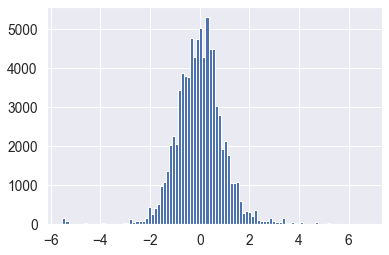

In [726]:
all_data_log["Close"].hist(bins=100);

※ Confirm whether inverse transform works for Close price appropriately, or not

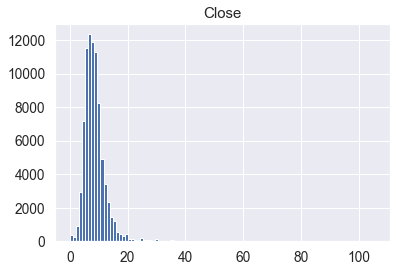

In [727]:
# inverse only for Close (Target)
y_log_inversed = inverse_trans_yeo_johnson(all_data_lagged2["Close"].values.reshape(-1,1), all_data_log["Close"].values.reshape(-1, 1))
y_log_inversed = pd.DataFrame(y_log_inversed)
y_log_inversed.columns = ["Close"]
y_log_inversed.hist(bins=100);

※If PowerTransformer does not work due to infinity value, the following process must be implemented.

In [143]:
# print(np.any(np.isnan(all_data_lagged).sum()))
# print(np.any(np.isfinite(all_data_lagged).sum()))

In [144]:
# Searching infinity value
# a = all_data_lagged.replace([np.inf, -np.inf], np.nan)
# print(a.isnull().sum().head(150))

In [145]:
# all_data_lagged_2 = all_data_lagged_2.drop(["Total_Daylag_1", "Total_Daylag_1_HHlag_1"], axis=1)
# print(np.any(np.isnan(all_data_lagged).sum()))
# print(np.any(np.isfinite(all_data_lagged).sum()))

※ Inverse_transform(逆対数変換)についても調べる！！　予測後のClose priceを元の数値に戻す必要がある！！

# EDA (for all_data)

## Check the correlation of features with the target
    -->通年と直近１年とスパンを変えて見てみる

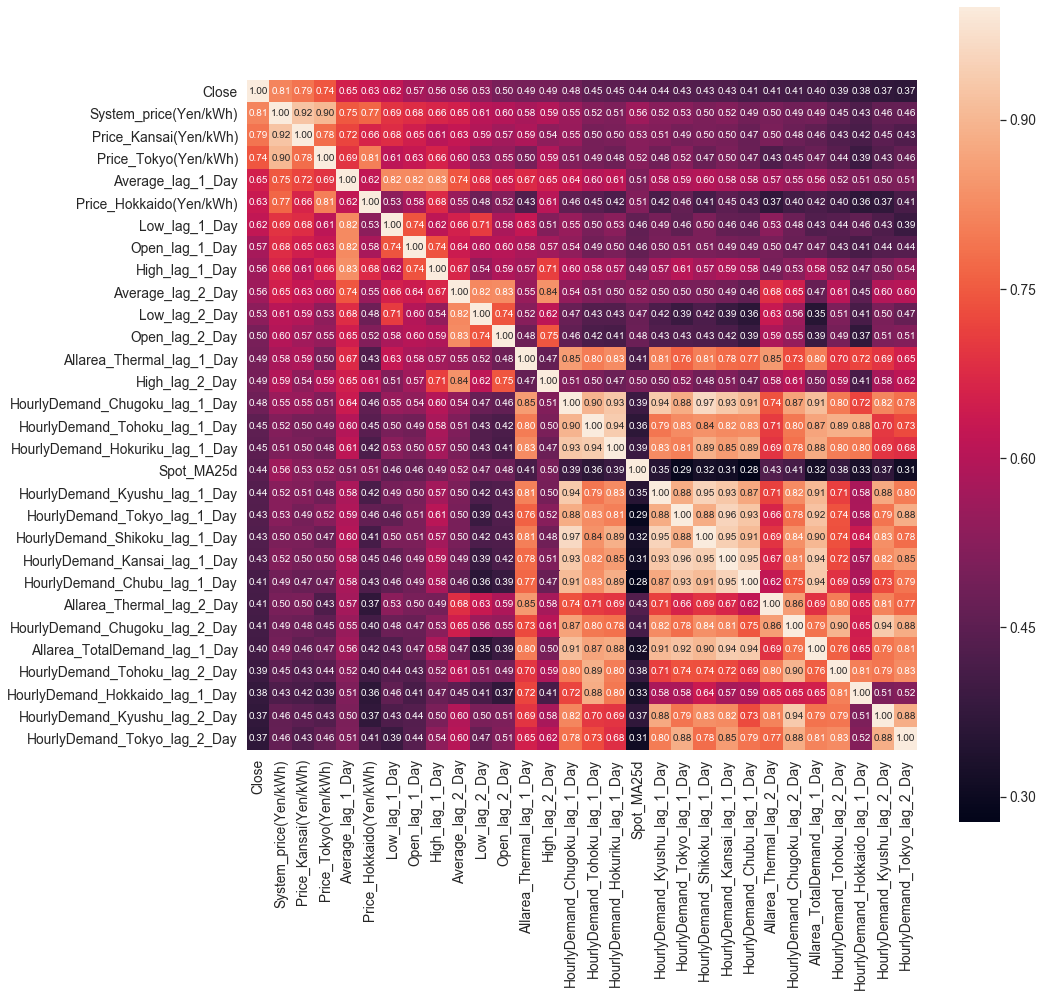

In [728]:
# correlation matrix
corrmat = all_data_log.corr()

# revenue correlation matrix
k = 30 # The number of variables on the heatmap
cols = corrmat.nlargest(k, 'Close')['Close'].index
cm = np.corrcoef(all_data_log[cols].values.T)
f, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [148]:
# # scatterplot
# sns.set()
# cols = ['Close', 'System_price(Yen/kWh)', 'Price_Tohoku(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 'Average_Daylag_2',
#         'Low_Daylag_2', 'Close_Daylag_2', 'Open_Daylag_2', 'High_Daylag_2', 'Low_Daylag_2_HHlag_1']
# sns.pairplot(all_data_log[cols], size=2.5)
# plt.show()

<メモ><p>
    - 外れ値は見られるが線形の関係が見られる
    - OpenとCloseの相関は見られないが、OpenとHighはなぜか相関が高い。（Openで高値がつきやすい？）
    - TokyoとTohokuは高い相関が見られる

外れ値はここで処理しておく --> ただし一概に外れ値を除去するべきとは限らない。要検討 <P>
全体のEDAで気になる点がでれば個別にEDA

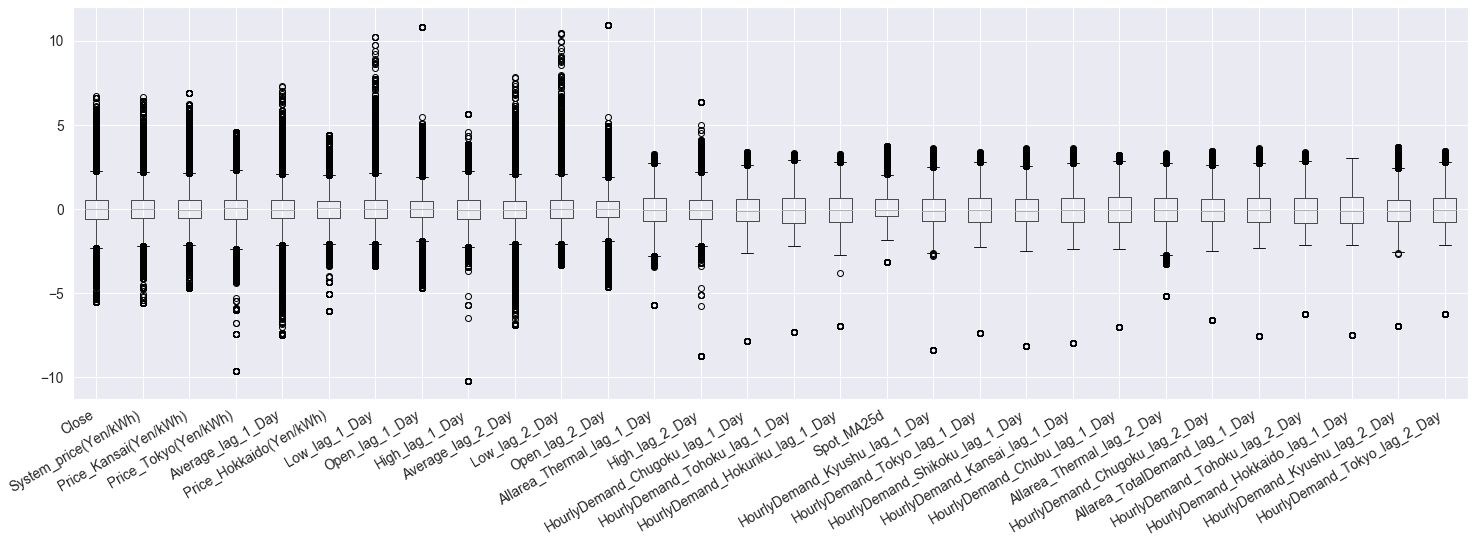

In [729]:
plt.figure(figsize = (25,8))
all_data_log[cols].boxplot()
plt.gcf().autofmt_xdate()

plt.show()

スケールも整っている

In [150]:
# Remove the ourliers 
# all_data = all_data[all_data.item_price<60000]

In [151]:
# Re-confirm the outliers with scatter plot
# var = "item_price"
# data = pd.concat([all_data['item_cnt_month'], all_data[var]], axis=1)
# data.plot.scatter(x=var, y='item_cnt_month', ylim=(0,100));

In [730]:
#整理後のtraining data
all_data_log.tail()

Date      Time  HH  date_block_num  month  dayofweek  holiday  \
83232 2020-12-31  21:30:00  44          1736.0     12          3        0   
83233 2020-12-31  22:00:00  45          1736.0     12          3        0   
83234 2020-12-31  22:30:00  46          1736.0     12          3        0   
83235 2020-12-31  23:00:00  47          1736.0     12          3        0   
83236 2020-12-31  23:30:00  48          1736.0     12          3        0   

       Planned_Min_flag  Planned_Max_flag     Close  Sell_volume(kWh)  \
83232               0.0               0.0  5.598840          0.516449   
83233               0.0               0.0  4.426138          0.453161   
83234               0.0               0.0  4.169223          0.465061   
83235               0.0               0.0  3.849102          0.430196   
83236               0.0               0.0  2.989604          0.428051   

       Buy_volume(kWh)  Total_volume(kWh)  System_price(Yen/kWh)  \
83232         1.185599           0.974135               4.063279   
83233         1.169556           0.929094               4.822947   
83234         1.121159           0.937532               4.464653   
83235         1.105853           0.912496               4.063279   
83236         1.054772           0.910793               3.075339   

       Price_Hokkaido(Yen/kWh)  Price_Tokyo(Yen/kWh)  Price_Kansai(Yen/kWh)  \
83232                 2.662748              3.253262               4.812611   
83233                 2.963647              3.504632               4.812611   
83234                 2.963647              3.504632               4.175984   
83235                 2.662748              3.253262               3.803454   
83236                 1.905177              2.578209               2.893114   

       BidExceed_diff  Spot_MA25d  Spot_MA75d  Spot_MA200d  Open_lag_1_Day  \
83232       -0.504388    3.603386    0.243553    -0.567171        3.808611   
83233       -0.504388    3.619269    0.248578    -0.567171        3.808611   
83234       -0.504388    3.635160    0.253609    -0.563221        3.808611   
83235       -0.504388    3.645758    0.258643    -0.563221        2.870562   
83236       -0.504388    3.656360    0.263681    -0.563221        2.236107   

       High_lag_1_Day  Low_lag_1_Day  Average_lag_1_Day  \
83232        3.019716       5.161585           4.171711   
83233        3.019716       5.161585           4.202185   
83234        3.019716       5.010110           3.862408   
83235        2.352052       4.997865           3.488440   
83236        2.257183       3.051924           2.768301   

       Volume(MWh/h)_lag_1_Day  Volume(Tick count)_lag_1_Day  \
83232                 0.964374                      1.904803   
83233                 1.540050                      2.077658   
83234                 1.305441                      1.882522   
83235                 1.480196                      1.768676   
83236                 1.556094                      2.003178   

       HourlyDemand_Hokkaido_lag_1_Day  HourlyDemand_Tohoku_lag_1_Day  \
83232                         1.239179                       0.721080   
83233                         1.119231                       0.587691   
83234                         1.248503                       0.567225   
83235                         1.377162                       0.546747   
83236                         1.361693                       0.462153   

       HourlyDemand_Tokyo_lag_1_Day  HourlyDemand_Chubu_lag_1_Day  \
83232                      0.181169                     -0.563988   
83233                      0.047689                     -0.689237   
83234                     -0.068614                     -0.729561   
83235                     -0.185834                     -0.770002   
83236                     -0.363290                     -0.872731   

       HourlyDemand_Hokuriku_lag_1_Day  HourlyDemand_Kansai_lag_1_Day  \
83232                         0.189121                       0.047164   
83233            

## 各特徴量の再調整

外れ値を削除 or 残す
EDAの結果を見て不要な特徴量は削除 (特徴量間の相関が高いもの、目的関数との相関がないものを除外)

- 特徴量選択: https://qiita.com/shimopino/items/5fee7504c7acf044a521

# Training Models with "all_data"

機械学習アルゴまとめ: https://qiita.com/tomomoto/items/b3fd1ec7f9b68ab6dfe2

ここですべきことはクロスバリデーションでのモデル構築 --> 今回はwalk-forward validationを採用

TimeSeries validation from scikit-learn
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

参照(ブログ)<p>
- https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
- https://aizine.ai/cross-validation0910/#toc12

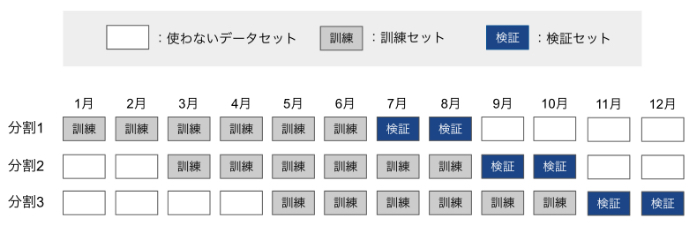

Split all_data set based on time-base

## Preparation

In [1021]:
X = all_data_log.drop(['Close', 'Date', 'Time'], axis=1)
y = all_data_log.Closey = all_data_log.Close

Split all_data into train and valid for validation

In [1022]:
# # Time series validation　※今回は使わない
# from sklearn.model_selection import TimeSeriesSplit

# n_splits=10
# test_size=1680 # about 20% of the sample size devided by 10

# tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
# Min_valid_index = max(X.index) - n_splits * test_size + 1

# print(tscv)
# print('Minimum of valid_index: %.0f' % Min_valid_index)

# # Confirming the split logic
# for train_index, valid_index in tscv.split(X):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
#     print("TRAIN:", train_index, "Valid:", valid_index)

In [1023]:
# Rolling/Walk forward validation
all_records = len(X) # The number of row of train data, including "0"
n_splits = 10
valid_size =1670  # about 20% of the sample size devided by 10
Initial_train = all_records - valid_size*n_splits # the number of the last index of train data

# for t, v in zip
Rolling_forward_split_train = list(range(Initial_train, all_records, valid_size))
Rolling_forward_split_valid = list(range(Initial_train+valid_size, all_records+valid_size,  valid_size))

Min_valid_index = all_records -  n_splits * valid_size
print('Minimum of valid_index: %.0f' % Min_valid_index)

# Confirming the logic for validation split
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    print("TRAIN:", X_train.index[-1], "Valid:", X_valid.index[-1])

Minimum of valid_index: 66537
TRAIN: 66536 Valid: 68206
TRAIN: 68206 Valid: 69876
TRAIN: 69876 Valid: 71546
TRAIN: 71546 Valid: 73216
TRAIN: 73216 Valid: 74886
TRAIN: 74886 Valid: 76556
TRAIN: 76556 Valid: 78226
TRAIN: 78226 Valid: 79896
TRAIN: 79896 Valid: 81566
TRAIN: 81566 Valid: 83236


Make the tables for graph visualisation and for evaluation results

In [1024]:
# DataTable for graph_log
graph_data_log = all_data_log[["Date", "Time", "Close"]]
graph_data_log["DateTime"] = pd.to_datetime(graph_data_log["Date"].astype(str) + " " + graph_data_log["Time"].astype(str))
prediction_point = graph_data_log["DateTime"][graph_data_log.index==Min_valid_index].iat[-1]
graph_data_log = graph_data_log.drop(["Date", "Time"], axis=1)
print("Prediction_point: {}".format(prediction_point))

# DataTable for Evaluation results_log
Eval_table_log = pd.DataFrame()
Eval_table_log["EvalFunc"] = pd.Series(["RMSE_log", "MAE_log"])
Eval_table_log

Prediction_point: 2020-01-19 00:30:00


EvalFunc
0  RMSE_log
1   MAE_log

In [1025]:
# DataTable for graph_original
graph_data_original = all_data_lagged[["Date", "Time", "Close"]]
graph_data_original["DateTime"] = pd.to_datetime(graph_data_original["Date"].astype(str) + " " + graph_data_original["Time"].astype(str))
prediction_point = graph_data_original["DateTime"][graph_data_original.index==Min_valid_index].iat[-1]
graph_data_original = graph_data_original.drop(["Date", "Time"], axis=1)
print("Prediction_point: {}".format(prediction_point))

# DataTable for Evaluation functions_original
Eval_table_original = pd.DataFrame()
Eval_table_original["EvalFunc"] = pd.Series(["RMSE_Yen/kWh", "MAE_Yen/kWh"])
Eval_table_original

Prediction_point: 2020-01-19 00:30:00


EvalFunc
0  RMSE_Yen/kWh
1   MAE_Yen/kWh

## Linear model

### Linear regression

In [1026]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt
import itertools

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Line = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelLine = LinearRegression().fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelLine.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Line.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelLine.score(X_train, y_train))     
    valid_accuracy.append(modelLine.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Line = list(itertools.chain.from_iterable(prediction_Line))
# Prediction with train data
y_pred_train = list(modelLine.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Linear"] = pd.Series(y_pred_train + prediction_Line)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Linear"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.6604583002562149
Valid_accuracy: 0.5271589072169636
RMSE: 0.6918656910495697
MAE: 0.47868228590817663


### Ridge

In [1027]:
# Searching the optimal alpha
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    # For the test of alpha
    for alpha in [0.1, 1, 3, 7, 10]: # alphaで特に結果の違いなし (0.1, 1, 3, 7, 10)
        modelRidge = Ridge(alpha=alpha).fit(X_train, y_train)
        print("\n alpha={}".format(str(alpha)))
        print("Train set score: {:.2f}".format(modelRidge.score(X_train, y_train)))
        print("Test set score: {:.2f}".format(modelRidge.score(X_valid, y_valid)))
        y_pred = modelRidge.predict(X_valid)       
        print("RMSE: {:.2f}".format(sqrt(mean_squared_error(y_valid, y_pred))) )      
        print("MAE: {:.2f}".format(mean_absolute_error(y_valid, y_pred)))
        print("Number of features used:{}".format(np.sum(modelRidge.coef_ != 0)))


 alpha=0.1
Train set score: 0.63
Test set score: 0.48
RMSE: 0.53
MAE: 0.33
Number of features used:140

 alpha=1
Train set score: 0.63
Test set score: 0.48
RMSE: 0.53
MAE: 0.33
Number of features used:140

 alpha=3
Train set score: 0.63
Test set score: 0.48
RMSE: 0.53
MAE: 0.33
Number of features used:140

 alpha=7
Train set score: 0.63
Test set score: 0.48
RMSE: 0.53
MAE: 0.33
Number of features used:140

 alpha=10
Train set score: 0.63
Test set score: 0.48
RMSE: 0.53
MAE: 0.33
Number of features used:140

 alpha=0.1
Train set score: 0.63
Test set score: 0.42
RMSE: 0.75
MAE: 0.54
Number of features used:140

 alpha=1
Train set score: 0.63
Test set score: 0.42
RMSE: 0.75
MAE: 0.54
Number of features used:140

 alpha=3
Train set score: 0.63
Test set score: 0.42
RMSE: 0.75
MAE: 0.54
Number of features used:140

 alpha=7
Train set score: 0.63
Test set score: 0.42
RMSE: 0.75
MAE: 0.54
Number of features used:140

 alpha=10
Train set score: 0.63
Test set score: 0.42
RMSE: 0.75
MAE: 0.54
Nu

The results are almost the same. --> Choose 10

In [1028]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Ridge = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model
    modelRidge = linear_model.Ridge(alpha=10).fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelRidge.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Ridge.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelRidge.score(X_train, y_train))     
    valid_accuracy.append(modelRidge.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Ridge = list(itertools.chain.from_iterable(prediction_Ridge))
# Prediction with train data
y_pred_train = list(modelRidge.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Ridge"] = pd.Series(y_pred_train + prediction_Ridge)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Ridge"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.660453506698423
Valid_accuracy: 0.5275247293975027
RMSE: 0.6915884725537103
MAE: 0.47843556349117994


### Lasso

In [1029]:
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    # For the test of alpha
    for alpha in [0.02, 0.5, 1]: #0.02 is the best (0.02, 0.5, 1)
        modelLasso = Lasso(alpha=alpha).fit(X_train, y_train)
        print("\n alpha={}".format(str(alpha)))
        print("Train set score: {:.2f}".format(modelLasso.score(X_train, y_train)))
        print("Test set score: {:.2f}".format(modelLasso.score(X_valid, y_valid)))
        y_pred = modelLasso.predict(X_valid)       
        print("RMSE: {:.2f}".format(sqrt(mean_squared_error(y_valid, y_pred))) )      
        print("MAE: {:.2f}".format(mean_absolute_error(y_valid, y_pred)))
        print("Number of features used:{}".format(np.sum(modelLasso.coef_ != 0)))


 alpha=0.02
Train set score: 0.62
Test set score: 0.48
RMSE: 0.53
MAE: 0.33
Number of features used:17

 alpha=0.5
Train set score: 0.05
Test set score: -0.29
RMSE: 0.84
MAE: 0.59
Number of features used:2

 alpha=1
Train set score: 0.04
Test set score: -0.29
RMSE: 0.84
MAE: 0.60
Number of features used:2

 alpha=0.02
Train set score: 0.62
Test set score: 0.41
RMSE: 0.76
MAE: 0.55
Number of features used:18

 alpha=0.5
Train set score: 0.05
Test set score: -0.79
RMSE: 1.32
MAE: 1.03
Number of features used:2

 alpha=1
Train set score: 0.04
Test set score: -0.79
RMSE: 1.32
MAE: 1.03
Number of features used:2

 alpha=0.02
Train set score: 0.62
Test set score: 0.48
RMSE: 0.90
MAE: 0.68
Number of features used:19

 alpha=0.5
Train set score: 0.05
Test set score: -0.65
RMSE: 1.61
MAE: 1.14
Number of features used:2

 alpha=1
Train set score: 0.05
Test set score: -0.65
RMSE: 1.61
MAE: 1.14
Number of features used:2

 alpha=0.02
Train set score: 0.63
Test set score: 0.54
RMSE: 0.85
MAE: 0.63

0.02 is the optimal

In [1030]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Lasso = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelLasso = linear_model.Lasso(alpha=0.02).fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelLasso.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Lasso.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelLasso.score(X_train, y_train))     
    valid_accuracy.append(modelLasso.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Lasso = list(itertools.chain.from_iterable(prediction_Lasso))
# Prediction with train data
y_pred_train = list(modelLasso.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Lasso"] = pd.Series(y_pred_train + prediction_Lasso)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Lasso"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.6461358360037538
Valid_accuracy: 0.5343753332948877
RMSE: 0.68634088014684
MAE: 0.4720187079323443


In [1031]:
graph_data_log

Close            DateTime  Close_pred_Linear  Close_pred_Ridge  \
0     -0.074290 2016-04-01 00:00:00          -0.256920         -0.258836   
1     -0.147582 2016-04-01 00:30:00          -0.342387         -0.344330   
2     -0.222922 2016-04-01 01:00:00          -0.353812         -0.355922   
3     -0.271103 2016-04-01 01:30:00          -0.400689         -0.402879   
4     -0.222922 2016-04-01 02:00:00          -0.296282         -0.297574   
...         ...                 ...                ...               ...   
83232  5.598840 2020-12-31 21:30:00           3.366062          3.367923   
83233  4.426138 2020-12-31 22:00:00           3.702821          3.703939   
83234  4.169223 2020-12-31 22:30:00           3.402866          3.404466   
83235  3.849102 2020-12-31 23:00:00           3.040627          3.041978   
83236  2.989604 2020-12-31 23:30:00           2.280693          2.281765   

       Close_pred_Lasso  
0             -0.580227  
1             -0.663723  
2             -0.665277  
3             -0.717893  
4             -0.605941  
...                 ...  
83232          3.408175  
83233          3.758023  
83234          3.448985  
83235          3.152188  
83236          2.334900  

[83237 rows x 5 columns]

In [1032]:
Eval_table_log

EvalFunc    Linear     Ridge     Lasso
0  RMSE_log  0.691866  0.691588  0.686341
1   MAE_log  0.478682  0.478436  0.472019

### Interpretation of the linear model
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

In [1033]:
print("Intercept: {}".format(modelLine.intercept_))

feature_names = X_train.columns
coefs = pd.DataFrame(modelLasso.coef_, columns=['Coefficients'], index=feature_names
).sort_values('Coefficients', ascending=False)
print(coefs.head())
print(coefs.tail())

Intercept: 0.1297931665234153
                       Coefficients
System_price(Yen/kWh)      0.429931
Price_Kansai(Yen/kWh)      0.220179
Price_Tokyo(Yen/kWh)       0.097818
Low_lag_1_Day              0.051762
Average_lag_1_Day          0.027555
                         Coefficients
month                       -0.002738
Nuclear_SHI_lag_2_Day       -0.006119
Volume(MWh/h)_lag_2_Day     -0.007879
Spot_MA75d                  -0.010222
dayofweek                   -0.013699


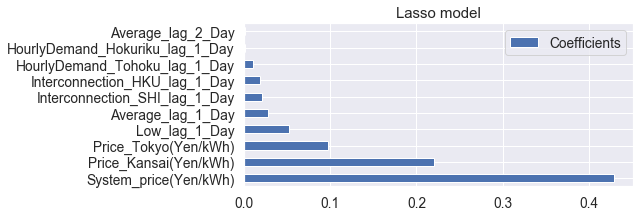

In [1034]:
# Positive coeficients
coefs[:10].plot(kind='barh', figsize=(9, 3))
plt.title('Lasso model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

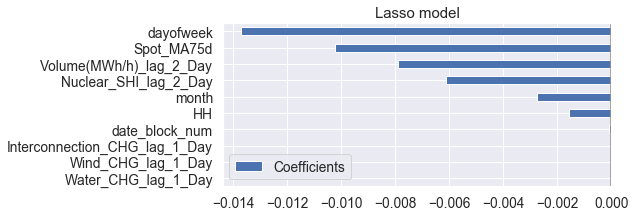

In [1035]:
# Negative coeficients
end = len(coefs)
start = end - 10
coefs[start:end].plot(kind='barh', figsize=(9, 3))
plt.title('Lasso model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Non-linear model

## Linear Regression with PolynomialFeatures

In [1036]:
X.shape

(83237, 140)

In [1037]:
# Make polynominal features
from sklearn.preprocessing import PolynomialFeatures

dimension = 2
polynomial = PolynomialFeatures(degree=dimension)
Poly_X = polynomial.fit_transform(X)
Poly_X = pd.DataFrame(Poly_X)

In [1038]:
Poly_X.shape

(83237, 10011)

特徴量選択で次数を十分減らした後場合のみ実行可能！！

In [1039]:
# from sklearn.preprocessing import PolynomialFeatures

# training_accuracy = []
# valid_accuracy = []
# rmse = []
# mae = []
# prediction_PolyLine = []
    
# for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = Poly_X.iloc[:train_index], Poly_X.iloc[train_index: valid_index]
#     y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
#     #Fit train set to the model (Chooose one model)
#     modelPolyLine = LinearRegression().fit(X_train, y_train)
    
#     # Generate prediction results
#     y_pred = modelPolyLine.predict(X_valid)
#     true_values = y_valid.values
#     # Save prediction results
#     prediction_PolyLine.append(y_pred)
#     # Save evaluation results for each 10 validation and get mean
#     training_accuracy.append(modelPolyLine.score(X_train, y_train))     
#     valid_accuracy.append(modelPolyLine.score(X_valid, y_valid))     
#     rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
#     mae.append(mean_absolute_error(true_values, y_pred))

# # print("Training_accuracy: {}".format(training_accuracy))
# print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# # print("Valid_accuracy: {}".format(valid_accuracy))
# print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# # print("RMSE: {}".format(rmse))
# print("RMSE: {}".format(np.mean(rmse)))
# # print("MAE: {}".format(mae))
# print("MAE: {}".format(np.mean(mae)))

# # Convert prediction results with valid data from 2D list to 1D list
# prediction_PolyLine = list(itertools.chain.from_iterable(prediction_PolyLine))
# # Prediction with train data
# y_pred_train = list(modelPolyLine.predict(X_train)[:Min_valid_index])
# # Store the prediction into the "graph data" table
# #graph_data_log = graph_data_log.reset_index()
# graph_data_log["Close_pred_PolyLinear"] = pd.Series(y_pred_train + prediction_PolyLine)
# # Store the result of evaluation into the "Eval_table"
# Eval_table_log["PolyLinear"] = pd.Series([np.mean(rmse), np.mean(mae)])

## XGBoost

In [1040]:
from xgboost import XGBRegressor

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_XGB = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]

    #Fit train set to the model
    modelXGB = XGBRegressor().fit(X_train, y_train)   
    # Generate prediction results
    y_pred = modelXGB.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_XGB.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelXGB.score(X_train, y_train))     
    valid_accuracy.append(modelXGB.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_XGB = list(itertools.chain.from_iterable(prediction_XGB))
# Prediction with train data
y_pred_train = list(modelXGB.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_XGB"] = pd.Series(y_pred_train + prediction_XGB)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["XGB"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.8083059719748743
Valid_accuracy: 0.3629324594064377
RMSE: 0.8032947334402305
MAE: 0.5711340885219902


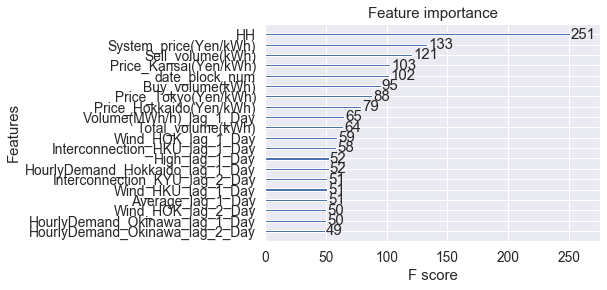

<Figure size 1000x500 with 0 Axes>

In [1041]:
# Feature importance of the last train set
from xgboost import plot_importance

# plot feature importance
plot_importance(modelXGB, max_num_features = 20)
plt.figure(figsize=(10, 5),dpi=100)
plt.show()

## RandomForest ※時間がかかるのでskip

In [1042]:
from sklearn.ensemble import RandomForestRegressor

# training_accuracy = []
# valid_accuracy = []
# rmse = []
# mae = []
# prediction_RF = []

# for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
#     y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]

#     #Fit train set to the model
#     modelRF = RandomForestRegressor(n_jobs = -1).fit(X_train, y_train) 
#     # Generate prediction results
#     y_pred = modelRF.predict(X_valid)
#     true_values = y_valid.values
#     # Save prediction results
#     prediction_RF.append(y_pred)
#     # Save evaluation results for each 10 validation and get mean
#     training_accuracy.append(modelRF.score(X_train, y_train))     
#     valid_accuracy.append(modelRF.score(X_valid, y_valid))     
#     rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
#     mae.append(mean_absolute_error(true_values, y_pred))

# # print("Training_accuracy: {}".format(training_accuracy))
# print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# # print("Valid_accuracy: {}".format(valid_accuracy))
# print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# # print("RMSE: {}".format(rmse))
# print("RMSE: {}".format(np.mean(rmse)))
# # print("MAE: {}".format(mae))
# print("MAE: {}".format(np.mean(mae)))

# # Convert prediction results with valid data from 2D list to 1D list
# prediction_RF = list(itertools.chain.from_iterable(prediction_RF))
# # Prediction with train data
# y_pred_train = list(modelRF.predict(X_train)[:Min_valid_index])
# # Store the prediction into the "graph data" table
# graph_data_log["Close_pred_RF"] = pd.Series(y_pred_train + prediction_RF)
# # Store the result of evaluation into the "Eval_table"
# Eval_table_log["RF"] = pd.Series([np.mean(rmse), np.mean(mae)])

In [1043]:
# Feature importance of the last train set
# # plot feature importance
# df_feature_importance = pd.DataFrame(modelRF.feature_importances_, index=feature_list, columns=['feature importance']).sort_values('feature importance', ascending=True)
# #df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in reg.estimators_], columns=boston.feature_names)
# df_feature_importance_top10 = df_feature_importance.tail(10)
# df_feature_importance_top10.plot(kind='barh');

# ARIMA model (基本的にパラメータチューニングはしない！)

複数の説明変数を
 - ARIMAに適用するならARIMAXモデル (ARIMAに直接適用可能)
 - SARIMAに適用するならSARIMAXモデル
    
(Reference)
VAR(比較的簡単): https://logics-of-blue.com/var%E3%83%A2%E3%83%87%E3%83%AB/
VAR: https://analytics-note.xyz/time-series/statsmodels-var-fit/
VAR(理論と実装): https://qiita.com/innovation1005/items/b5333a939c0341b46ba9
ARIMAX(数式のみ): https://qiita.com/shu-yusa/items/1c6148e4e6e523d644ae

In [1044]:
# Pick up  Date, Time , Close and cols that have high importance on the linear model
arima_cols = ["Date", "Time", "Close", "System_price(Yen/kWh)", "Price_Kansai(Yen/kWh)", "Price_Tokyo(Yen/kWh)", "Low_lag_1_Day", "Average_lag_1_Day"]

In [1045]:
# Data for statistical modeling
all_data_stats = all_data_log.copy()
all_data_stats = all_data_stats[arima_cols]
all_data_stats["DateTime"] = pd.to_datetime(all_data_stats["Date"].astype(str) + " " + all_data_stats["Time"].astype(str))
all_data_stats = all_data_stats.drop(["Date", "Time"], axis=1)
X_stats = all_data_stats.drop(['Close', "DateTime"], axis=1)
X_stats =  np.array(X_stats)
y_stats = all_data_stats[["Close"]]
y_stats =  np.array(y_stats)

In [1046]:
# ADF test for logarithmic price
ctt = sm.tsa.adfuller(y_stats, regression="ctt")
round(ctt[1], 4)

0.0

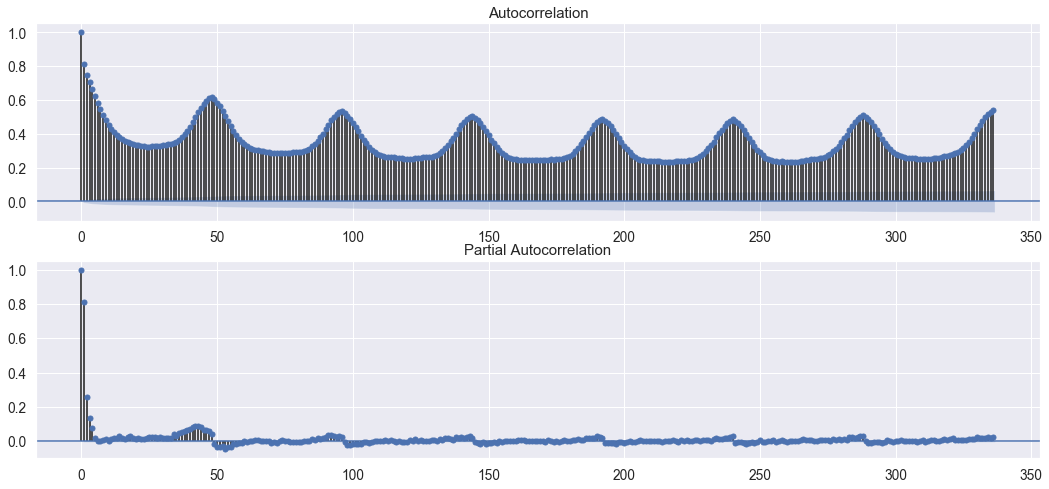

In [1047]:
# Autocorrelation
fig = plt.figure(figsize=(18,8))
# Autocorrelation (1lag=30min --> 336 lags=1week)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_stats, lags=336, ax=ax1)

# Partial Autocorrelation
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_stats, lags=336, ax=ax2)

### ARIMAX model

In [1048]:
from statsmodels.tsa.arima.model import ARIMA

modelARIMA = ARIMA(y_stats, exog=X_stats).fit()

# Summary
print(modelARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                83237
Model:                          ARIMA   Log Likelihood              -70719.756
Date:                Mon, 22 Mar 2021   AIC                         141453.512
Time:                        17:37:38   BIC                         141518.818
Sample:                             0   HQIC                        141473.495
                              - 83237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.295e-06      0.002     -0.003      0.998      -0.004       0.004
x1             0.3789      0.004     92.652      0.000       0.371       0.387
x2             0.2679      0.003     85.796      0.0

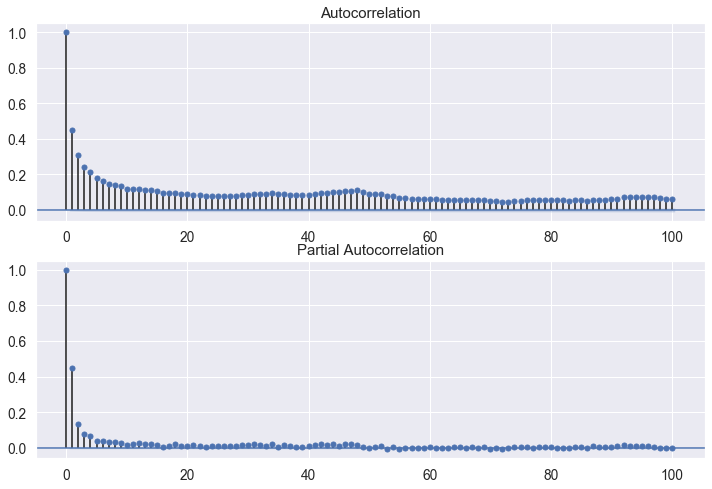

In [1049]:
# Check the residual
resid = modelARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=100, ax=ax2)

残差に周期性やパターンが残っているということは、モデルにそれらを組み込めていないということ

-->説明変数を組み込むと残差がかなり消える

In [1050]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_ARIMA = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the dataset  into 10 folds and pick up it.
    all_train, all_valid = all_data_stats.iloc[:train_index], all_data_stats.iloc[train_index: valid_index]
    all_train, all_valid = all_train.set_index("DateTime"), all_valid.set_index("DateTime")
    # Pandas --> ndarray
    X_train = all_train.drop(['Close'], axis=1)
    X_train =  np.array(X_train)
    y_train = all_train[["Close"]]
    y_train =  np.array(y_train)
    X_valid = all_valid.drop(['Close'], axis=1)
    X_valid =  np.array(X_valid)
    y_valid = all_valid[["Close"]]
    y_valid =  np.array(y_valid) 

    #Fit train set to the model
    modelARIMA = ARIMA(y_train, exog=X_train
#                        order=(2, 0, 3),
                      ).fit() #上記セルのパラメータを参照
    # Generate prediction results
    y_pred = modelARIMA.forecast(steps=valid_size, exog=X_valid) # valid_size is set on "Preparation"
    true_values = y_valid
    # Save prediction results
    prediction_ARIMA.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_ARIMA = list(itertools.chain.from_iterable(prediction_ARIMA))
# Prediction with train data
y_pred_train = list(modelARIMA.predict())
y_pred_train = y_pred_train[:train_index]
# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_ARIMA"] = pd.Series(y_pred_train + prediction_ARIMA)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["ARIMA"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 0.6866898043076508
MAE: 0.473519214106022


# SARIMAX model

In [1051]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelSARIMA = SARIMAX(y_stats, exog=X_stats).fit()
print(modelSARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                83237
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -61397.789
Date:                Mon, 22 Mar 2021   AIC                         122809.579
Time:                        17:42:46   BIC                         122874.885
Sample:                             0   HQIC                        122829.562
                              - 83237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3807      0.005     77.438      0.000       0.371       0.390
x2             0.2545      0.004     64.122      0.000       0.247       0.262
x3             0.1325      0.003     38.348      0.0

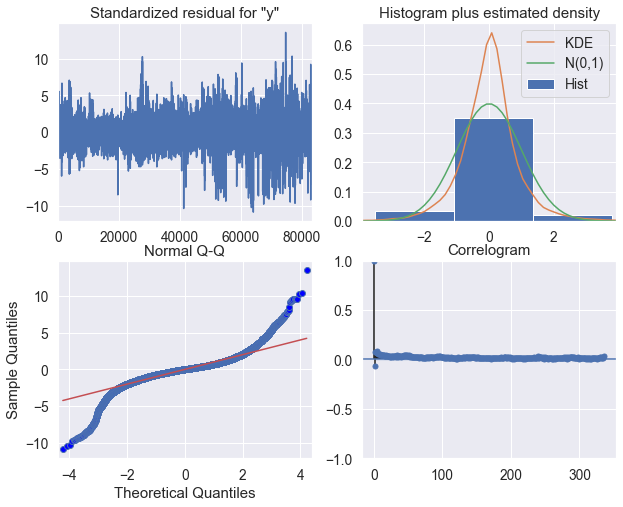

In [1052]:
# Check residual (If periodicity can be seen, SARIMA model would be better)
# Plot/confirm residual (White noise)
modelSARIMA.plot_diagnostics(lags=336, figsize=[10, 8]);

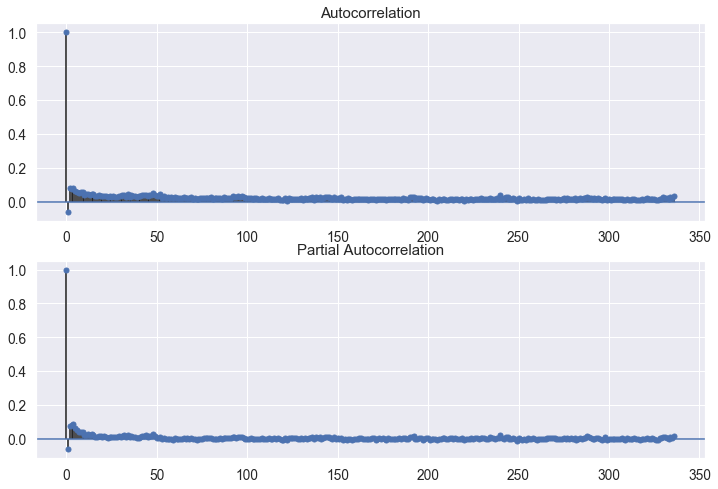

In [1053]:
# Plot pertial Autocorrelation
resid = modelSARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=336, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=336, ax=ax2)

SARIMAモデルのほうが季節性をカバーできているみたい --> SARIMAXですすめる

In [1054]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_SARIMA = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the dataset  into 10 folds and pick up it.
    all_train, all_valid = all_data_stats.iloc[:train_index], all_data_stats.iloc[train_index: valid_index]
    all_train, all_valid = all_train.set_index("DateTime"), all_valid.set_index("DateTime")
    # Pandas --> ndarray
    X_train = all_train.drop(['Close'], axis=1)
    X_train =  np.array(X_train)
    y_train = all_train[["Close"]]
    y_train =  np.array(y_train)
    X_valid = all_valid.drop(['Close'], axis=1)
    X_valid =  np.array(X_valid)
    y_valid = all_valid[["Close"]]
    y_valid =  np.array(y_valid) 
 
    #Fit train set to the model
    modelSARIMA = SARIMAX(y_train, exog=X_train
#                        order=(2, 0, 3),
                      ).fit() #上記セルのパラメータを参照
    # Generate prediction results
    y_pred = modelSARIMA.forecast(steps=valid_size, exog=X_valid) # valid_size is set on "Preparation"
    true_values = y_valid
    # Save prediction results
    prediction_SARIMA.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_SARIMA = list(itertools.chain.from_iterable(prediction_SARIMA))
# Prediction with train data
y_pred_train = list(modelSARIMA.predict())
y_pred_train = y_pred_train[:train_index]# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_SARIMA"] = pd.Series(y_pred_train + prediction_SARIMA)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["SARIMA"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 0.6868584022204651
MAE: 0.47365626809261896


## Prophet
Document of Prophet from Facebook
https://peerj.com/preprints/3190/

数式の理解
https://devblog.thebase.in/entry/2019/12/20/110000_1

日本語の解説 (公式ではないが結構細かい)
https://mikiokubo.github.io/analytics/15forecast.html

外部変数追加のチュートリアル
https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [1055]:
# # Pick up  Date, Time , Close and cols that have high importance on the linear model
X_cols = ["System_price(Yen/kWh)", "Price_Kansai(Yen/kWh)", "Price_Tokyo(Yen/kWh)", "Low_lag_1_Day", "Average_lag_1_Day"]

In [1056]:
# Set ds and y for the model
all_data_prop = all_data_stats.copy()
all_data_prop = all_data_prop.rename(columns={'DateTime': 'ds', 'Close': 'y'})

In [1057]:
# Divide dataset into train/valid set
all_data_prop_train = all_data_prop.iloc[all_data_prop.index[:Min_valid_index]]
all_data_prop_valid = all_data_prop.iloc[all_data_prop.index[Min_valid_index:]]

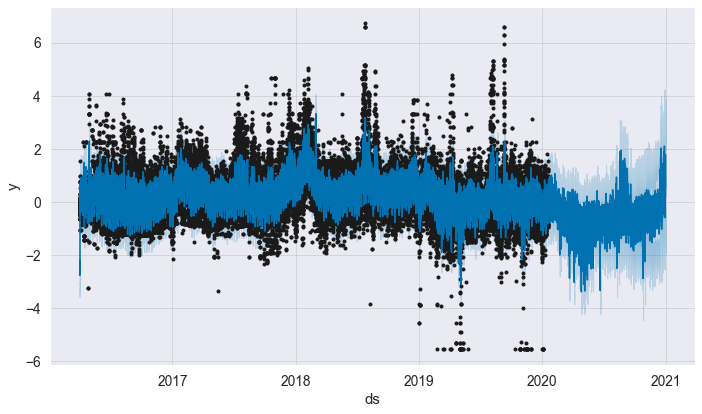

In [1059]:
from fbprophet import Prophet
modelProp = Prophet()
# set exog for train data
for x in X_cols:
    modelProp = Prophet().add_regressor(x)

# fit train data
modelProp = modelProp.fit(all_data_prop_train)
# Make prediction datatable
future = modelProp.make_future_dataframe(periods=len(all_data_prop_valid), freq='30min')

# set exog for valid data
for x in X_cols:
    future[x] = all_data_prop[x]

# Plot
forecast = modelProp.predict(future)
modelProp.plot(forecast);

[引用:パラメータの解説]
以下の例では、initialが730日なので、729日までの情報を用いて、その後365(horizon)日の予測を行い、本当の値との誤差を評価し、次いで730+180(period)日までの情報を用いて、その後365日の予測を行い評価し、という手順を最後の日まで繰り返す。(2905-730-365)/180 = 10.05であるので、11回の予測を行い評価することになる。cross_validationは、交差検証用のデータフレームを返す。<p>
    -->今回はTraining_dataのデータ日数1736に対し、InInitial1385daysを用いて最初にhorizon35dayを予測し、その後Period35day間隔で予測を繰り返す<p>
    -->つまり(1736-1385-1)/35 = 10times predictions

In [1060]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Prophet = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    train_prop, valid_prop = all_data_prop.iloc[:train_index], all_data_prop.iloc[train_index: valid_index]
#     y_train, y_valid = train_prop.set_index("ds"), valid_prop.set_index("ds")
    
    # Add exog for train data
    for x in X_cols:
        modelProphet = Prophet().add_regressor(x)
    
    # fit train data
    modelProphet = modelProphet.fit(train_prop) 
    # Make prediction datatable (Need to adjust the parameter of period to match the number of rows)
    future = modelProphet.make_future_dataframe(periods=len(valid_prop), freq='30min')
    # Add exog for valid data
    for x in X_cols:
        # Add exog for valid data
        future[x] = all_data_prop[x]
    
    # Generate prediction results
#     future = future.fillna(0, inplace=True)
    forecast = modelProphet.predict(future)
    y_pred = forecast["yhat"][train_index: valid_index]
    true_values = valid_prop["y"]
    # Save prediction results
    prediction_Prophet.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Prophet = list(itertools.chain.from_iterable(prediction_Prophet))
# Prediction with train data
y_pred_train = list(forecast["yhat"][:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Prophet"] = pd.Series(y_pred_train + prediction_Prophet)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Prophet"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 0.9304327975027616
MAE: 0.6344378790131235


# Visualisation of the model performance 

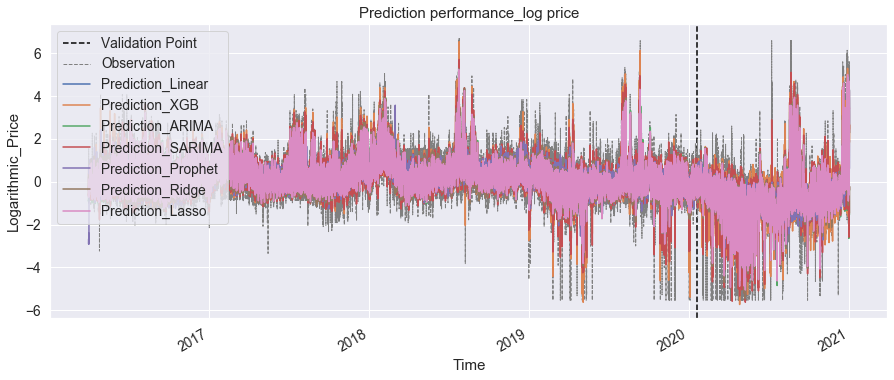

In [1083]:
#対数化されたターゲットと予測値の比較

Models = [
    "Linear",
#    ,"PolyLinear",
        "XGB", "ARIMA", "SARIMA", "Prophet", "Ridge", "Lasso"
         ]

fig, ax = plt.subplots(1, figsize=(15, 6))
plt.title('Prediction performance_log price')

# Set index
#graph_data_log = graph_data_log.set_index("DateTime")
start = "2016-04-01 00:00:00"
end = "2020-12-31 23:30:00"

# Vertical line (need to convert the date type from timestamp to datetime.datetime as x-axis)
plt.axvline(prediction_point.to_pydatetime(), label="Validation Point", linestyle="dashed", color="black")
# Add text for the vertical line
# plt.text(prediction_point.to_pydatetime(), -2, 'Prediction Point',rotation=0)

# Plot Close 
graph_data_log.Close[graph_data_log.index > start].plot(ax=ax, label="Observation", linestyle="dashed", color="gray", linewidth=1)

for model in Models:
    graph_data_log["Close_pred_" + model][graph_data_log.index > start].plot(ax=ax, label="Prediction_" + model)

# x-axis
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Logarithmic_Price")
plt.legend(loc="upper left");

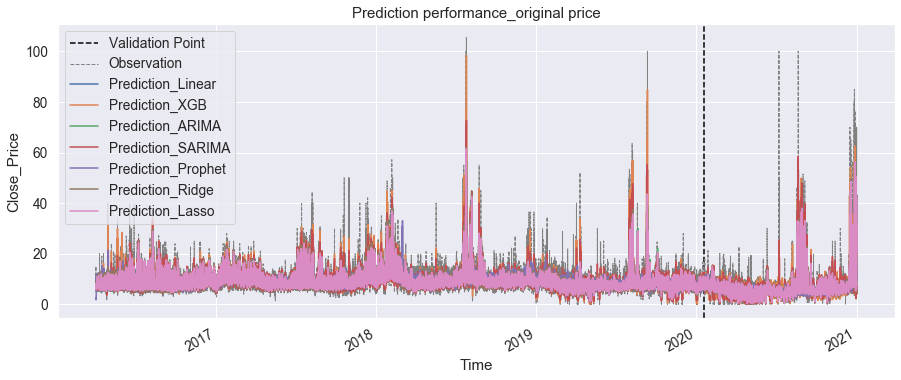

In [1084]:
graph_data_original = graph_data_original.reset_index()

Models = [
            "Linear",
#           , "PolyLinear",
          "XGB", "ARIMA", "SARIMA", "Prophet", "Ridge", "Lasso"]

for model in Models:
    # inverse for Prediction
    y_pred_original = inverse_trans_yeo_johnson(all_data_lagged["Close"].values.reshape(-1,1), graph_data_log["Close_pred_" + model].values.reshape(-1, 1))
    y_pred_original =  pd.DataFrame(y_pred_original)
    # Add the data on "graph_data"
    graph_data_original["Close_pred_" + model] = y_pred_original
    
    # Validation setに対してYen/kWhでの評価
    rmse = sqrt(mean_squared_error(graph_data_original.Close[Min_valid_index:], graph_data_original["Close_pred_" + model][Min_valid_index:]))
    mae = mean_absolute_error(graph_data_original.Close[Min_valid_index:], graph_data_original["Close_pred_" + model][Min_valid_index:])
    # Store the result of evaluation into the "Eval_table"
    Eval_table_original[model] = pd.Series([np.mean(rmse), np.mean(mae)])

graph_data_original = graph_data_original.set_index("DateTime")

# Plot the original close price and  predicted price
fig, ax = plt.subplots(1, figsize=(15, 6))
# Vertical line (need to convert the date type from timestamp to datetime.datetime as x-axis)
plt.axvline(prediction_point.to_pydatetime(), label="Validation Point", linestyle="dashed", color="black")
# Plot Close
graph_data_original.Close[graph_data_original.index > start].plot(ax=ax, label="Observation", linestyle="dashed", color="gray", linewidth=1)

# Plot the predicted price with each model
for model in Models:
    graph_data_original["Close_pred_" + model][graph_data_original.index > start].plot(ax=ax, label="Prediction_" + model)

# x-axis
plt.title('Prediction performance_original price')
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Close_Price")
plt.legend(loc="upper left");

In [1079]:
# Evalation for the prediction of validation data based on log
Eval_table_log

EvalFunc    Linear     Ridge     Lasso       XGB     ARIMA    SARIMA  \
0  RMSE_log  0.691866  0.691588  0.686341  0.803295  0.686690  0.686858   
1   MAE_log  0.478682  0.478436  0.472019  0.571134  0.473519  0.473656   

    Prophet  
0  0.930433  
1  0.634438

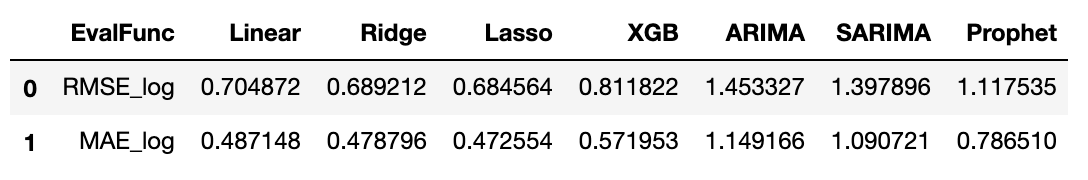

In [1080]:
# Evalation for the prediction of validation data based on original
Eval_table_original

EvalFunc    Linear       XGB     ARIMA    SARIMA   Prophet     Ridge  \
0  RMSE_Yen/kWh  3.215014  3.823378  5.286611  5.237117  5.098403  3.213483   
1   MAE_Yen/kWh  1.458982  1.748032  1.895013  1.771962  2.042499  1.458249   

      Lasso  
0  3.189685  
1  1.441427

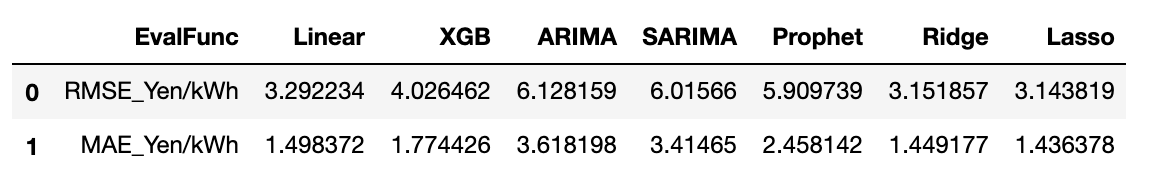

In [ ]:
all_data["Close"][Min_valid_index:].describe()

Target
- Mean: 6.693
- Std; 5.888

※
[Explanable easily but conservative]
Linear model
ARIMA, ARIMAX, etc
Prophet



# グリッドリサーチ (最後の最後に余裕があれば)
-->モデルを絞ったあとに実施する予定

In [ ]:
# #RandomForestのパラメーターチューニング
# from sklearn.model_selection import RandomizedSearchCV
# from random import randint
# modelRF = RandomForestRegressor(
#     n_estimators=200,
#   max_depth=3,
#   bootstrap=True,
#   criterion='mse'
# ).fit(x_train, y_train)

In [ ]:
# # predict target
# #y_preds_model_Line = pd.DataFrame(modelLine.predict(x_test)).round()
# y_preds_model_RF = pd.DataFrame(modelRF.predict(x_train)).round()
# #y_preds_model_XGB = pd.DataFrame(modelXGB.predict(x_train)).round()

In [ ]:
# y_preds_model_RF_valid = pd.DataFrame(modelRF.predict(x_valid)).round()

In [ ]:
# # Measure the score of RMSE which is the mesure to evaluate on this competition 
# from sklearn.metrics import mean_squared_error
# from numpy import sqrt
# rmse = sqrt(mean_squared_error(y_train, y_preds_model_RF))
# print('Val RMSE: %.3f' % rmse)

In [ ]:
# rmse = sqrt(mean_squared_error(y_valid, y_preds_model_RF_valid))
# print('Val RMSE: %.3f' % rmse)

Test XGBoost <p>
And, optimise the hyper parameter based on "RMSE"

In [ ]:
# #XGBoostのパラメーターチューニング
# modelXGB = XGBRegressor(
#     colsample_bytree=0.4,
#     gamma=0.1,
#     max_depth=13,
#     min_child_weight=3,
#     learning_rate=0.01,
#     subsample=1.0,
#     n_estimators=200,
#     scale_pos_weight=1,
# )
# modelXGB.fit(
#     x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_valid, y_valid)]
# )

In [ ]:
# print("XGB_Train set score: {:.2f}". format(modelXGB.score(x_train, y_train)))
# print("XGB_Valid set score: {:.2f}". format(modelXGB.score(x_valid, y_valid)))

In [ ]:
# y_preds_model_XGB = pd.DataFrame(modelXGB.predict(x_train)).round()

In [ ]:
# # Measure the score of RMSE which is the mesure to evaluate on this competition 
# from sklearn.metrics import mean_squared_error
# from numpy import sqrt
# rmse = sqrt(mean_squared_error(y_train, y_preds_model_XGB))
# print('Val RMSE: %.3f' % rmse)

In [ ]:
# y_preds_model_XGB_valid = pd.DataFrame(modelXGB.predict(x_valid)).round()

In [ ]:
# # Measure the score of RMSE which is the mesure to evaluate on this competition 
# from sklearn.metrics import mean_squared_error
# from numpy import sqrt
# rmse = sqrt(mean_squared_error(y_valid, y_preds_model_XGB_valid))
# print('Val RMSE: %.3f' % rmse)

# Making combined price data with all the tradable price ※必要なデータセットをCSVデータへ変換

必要なのは、Spot price, 予測後のClose　price

In [1082]:
all_data.head()

Date  HH  Open  High   Low  Close  Average  Volume(MWh/h)  \
0 2016-04-01   1  7.69  7.69  7.69   7.69     7.69           0.70   
1 2016-04-01   2  7.45  7.45  7.45   7.45     7.45           0.75   
2 2016-04-01   3  7.21  7.21  7.21   7.21     7.21           0.80   
3 2016-04-01   4  7.06  7.06  7.06   7.06     7.06           0.80   
4 2016-04-01   5  7.21  7.21  7.21   7.21     7.21           0.80   

   Volume(Tick count)      Time  Sell_volume(kWh)  Buy_volume(kWh)  \
0                   1  00:00:00           5077000          2120500   
1                   0  00:30:00           5621500          2239000   
2                   1  01:00:00           5710500          2219000   
3                   1  01:30:00           5536000          2202500   
4                   1  02:00:00           5461000          2192000   

   Total_volume(kWh)  System_price(Yen/kWh)  Price_Hokkaido(Yen/kWh)  \
0             675500                   6.61                     8.66   
1             755500                   6.34                     8.66   
2             713500                   6.34                     7.20   
3             717500                   6.25                     7.10   
4             870500                   6.57                     7.10   

   Price_Tokyo(Yen/kWh)  Price_Kansai(Yen/kWh)  BidExceed_diff  \
0                  6.69                   6.69               0   
1                  6.34                   6.34               0   
2                  6.34                   6.34               0   
3                  6.03                   6.03               0   
4                  6.57                   6.57               0   

   HourlyDemand_Hokkaido  HourlyDemand_Tohoku  HourlyDemand_Tokyo  \
0                 3166.0               7887.0             25547.0   
1                 3224.0               8022.5             24940.5   
2                 3282.0               8158.0             24334.0   
3                 3334.5               8289.0             24134.0   
4                 3387.0               8420.0             23934.0   

   HourlyDemand_Chubu  HourlyDemand_Hokuriku  HourlyDemand_Kansai  \
0             12372.0                 2935.0            12917.964   
1             12250.5                 3005.5            12876.666   
2             12129.0                 3076.0            12835.368   
3             12201.0                 3173.0            13093.248   
4             12273.0                 3270.0            13351.128   

   HourlyDemand_Chugoku  HourlyDemand_Shikoku  HourlyDemand_Kyushu  \
0             5813.8280                2552.0            8017.4620   
1             5904.7510                2638.0            8097.4965   
2             5995.6740                2724.0            8177.5310   
3             6199.1555                2853.0            8443.5965   
4             6402.6370                2982.0            8709.6620   

   HourlyDemand_Okinawa  Wind_TOH  Geothermal_TOH  PumpedStorage_TOH  \
0                644.70      46.0           116.0                0.0   
1                635.30      48.0           116.0                0.0   
2                625.90      50.0           116.0                0.0   
3                632.75      49.0           115.5                0.0   
4                639.60      48.0           115.0                0.0   

   Interconnection_TOH  Geothermal_HOK  Wind_HOK  Interconnection_HOK  \
0              -2200.0            13.0      40.0                 42.0   
1              -2189.0            13.0      37.0                 51.5   
2              -2178.0            13.0      34.0                 61.0   
3              -2174.5            13.0      31.5                 60.0   
4              -2171.0            13.0      29.0                 59.0   

   Wind_TKO  Interconnection_TKO  Wind_CHB  Interconnection_CHB  Wind_HKU  \
0       2.0                201.0      21.0               -331.0      12.0   
1       2.0                193.5      24.5               -403.5  

In [ ]:
# Finalise dataset and make the csv data for trading phase

# Decide one model for trading
model = "Linear"

df_prediction = all_data[['Date', 'HH', 'date_block_num', 'Open', 'High', 'Low', 'Close', 'System_price(Yen/kWh)']]
df_prediction["DateTime"] = graph_data_original.reset_index()["DateTime"]
df_prediction = df_prediction.rename(columns={'System_price(Yen/kWh)': 'Spot'})
df_prediction['date_block_num'] =  df_prediction['date_block_num'].astype(int)

graph_data_original = graph_data_original.reset_index()
df_prediction['Close_pred'] = graph_data_original["Close_pred_" + model].round(2)

# CSV file
df_prediction.to_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/df_prediction.csv', index=False)

In [ ]:
df_prediction.tail()